# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](https://community.alteryx.com/t5/Data-Science/Beginner-s-Guide-to-Customer-Segmentation/ba-p/138442) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

C:\Users\michen\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\michen\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\michen\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
%load_ext blackcellmagic
%load_ext ipycache
import numpy as np

C:\Users\michen\anaconda3\lib\site-packages\IPython\config.py:12: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  warn("The `IPython.config` package has been deprecated since IPython 4.0. "
C:\Users\michen\anaconda3\lib\site-packages\ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
# df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

C:\Users\michen\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
# df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\michen\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
# your turn

In [6]:
# examine data first
df_offers.info()
print()
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   offer_id   32 non-null     int64 
 1   campaign   32 non-null     object
 2   varietal   32 non-null     object
 3   min_qty    32 non-null     int64 
 4   discount   32 non-null     int64 
 5   origin     32 non-null     object
 6   past_peak  32 non-null     bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 1.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_name  324 non-null    object
 1   offer_id       324 non-null    int64 
 2   n              324 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


In [7]:
print("no missing values")

no missing values


In [8]:
df_offers.value_counts()

offer_id  campaign   varietal            min_qty  discount  origin        past_peak
1         January    Malbec              72       56        France        False        1
2         January    Pinot Noir          72       17        France        False        1
31        December   Champagne           72       89        France        False        1
30        December   Malbec              6        54        France        False        1
29        November   Pinot Grigio        6        87        France        False        1
28        November   Cabernet Sauvignon  12       56        France        True         1
27        October    Champagne           72       88        New Zealand   False        1
26        October    Pinot Noir          144      83        Australia     False        1
25        October    Cabernet Sauvignon  72       59        Oregon        True         1
24        September  Pinot Noir          6        34        Italy         False        1
23        September  Chard

In [9]:
df_transactions.value_counts()

customer_name  offer_id  n
Adams          18        1    1
Parker         16        1    1
Powell         5         1    1
Phillips       24        1    1
               17        1    1
                             ..
Harris         19        1    1
               7         1    1
               6         1    1
               4         1    1
Young          32        1    1
Length: 324, dtype: int64

In [10]:
all_unique = lambda x: len(x.value_counts()) == len(x)
print("Are all records unique?")
print(all_unique(df_offers) and all_unique(df_transactions))

Are all records unique?
True


In [11]:
matrix = (
    df_offers.merge(df_transactions)  # join the offers and transactions tables
    .pivot_table(  # create a pivot table that gives the number of times each customer responded to each given offer
        index=["customer_name"],
        columns=["offer_id"],
        values="n",
        fill_value=0,  # fill missing values with 0
    )
    .reset_index()  # make the index into a column
)
matrix.columns.rename("new_id", inplace=True)
matrix

new_id customer_name  1  2  3  4  5  6  7  8  9  ...  23  24  25  26  27  28  \
0              Adams  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   
1              Allen  0  0  0  0  0  0  0  0  1  ...   0   0   0   0   1   0   
2           Anderson  0  0  0  0  0  0  0  0  0  ...   0   1   0   1   0   0   
3             Bailey  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   0   0   
4              Baker  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   0   0   
..               ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..   
95          Williams  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   
96            Wilson  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   0   
97              Wood  1  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   
98            Wright  0  0  0  1  0  1  0  0  0  ...   0   0   0   0   1   0   
99             Young  0  0  0  0  0  1  0  0  1  ...   0   0   0   0   0   0   

new_id  29  30  31  32  
0        1   1   0   0  
1        0   0   0   0  
2        0   0   0   0  
3        0   1   0   0  
4        0   0   1   0  
..      ..  ..  ..  ..  
95       0   0   1   0  
96       0   1   0   0  
97       0   0   1   0  
98       0   0   0   0  
99       0   0   1   1  

[100 rows x 33 columns]

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce three methods: the Elbow method, the Silhouette method, and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [12]:
# your turn

In [13]:
# What values of 𝑆𝑆 do you believe represent better clusterings? Why?
print("Small values or those closer to zero represent better clusterings.")
print("In this context, SS is a measure of how far each data point is from the centroid of its cluster.")

Small values or those closer to zero represent better clusterings.
In this context, SS is a measure of how far each data point is from the centroid of its cluster.


In [14]:
# Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums).
x_cols = matrix.columns[1:]
x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='new_id')

In [15]:
# Write code that applies the `KMeans` clustering method from scikit-learn to this matrix.
from sklearn.cluster import KMeans

data = matrix[matrix.columns[1:]]  # omits customer_name
k_values = range(2, 11)
ss_values = [
    KMeans(n_clusters=n, random_state=2021).fit(data).inertia_ for n in k_values
]

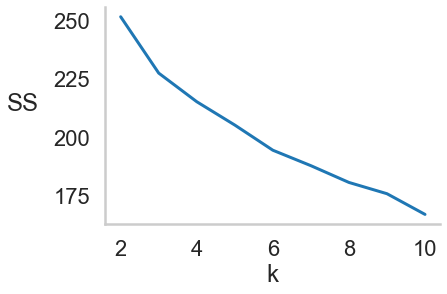

In [16]:
# Construct a plot showing 𝑆𝑆 for each 𝐾 and pick 𝐾 using this plot. For simplicity, test 2 ≤ 𝐾 ≤ 10.
sns.lineplot(x=k_values, y=ss_values).spines[["right", "top"]].set_visible(False)
plt.grid(False)
plt.xlabel("k")
plt.ylabel("SS", labelpad=30).set_rotation(0)
plt.show()

In [17]:
print("no clear elbow!")

no clear elbow!


In [18]:
k_values2 = range(2, len(data))

In [19]:
%%cache ss_values2.pkl ss_values2
ss_values2 = [
    KMeans(n_clusters=n, random_state=2021).fit(data).inertia_ for n in k_values2
]

[Skipped the cell's code and loaded variables ss_values2 from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\ss_values2.pkl'.]


<ipython-input-106-1896383db3fc>:2: ConvergenceWarning: Number of distinct clusters (89) found smaller than n_clusters (90). Possibly due to duplicate points in X.
  KMeans(n_clusters=n, random_state=2021).fit(data).inertia_ for n in k_values2
<ipython-input-106-1896383db3fc>:2: ConvergenceWarning: Number of distinct clusters (89) found smaller than n_clusters (91). Possibly due to duplicate points in X.
  KMeans(n_clusters=n, random_state=2021).fit(data).inertia_ for n in k_values2
<ipython-input-106-1896383db3fc>:2: ConvergenceWarning: Number of distinct clusters (89) found smaller than n_clusters (92). Possibly due to duplicate points in X.
  KMeans(n_clusters=n, random_state=2021).fit(data).inertia_ for n in k_values2
<ipython-input-106-1896383db3fc>:2: ConvergenceWarning: Number of distinct clusters (89) found smaller than n_clusters (93). Possibly due to duplicate points in X.
  KMeans(n_clusters=n, random_state=2021).fit(data).inertia_ for n in k_values2
<ipython-input-106-18963

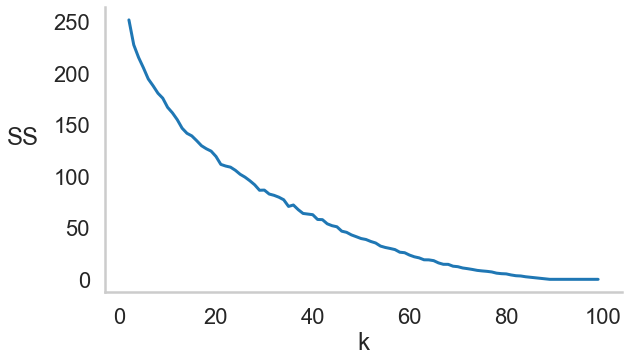

In [20]:
sns.lineplot(x=k_values2, y=ss_values2).spines[["right", "top"]].set_visible(False)
plt.grid(False)
plt.xlabel("k")
plt.ylabel("SS", labelpad=30).set_rotation(0)
plt.gcf().set_size_inches(9.25, 5.25)
plt.show()

In [21]:
print("still no clear elbow")

still no clear elbow


In [22]:
array = np.array
delta_ss = array(ss_values2[1:]) - array(ss_values2[:-1])

In [23]:
diff_df = pd.DataFrame(data={"k": k_values2[1:], "delta SS": delta_ss})

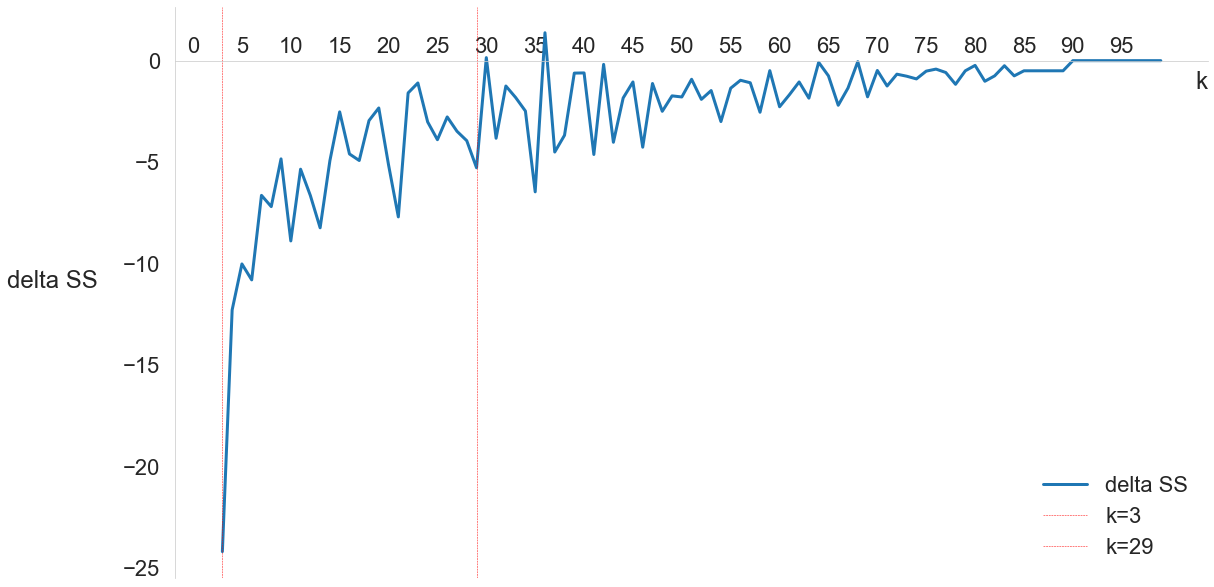

In [24]:
diff_df.plot(x="k", y="delta SS")

ax = plt.gca()
spines = ax.spines
plt.gcf().set_size_inches(18.5, 10.5)

spines[["right", "top"]].set_visible(False)
spines[["left", "bottom"]].set_linewidth(0.75)
spines.bottom.set_position("zero")

plt.axvline(x=3, color="red", linewidth=0.5, label="k=3", linestyle="dashed")
plt.axvline(x=29, color="red", linewidth=0.5, label="k=29", linestyle="dashed")

plt.grid(False)
plt.legend(frameon=False, loc="lower right")

plt.xticks(np.arange(0, 100, 5))
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_tick_params(length=0.1, width=0, pad=-50)

plt.xlabel("k", loc="right", labelpad=10)
plt.ylabel("delta SS", labelpad=70).set_rotation(0)

plt.show()

In [25]:
print("There is more of a visible elbow when examining the rate of change.")
print("The elbow point might roughly fall within 5 < k < 50.")
print()
print("SS was actually greater for k=30 than for k=29.")
print("That is, the k vs. SS plot from earlier is decreasing between for values of k in [2, 29].")
print("I'll choose 29 for the k value.")

There is more of a visible elbow when examining the rate of change.
The elbow point might roughly fall within 5 < k < 50.

SS was actually greater for k=30 than for k=29.
That is, the k vs. SS plot from earlier is decreasing between for values of k in [2, 29].
I'll choose 29 for the k value.


In [26]:
# Make a bar chart showing the number of points in each cluster for k-means under the best 𝐾.
points_in_clusters = pd.Series(
    KMeans(n_clusters=29, random_state=2021).fit_predict(data)
).value_counts()

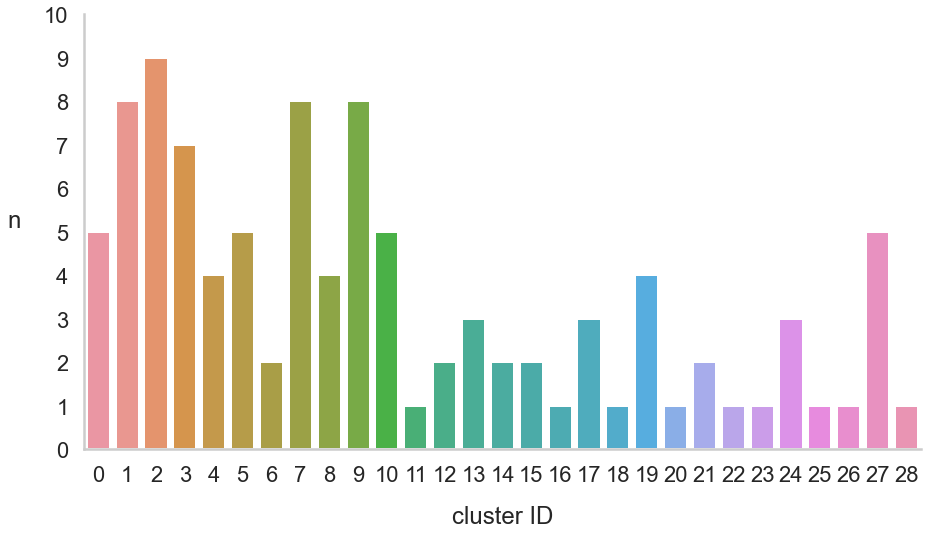

In [27]:
sns.barplot(x=points_in_clusters.index, y=points_in_clusters.values)
plt.gca().spines[["right", "top"]].set_visible(False)
plt.grid(False)
plt.yticks(np.arange(0, 11, 1))
plt.gcf().set_size_inches(15, 8)
plt.xlabel(xlabel="cluster ID", labelpad=20)
plt.ylabel("n", labelpad=30).set_rotation(0)
plt.show()

In [28]:
# What challenges did you experience using the Elbow method to pick 𝐾?
print("It was hard to find an intuitive elbow point.")
print("With 29 clusters, 9 clusters have only one data point, which is unsatisfying.")

It was hard to find an intuitive elbow point.
With 29 clusters, 9 clusters have only one data point, which is unsatisfying.


### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [29]:
# Your turn.
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score

[Skipped the cell's code and loaded variables X, silhouettes from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\X.pkl'.]


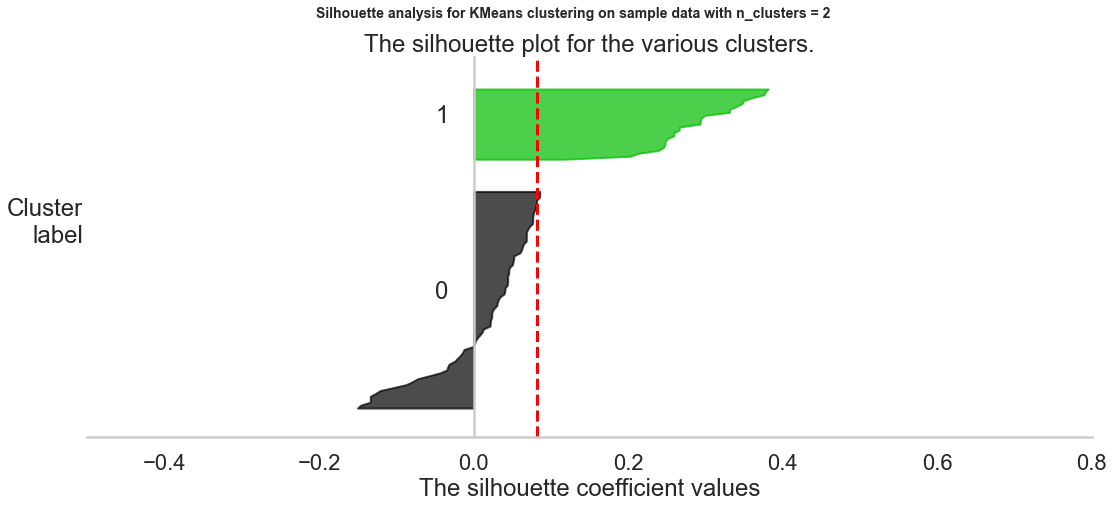

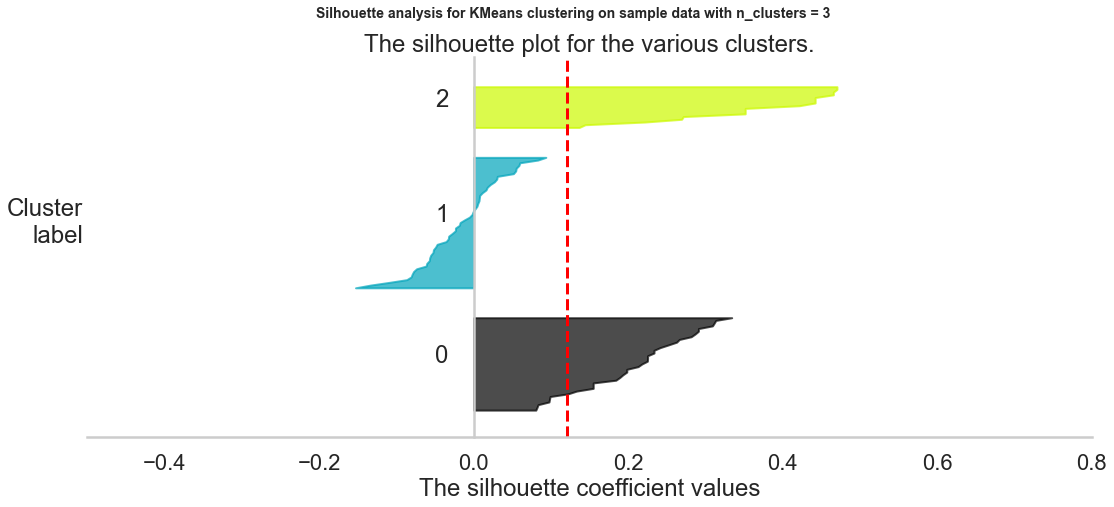

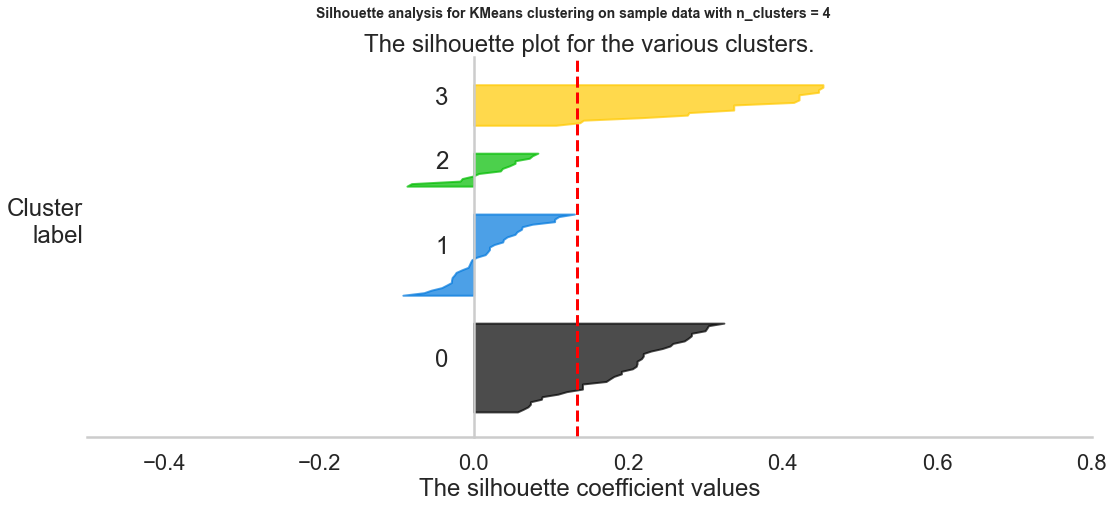

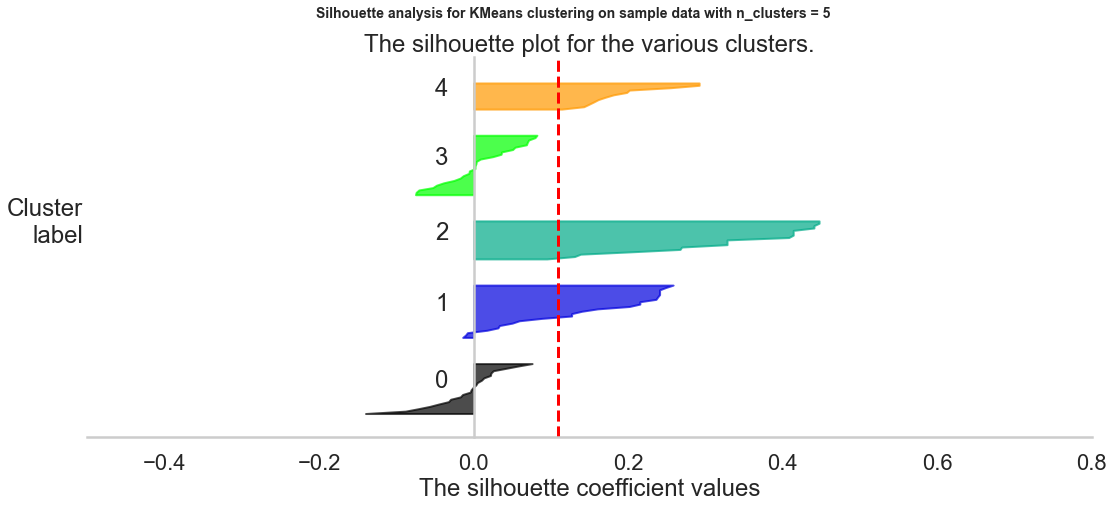

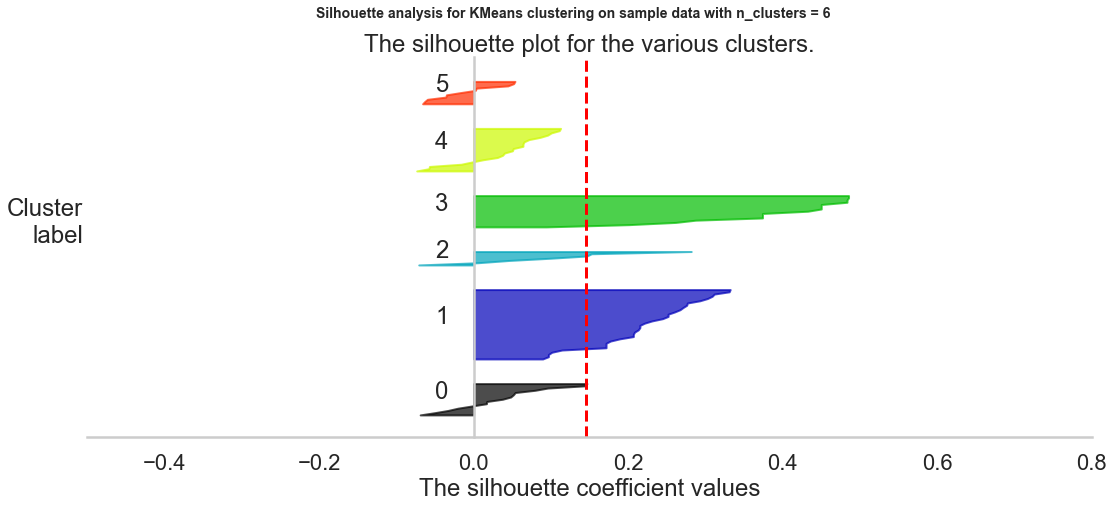

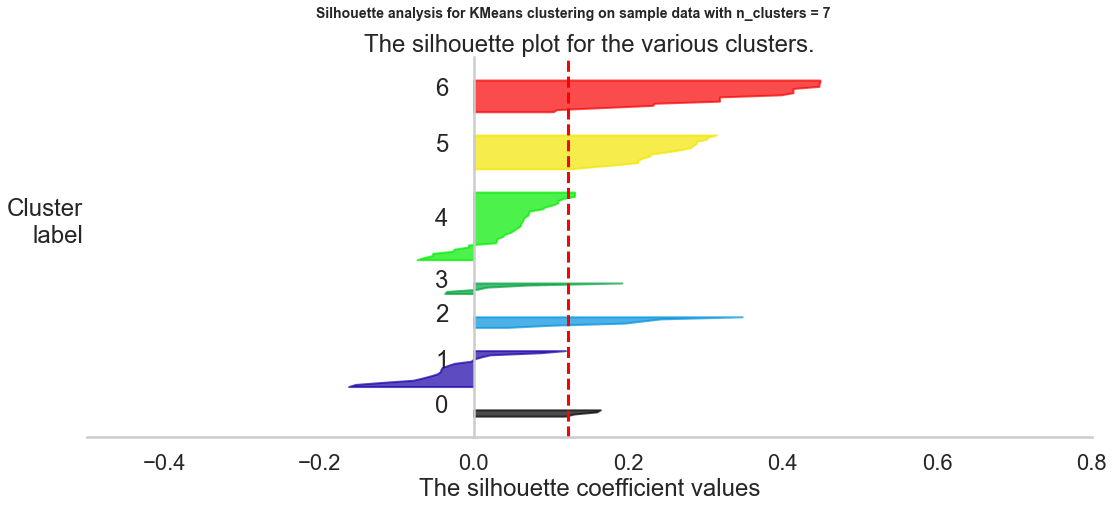

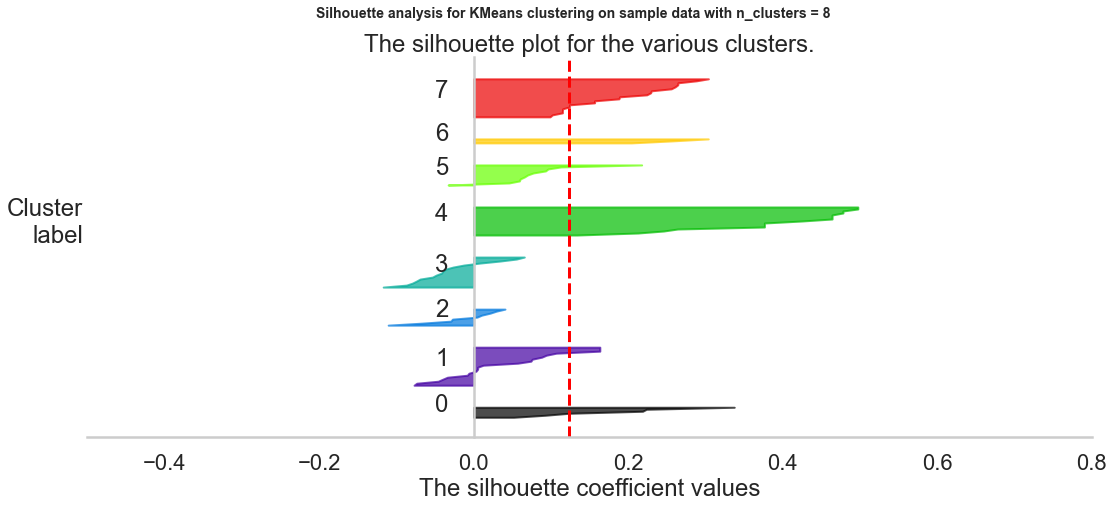

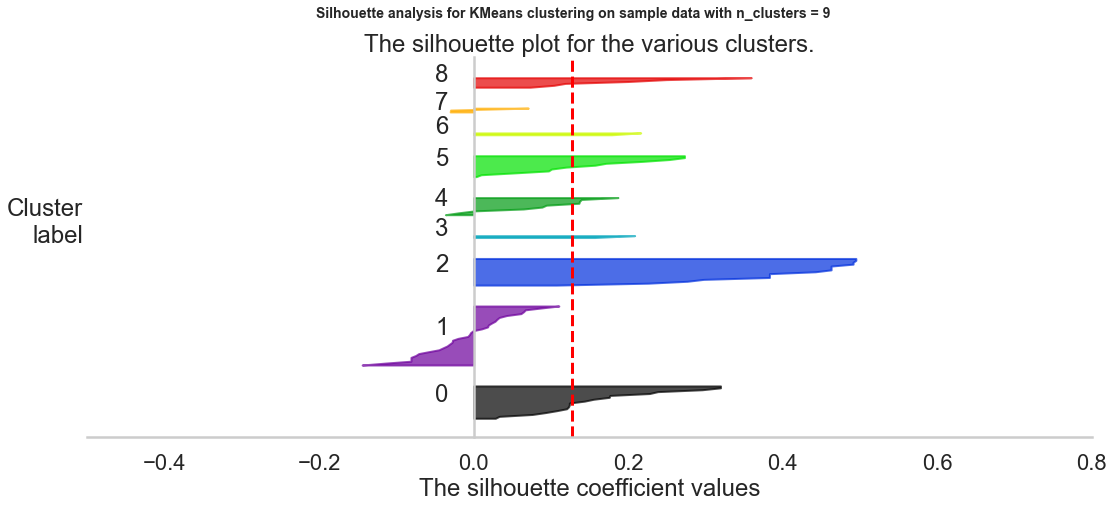

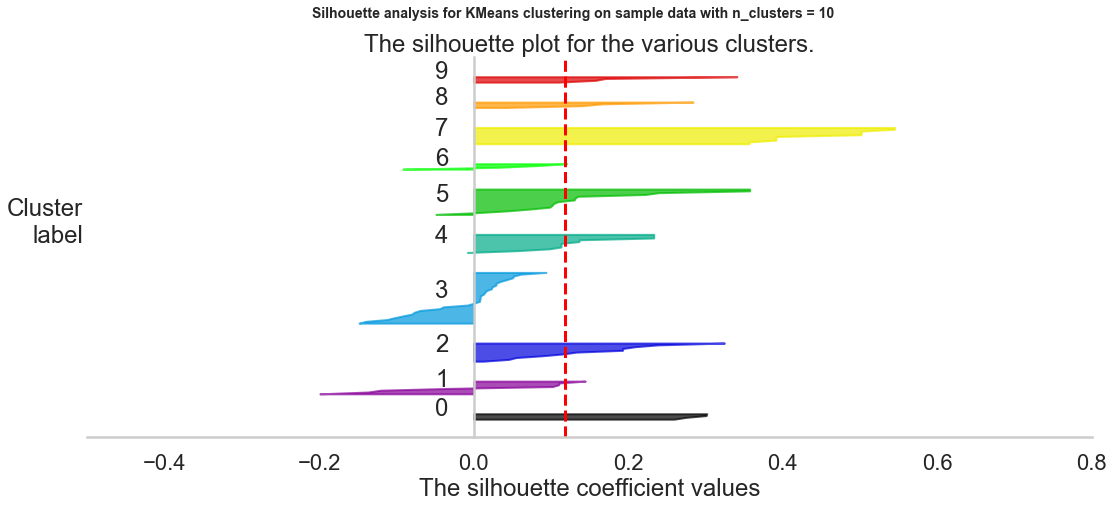

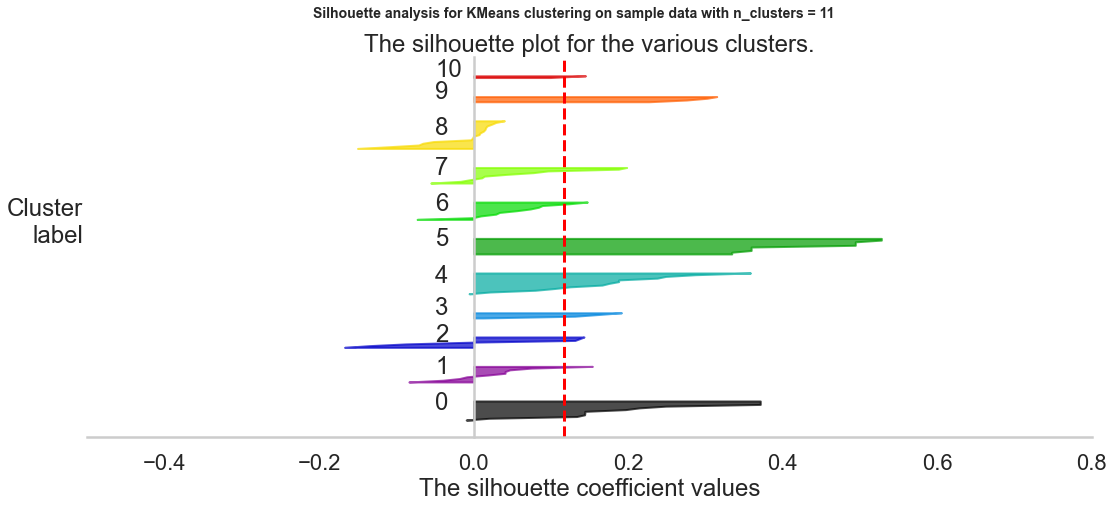

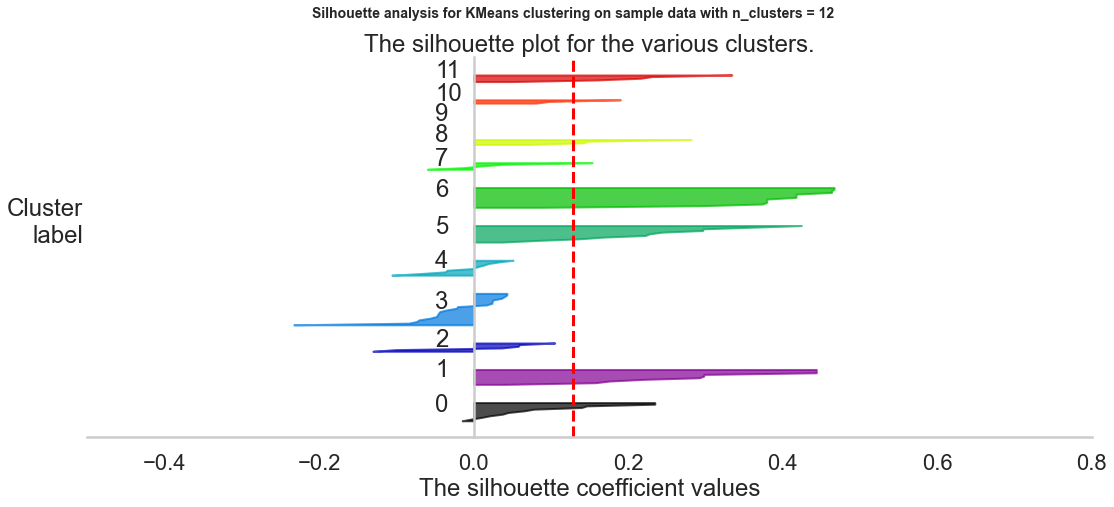

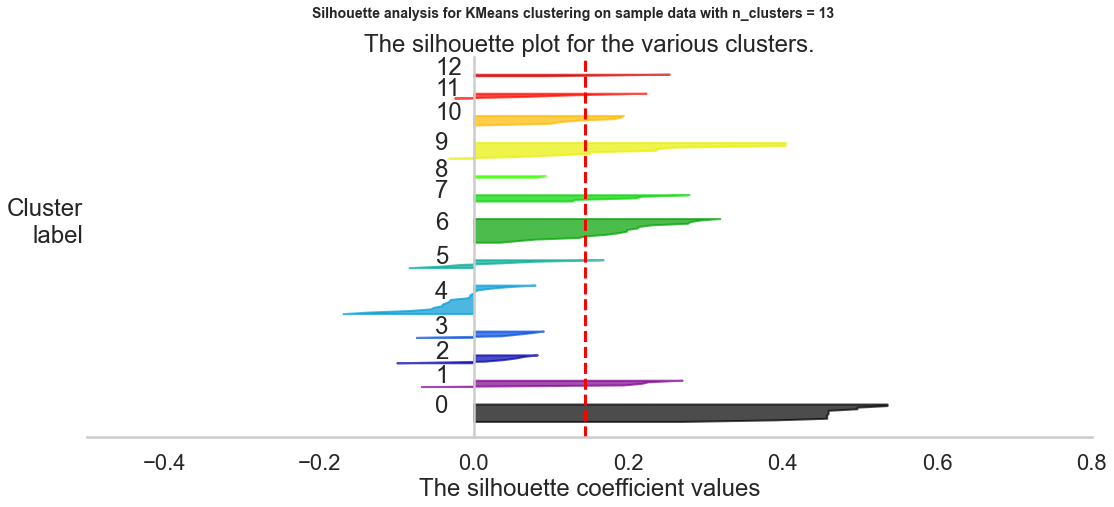

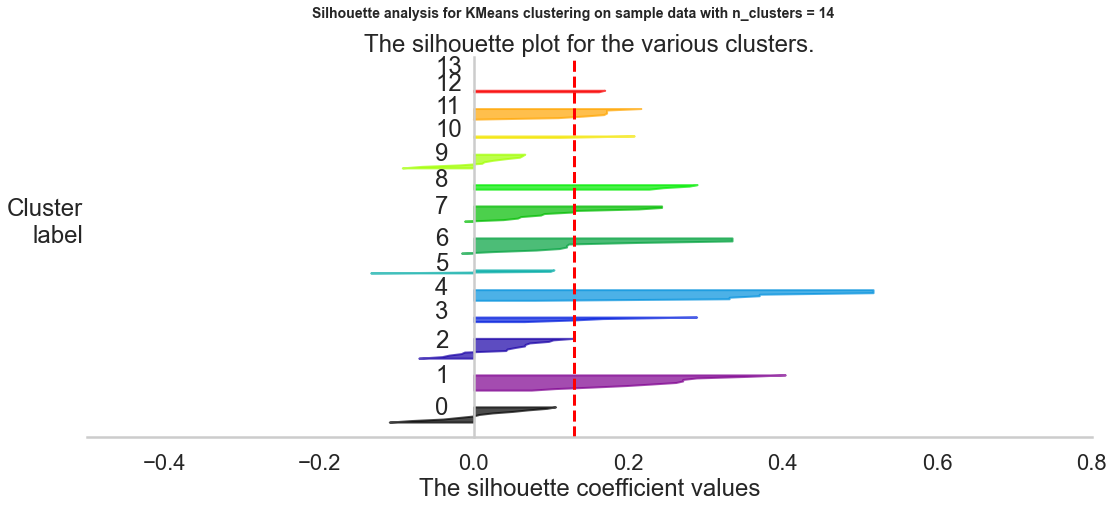

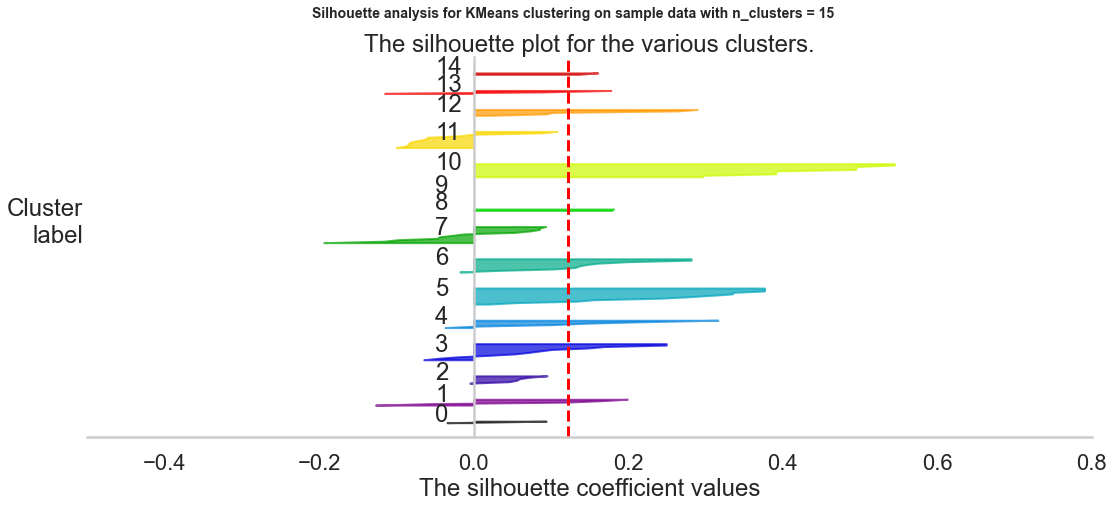

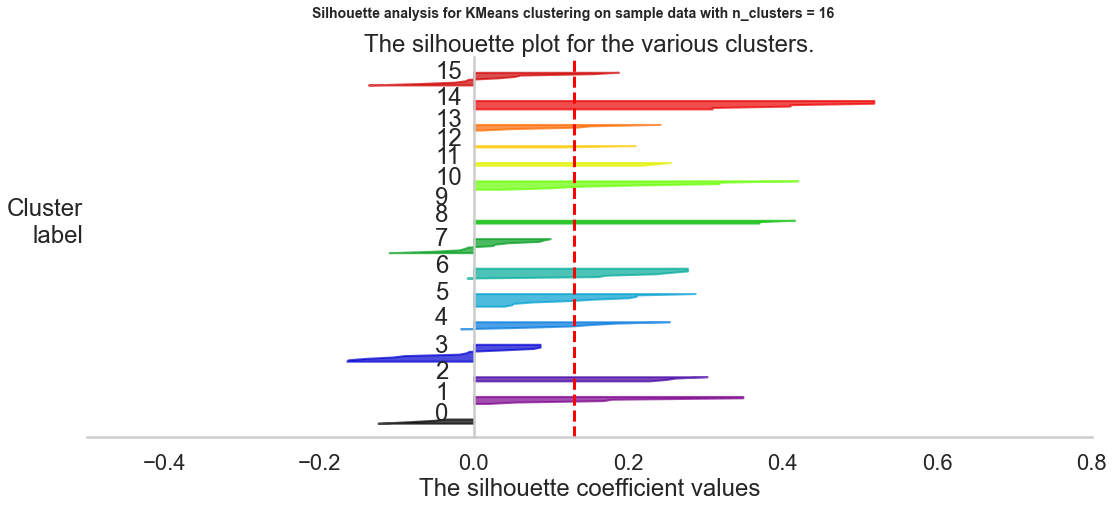

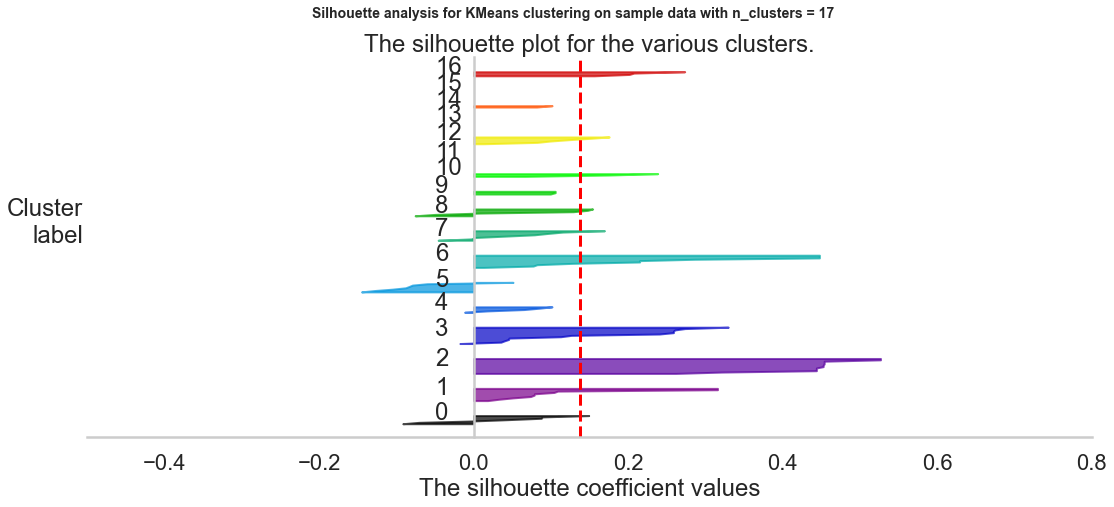

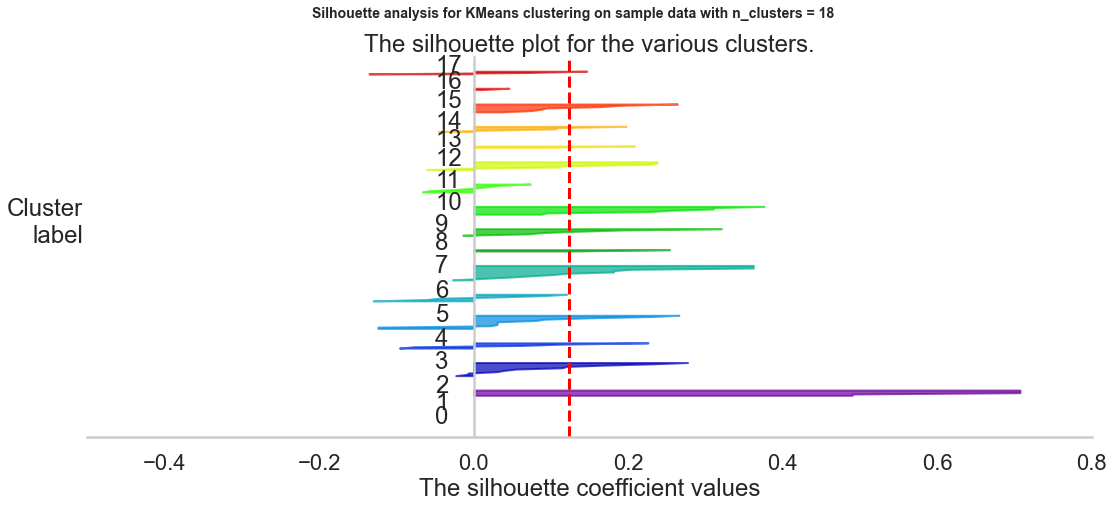

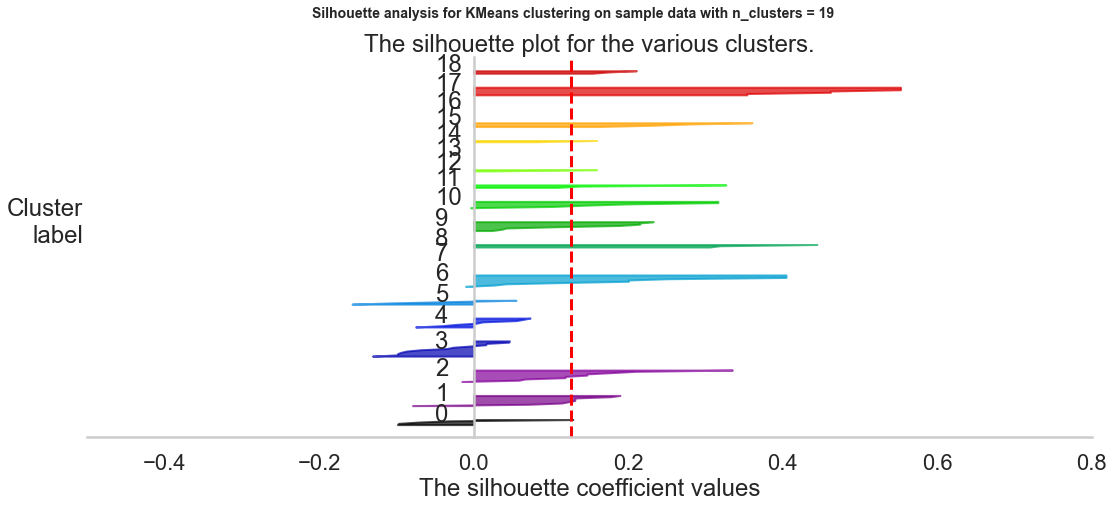

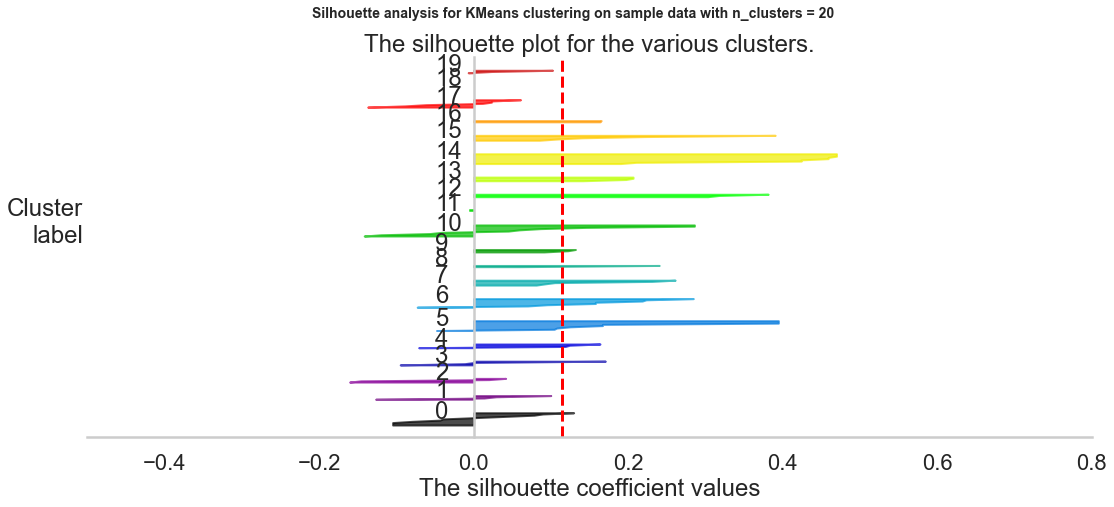

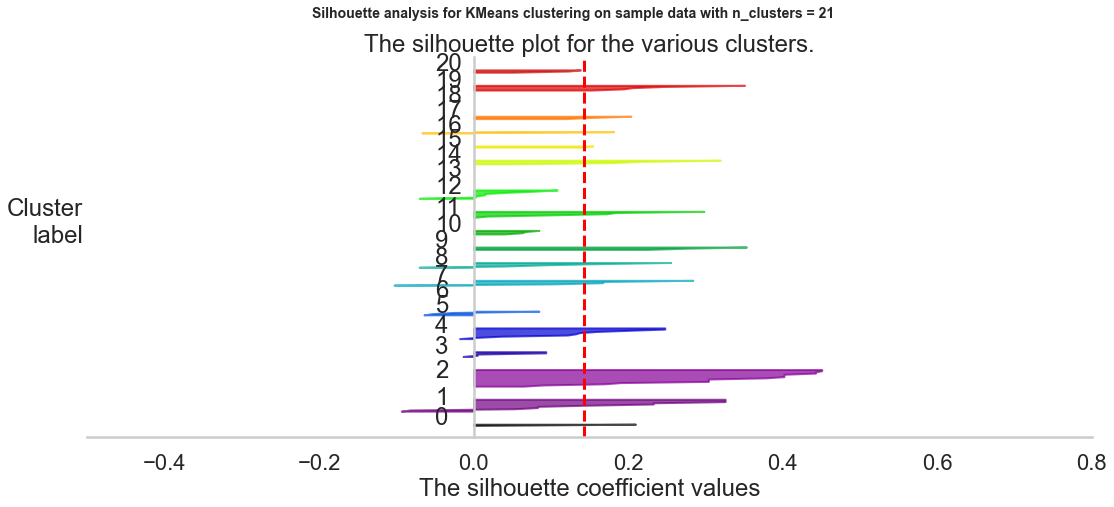

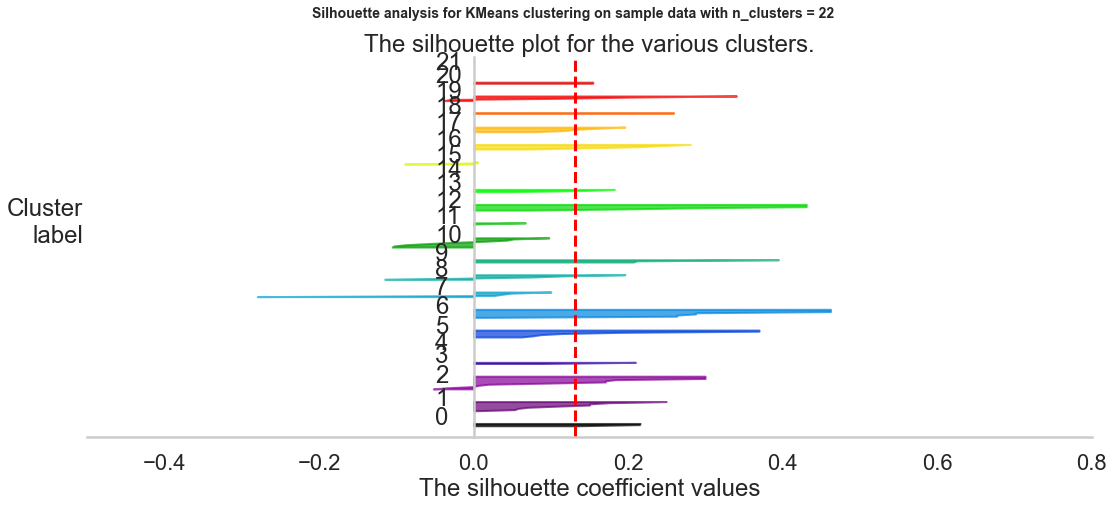

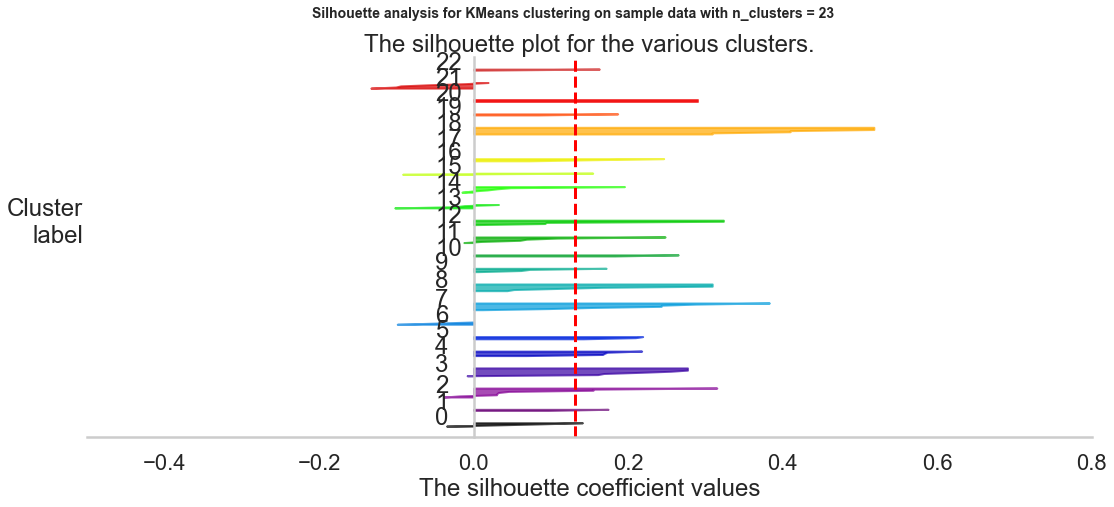

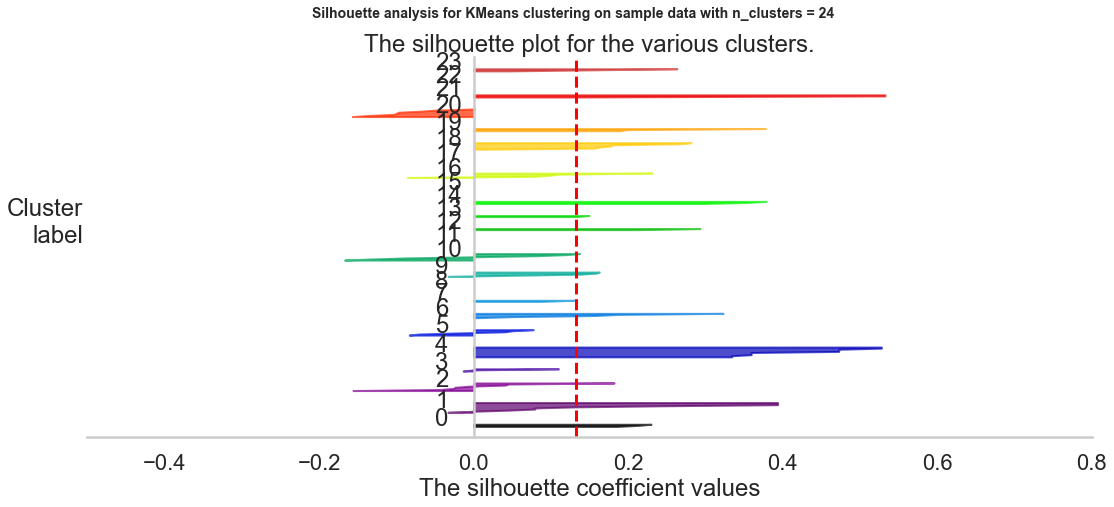

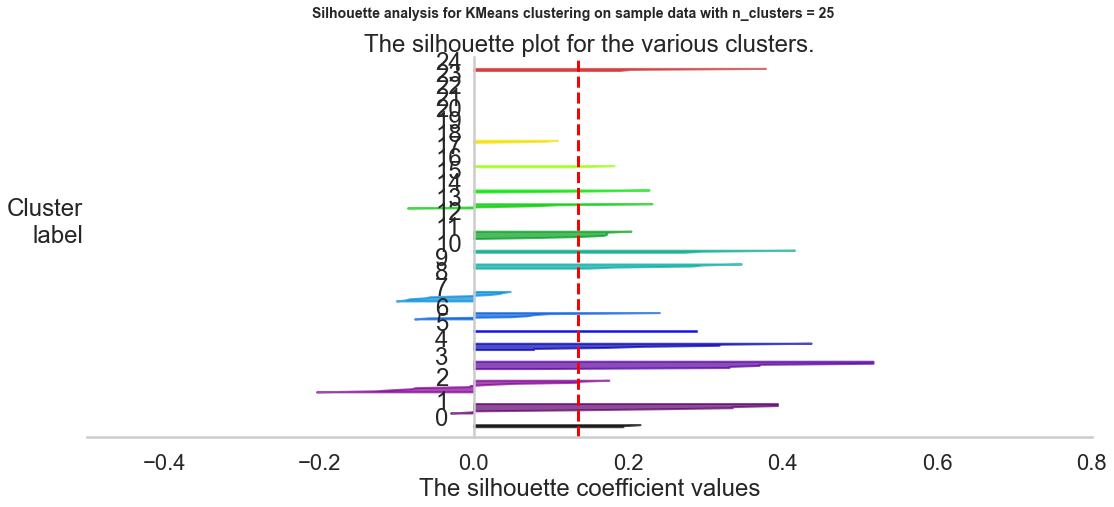

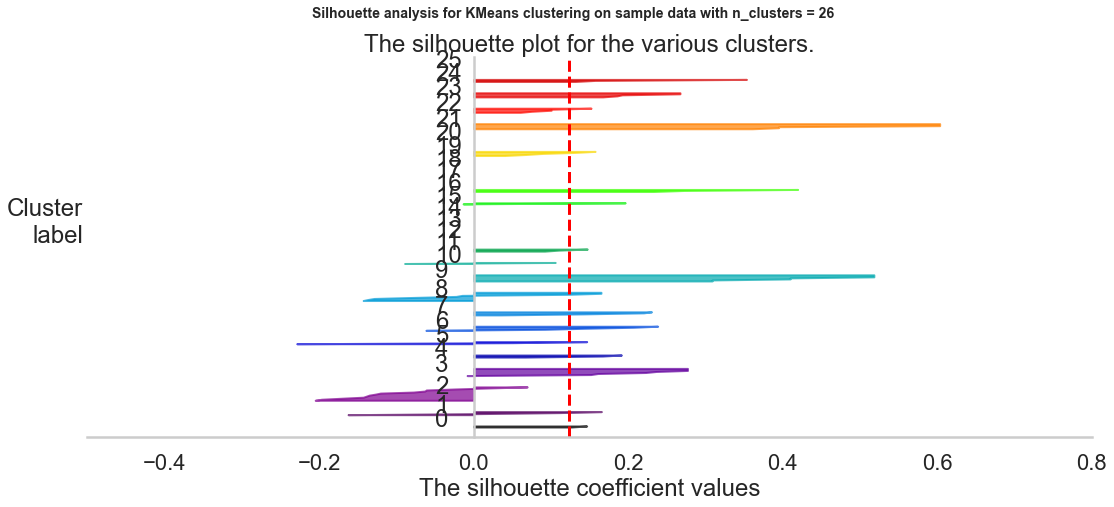

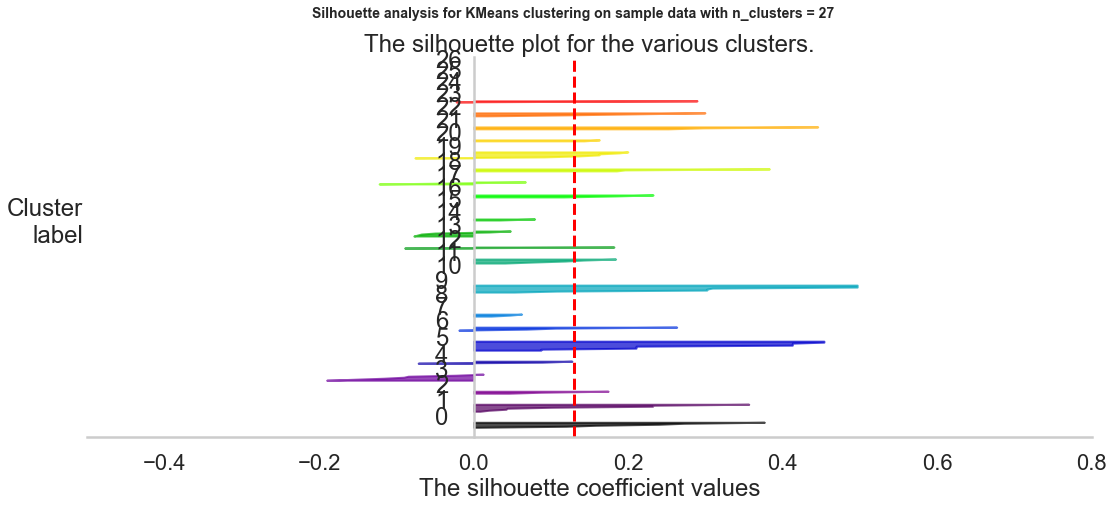

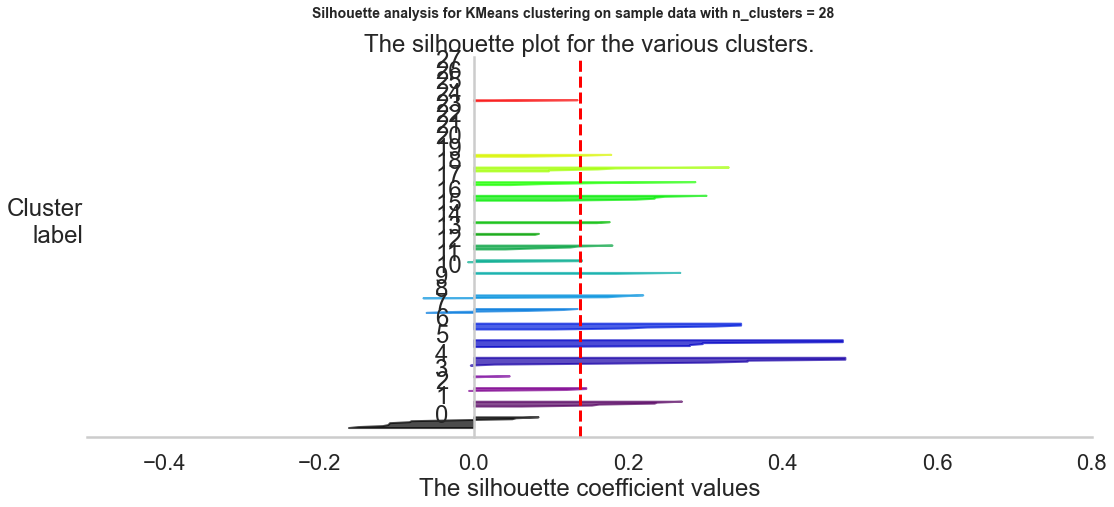

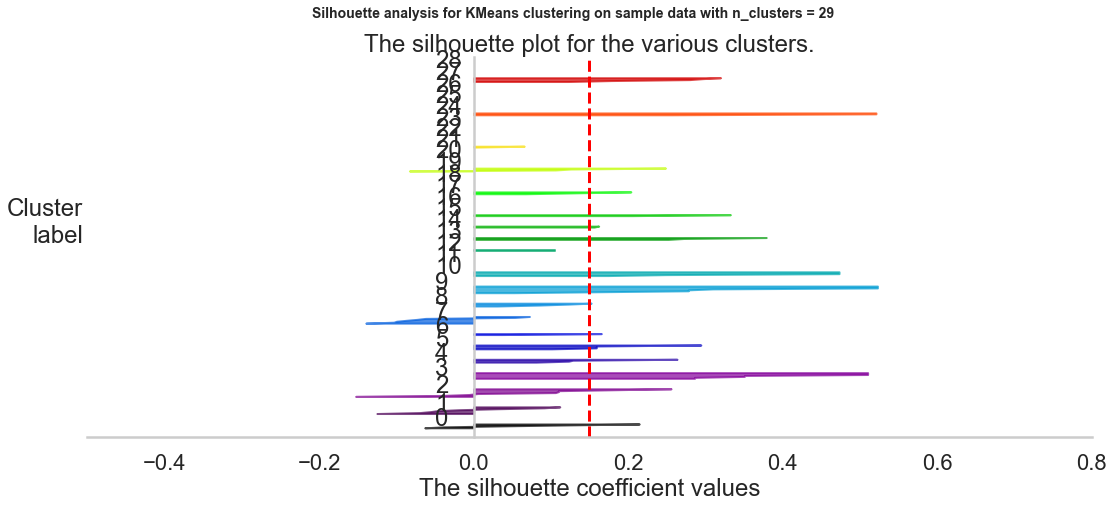

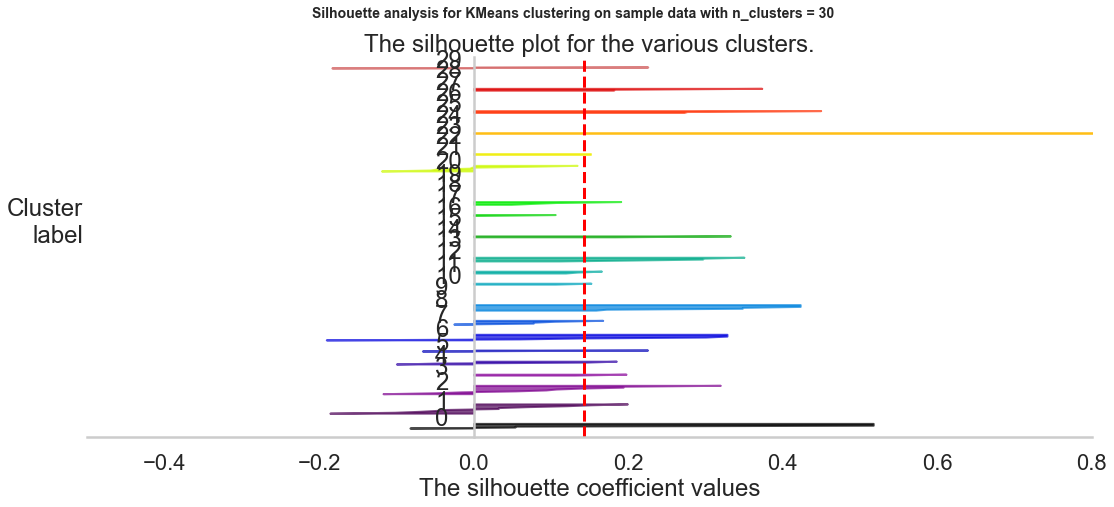

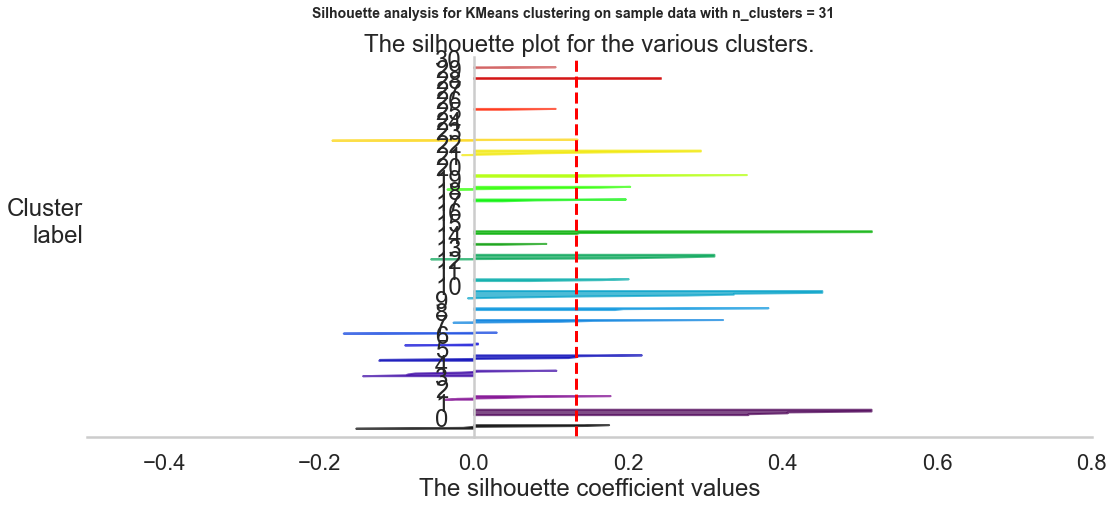

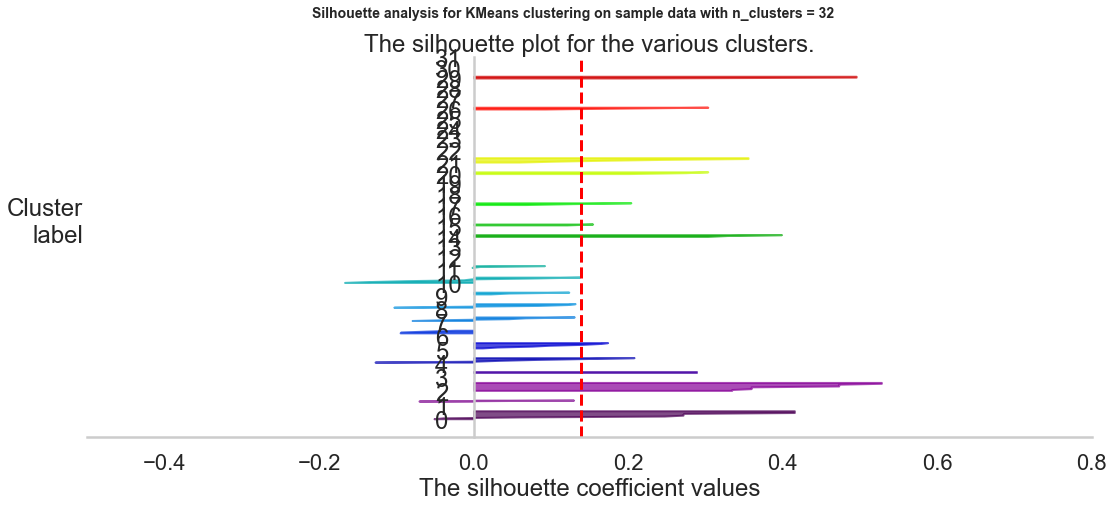

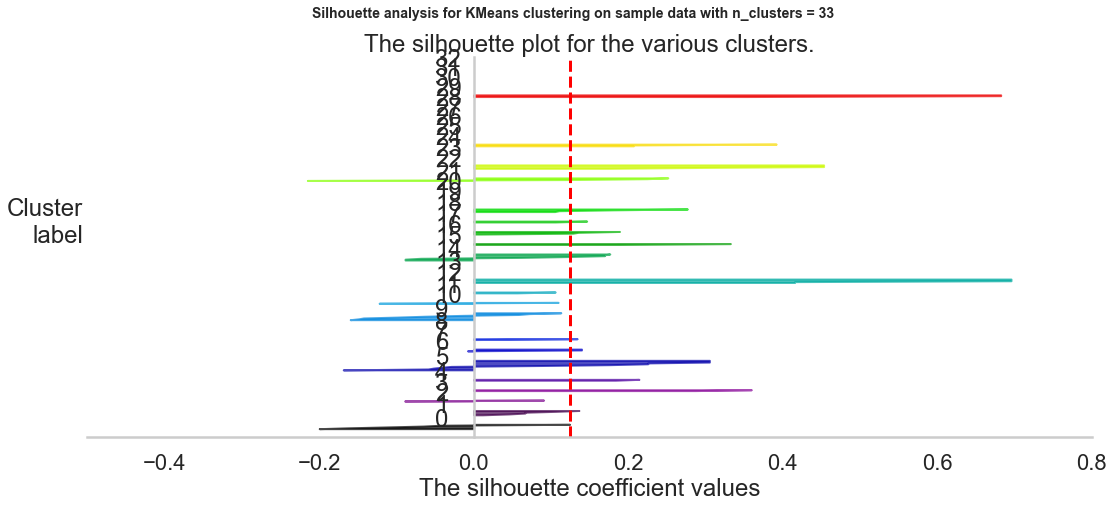

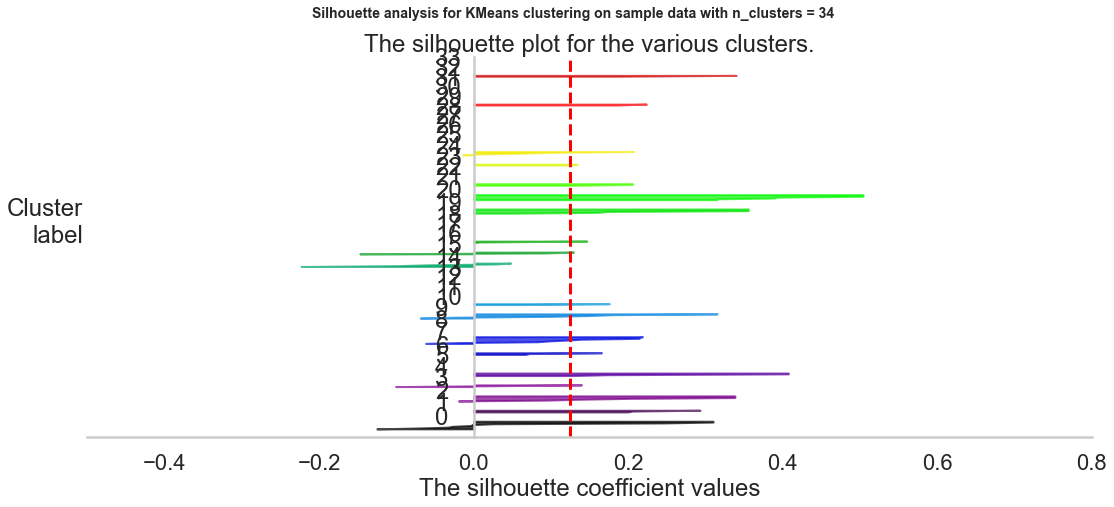

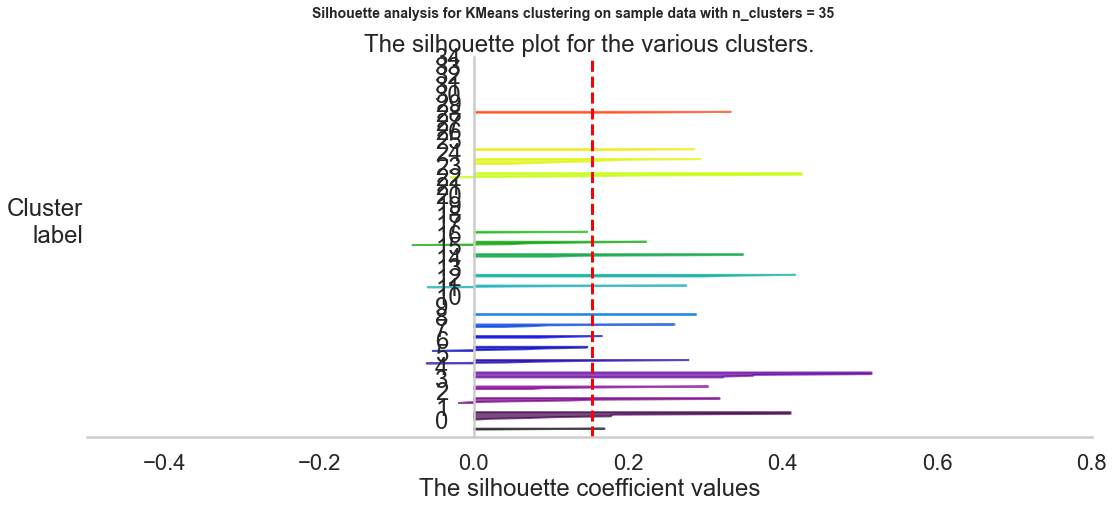

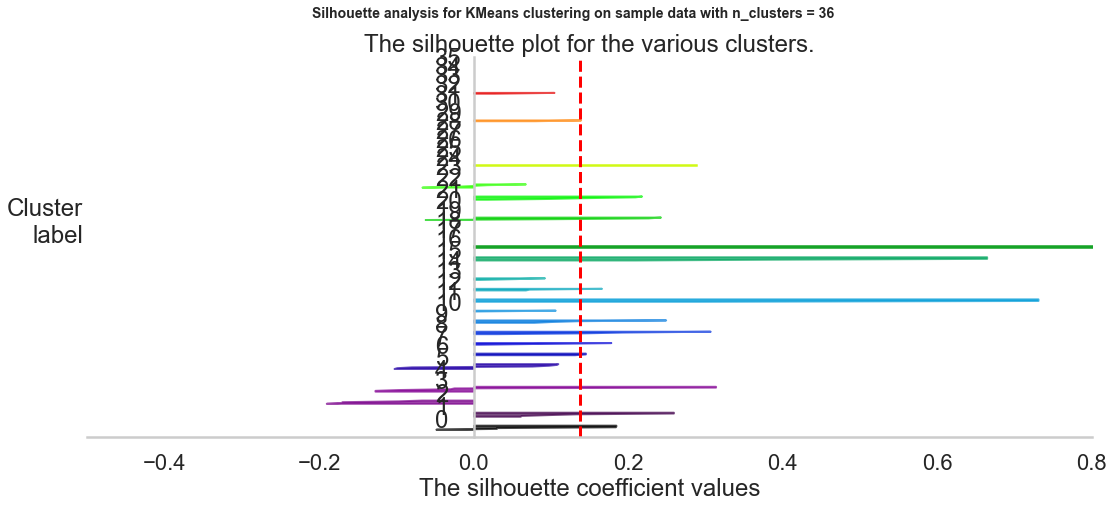

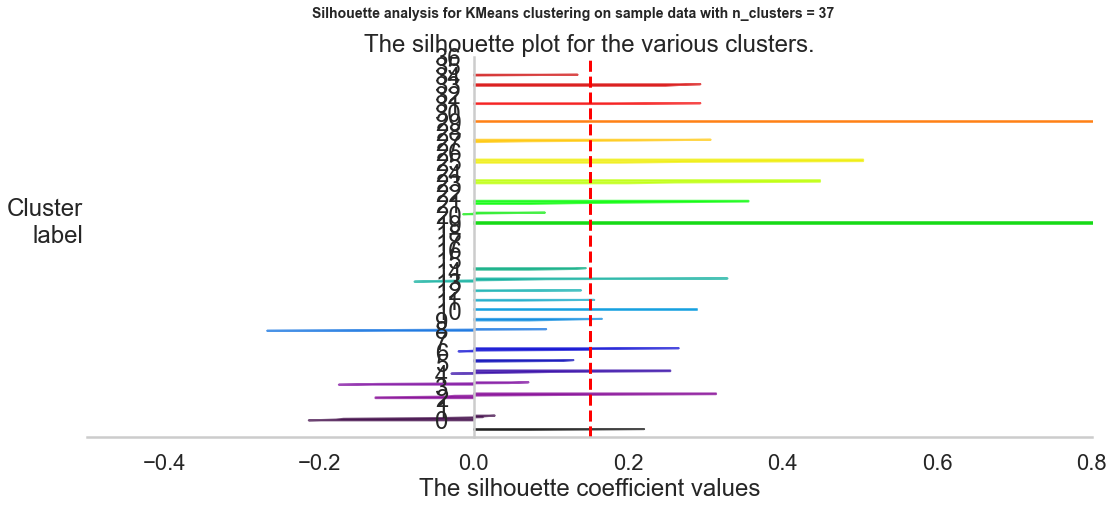

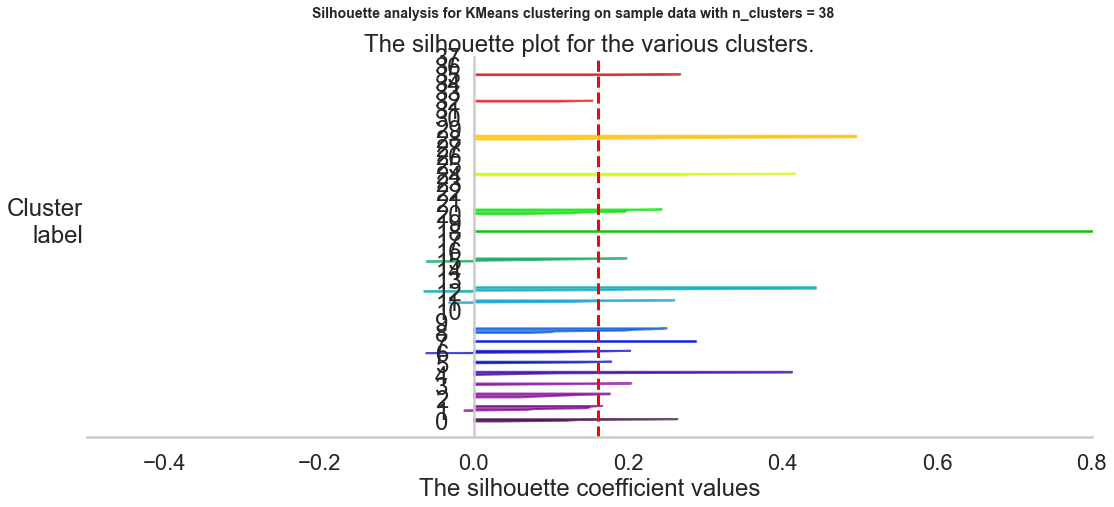

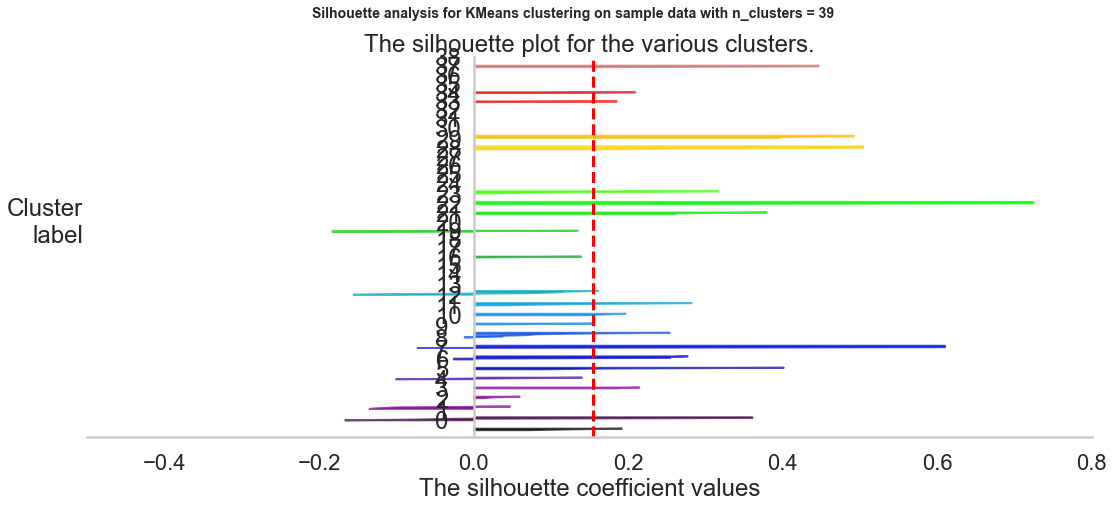

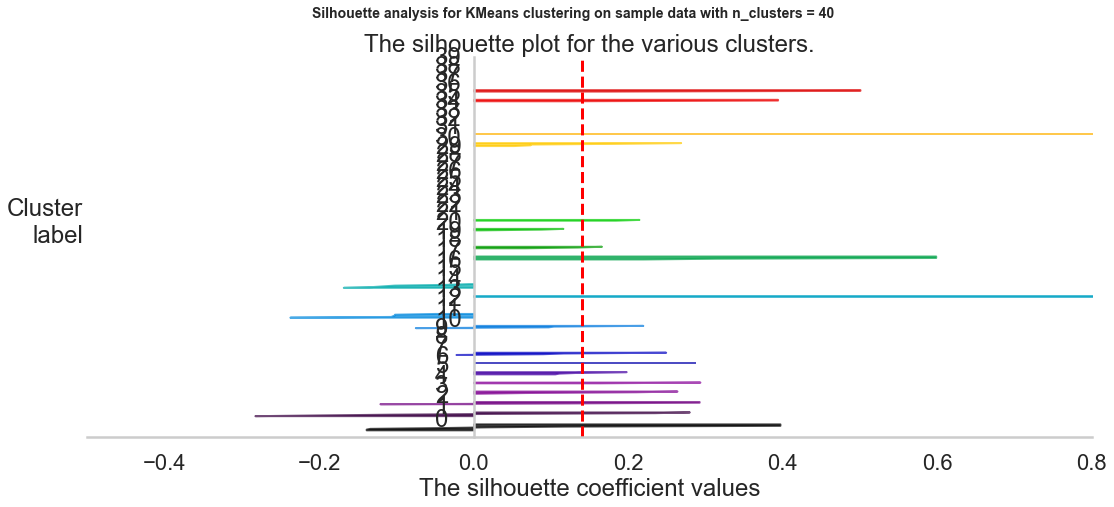

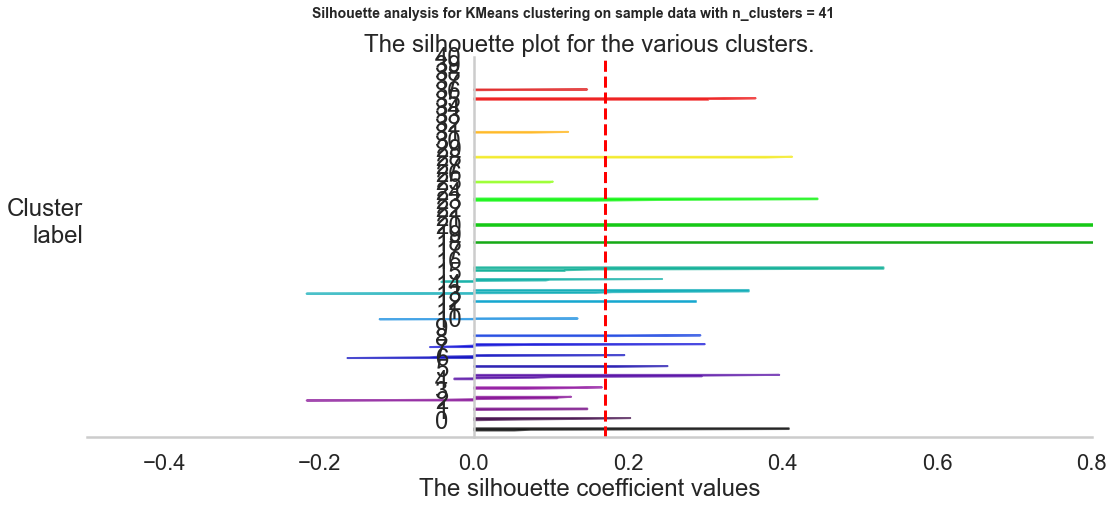

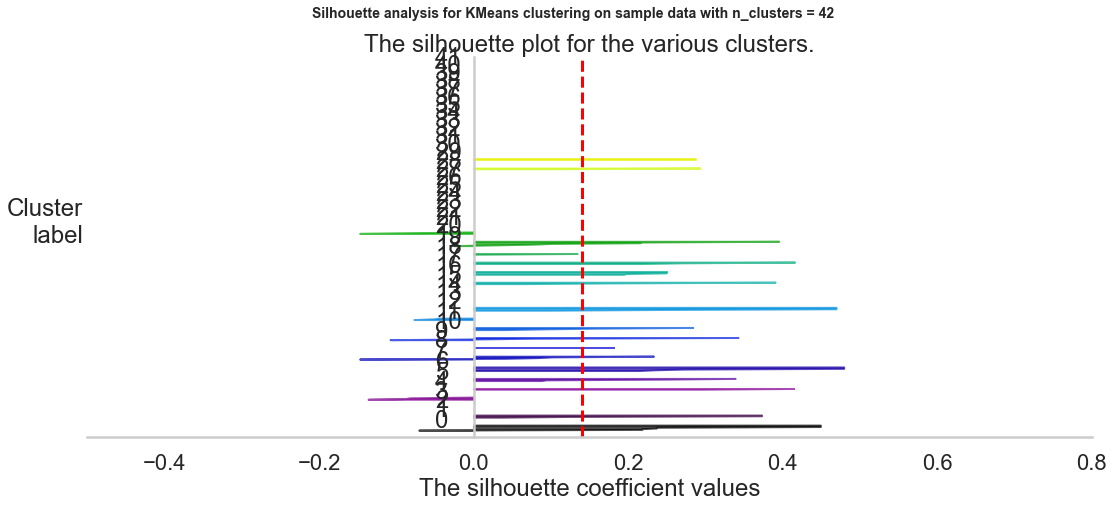

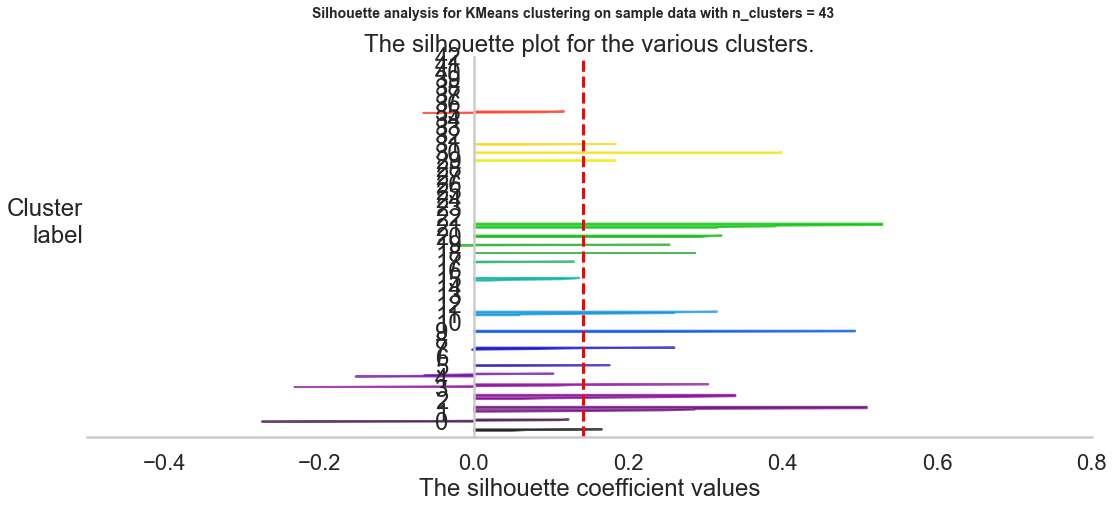

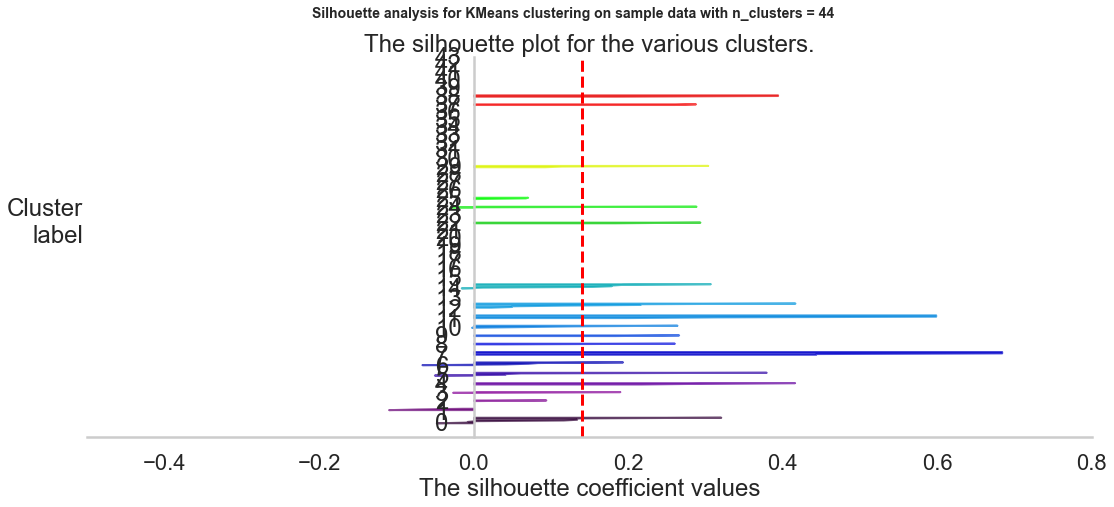

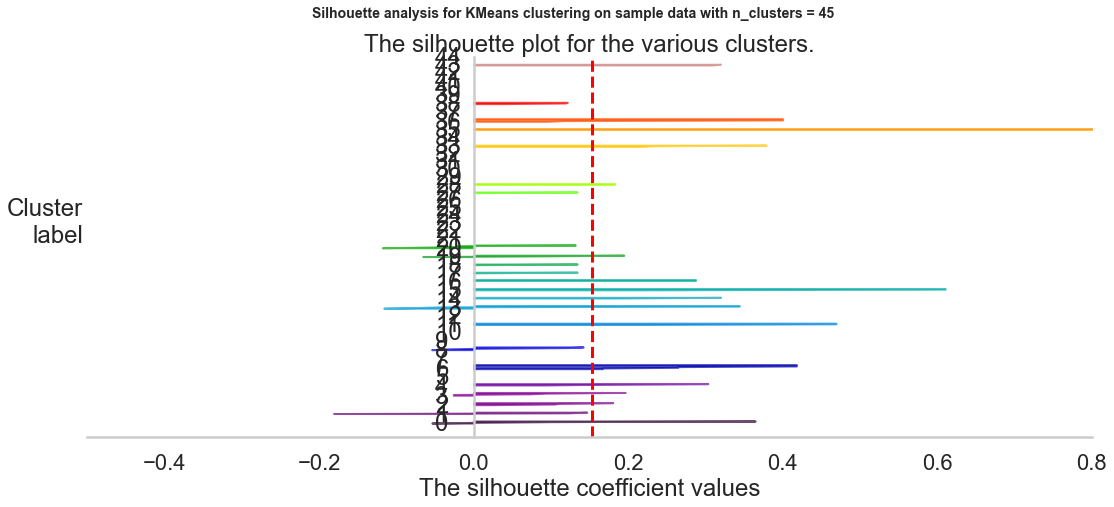

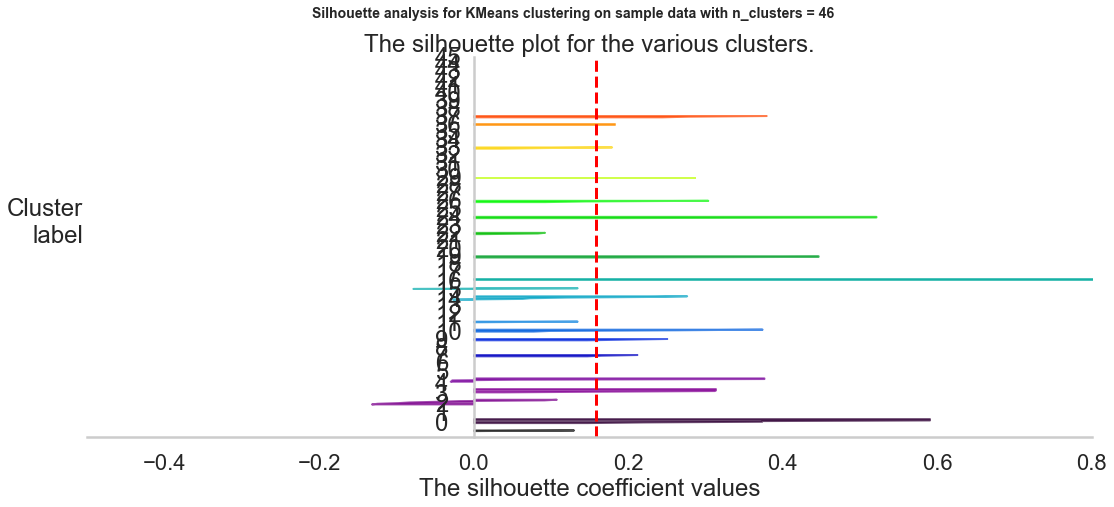

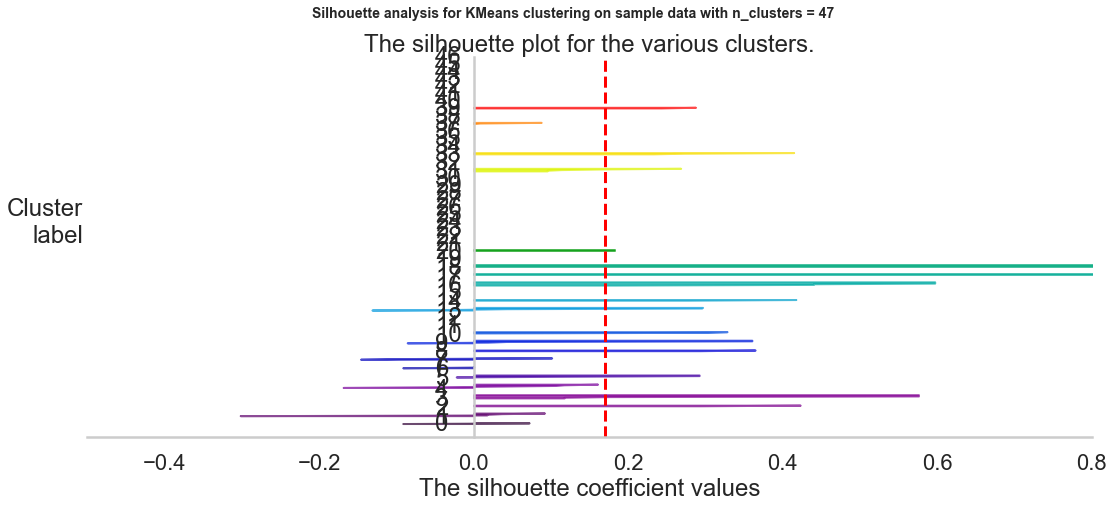

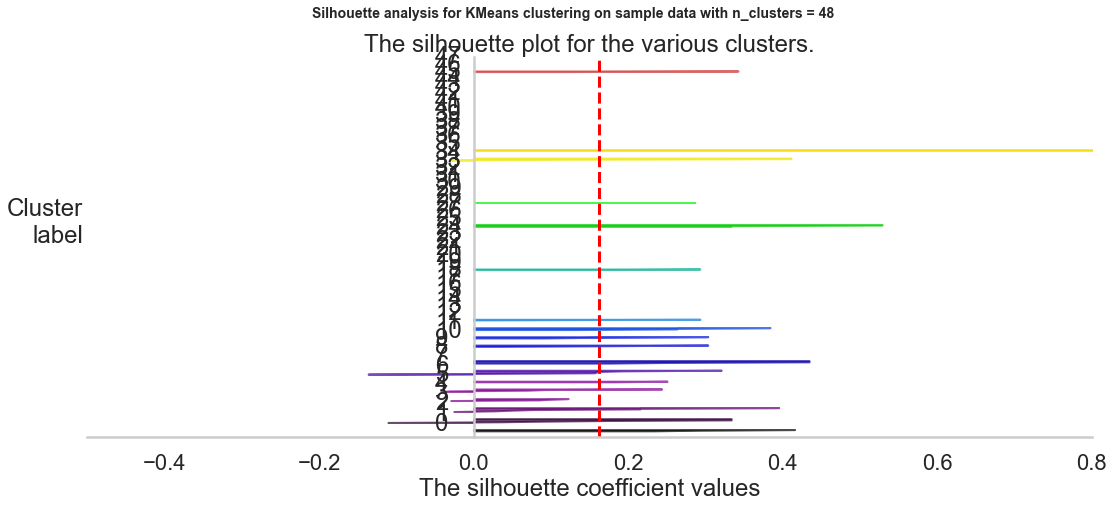

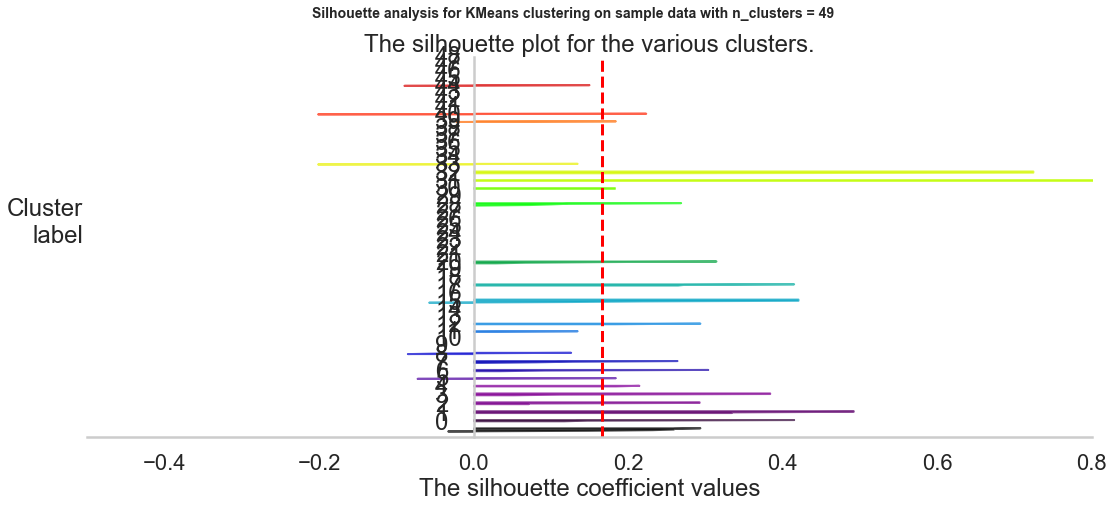

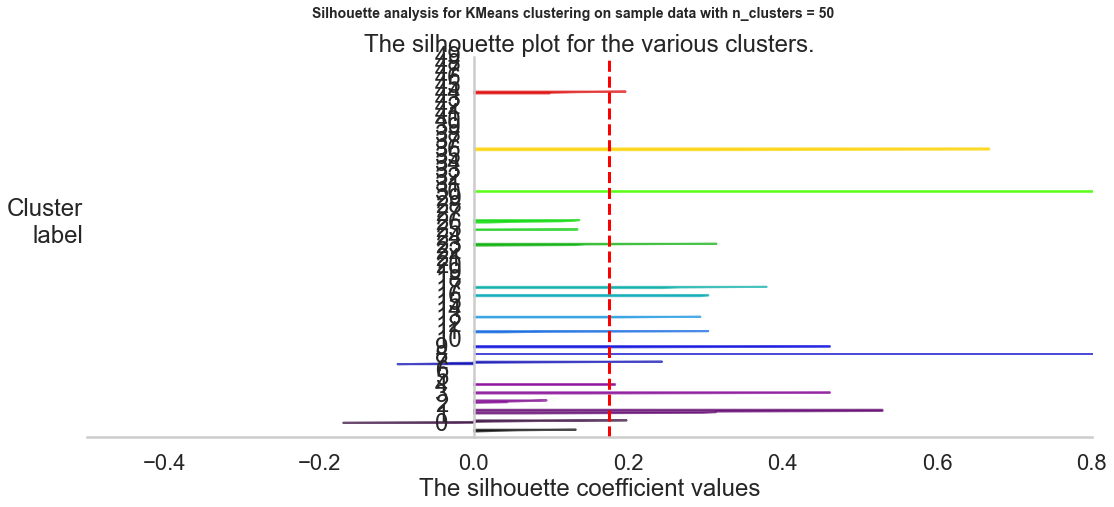

In [30]:
%%cache X.pkl X silhouettes
# Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.
X = data
silhouettes = {"n clusters": [], "avg. silhouette scores": []}
for n_clusters in range(2, 51):
    plt.gcf().set_size_inches(18, 7)
    ax = plt.gca()

    # The silhouette coefficient can range from -1 to 1
    ax.set_xlim([-0.5, 0.8])
    # (n_clusters+1)*10 inserts white space between silhouette plots of individual clusters
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value
    cluster_labels = KMeans(n_clusters=n_clusters, random_state=2021).fit_predict(X)

    # The silhouette_score gives the average value for all the samples
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Save scores
    silhouettes["n clusters"].append(n_clusters)
    silhouettes["avg. silhouette scores"].append(silhouette_avg)

    # Compute silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster\nlabel", horizontalalignment="right").set_rotation(0)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    plt.grid(False)
    ax.spines[["left", "top"]].set_visible(False)
    ax.spines.right.set_position("zero")

    plt.suptitle(
        (
            "Silhouette analysis for KMeans clustering on sample data "
            "with n_clusters = %d" % n_clusters
        ),
        fontsize=14,
        fontweight="bold",
    )
    plt.show()

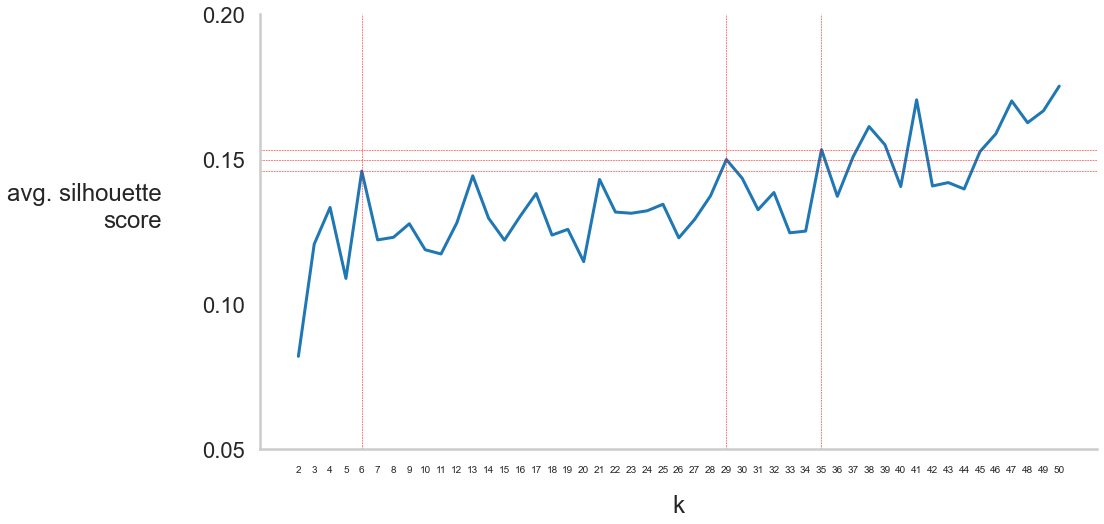

In [31]:
# Compute the average silhouette score for each 𝐾 and plot it.
sns.lineplot(x=silhouettes["n clusters"], y=silhouettes["avg. silhouette scores"])

plt.gcf().set_size_inches(15, 8)
plt.gca().spines[["right", "top"]].set_visible(False)
plt.grid(False)

make_vline = lambda x: plt.axvline(x=x, color="red", linewidth=0.5, linestyle="dashed")
make_hline = lambda y: plt.axhline(y=y, color="red", linewidth=0.5, linestyle="dashed")

make_vline(6)
make_hline(0.1459647452174209)
make_vline(29)
make_hline(0.14995433734615637)
make_vline(35)
make_hline(0.15337367806538607)

plt.xticks(
    np.arange(min(silhouettes["n clusters"]), max(silhouettes["n clusters"]) + 1, 1),
    fontsize=10,
)
plt.xlabel(xlabel="k", labelpad=20)

plt.yticks(np.arange(0.05, 0.25, 0.05))
plt.ylabel(
    "avg. silhouette\nscore", labelpad=40, horizontalalignment="right"
).set_rotation(0)

plt.show()

In [32]:
for i in range(len(silhouettes["n clusters"])):
    print(
        "For n_clusters = {}, the average silhouette score is {}".format(
            silhouettes["n clusters"][i], silhouettes["avg. silhouette scores"][i]
        )
    )

For n_clusters = 2, the average silhouette score is 0.08206113079944462
For n_clusters = 3, the average silhouette score is 0.12078917343046144
For n_clusters = 4, the average silhouette score is 0.1334176890615069
For n_clusters = 5, the average silhouette score is 0.10893999025084683
For n_clusters = 6, the average silhouette score is 0.1459647452174209
For n_clusters = 7, the average silhouette score is 0.12222148712749537
For n_clusters = 8, the average silhouette score is 0.12312675061883221
For n_clusters = 9, the average silhouette score is 0.12779979286560453
For n_clusters = 10, the average silhouette score is 0.11883282384155641
For n_clusters = 11, the average silhouette score is 0.11737315232127818
For n_clusters = 12, the average silhouette score is 0.12814664809311715
For n_clusters = 13, the average silhouette score is 0.14432907951152918
For n_clusters = 14, the average silhouette score is 0.12970621470846727
For n_clusters = 15, the average silhouette score is 0.122128

In [33]:
# What 𝐾 does the plot suggest we should choose?
print("The average silhouette score at k=6 is not beaten until k=29.")
print("The average silhouette score at k=29 is not beaten until k=35.")

The average silhouette score at k=6 is not beaten until k=29.
The average silhouette score at k=29 is not beaten until k=35.


In [34]:
# Does it differ from what we found using the Elbow method?
print("I could choose k=29 because it was also a value of interest for k revealed by the Elbow method.")
print("However, all these scores indicate weak clustering structures.")
print("Any increase in silhouette score we can obtain by varying k is marginal.")
print("I prefer to have few (or no) clusters with only 1 sample.")
print("Therefore, I would choose k=6.")

I could choose k=29 because it was also a value of interest for k revealed by the Elbow method.
However, all these scores indicate weak clustering structures.
Any increase in silhouette score we can obtain by varying k is marginal.
I prefer to have few (or no) clusters with only 1 sample.
Therefore, I would choose k=6.


### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [35]:
# your turn
from sklearn.decomposition import PCA

In [36]:
# Use scikit-learn's `PCA` function to reduce the dimensionality of your clustering data to 2 components
pca = PCA(n_components=2, random_state=2021).fit_transform(data)

In [37]:
# Create a data frame with the following fields:
## customer name
## cluster id the customer belongs to
## the two PCA components (label them `x` and `y`)

pca_df = matrix.copy()
pca_df["x"] = pca[:, 0]
pca_df["y"] = pca[:, 1]
pca_df["cluster id"] = KMeans(n_clusters=2, random_state=2021).fit_predict(
    pca_df[["x", "y"]]
)
pca_df

new_id customer_name  1  2  3  4  5  6  7  8  9  ...  26  27  28  29  30  31  \
0              Adams  0  0  0  0  0  0  0  0  0  ...   0   0   0   1   1   0   
1              Allen  0  0  0  0  0  0  0  0  1  ...   0   1   0   0   0   0   
2           Anderson  0  0  0  0  0  0  0  0  0  ...   1   0   0   0   0   0   
3             Bailey  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   1   0   
4              Baker  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   0   1   
..               ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..   
95          Williams  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   1   
96            Wilson  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   1   0   
97              Wood  1  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   1   
98            Wright  0  0  0  1  0  1  0  0  0  ...   0   1   0   0   0   0   
99             Young  0  0  0  0  0  1  0  0  1  ...   0   0   0   0   0   1   

new_id  32         x         y  cluster id  
0        0  1.007580  0.108215           0  
1        0 -0.287539  0.044715           1  
2        0 -0.392032  1.038391           1  
3        0  0.699477 -0.022542           0  
4        0  0.088183 -0.471695           1  
..      ..       ...       ...         ...  
95       0 -0.151666 -0.587844           1  
96       0  0.688224 -0.013688           0  
97       0 -0.551215 -0.395670           1  
98       0 -0.489805 -0.383307           1  
99       1 -0.881994 -1.041788           1  

[100 rows x 36 columns]

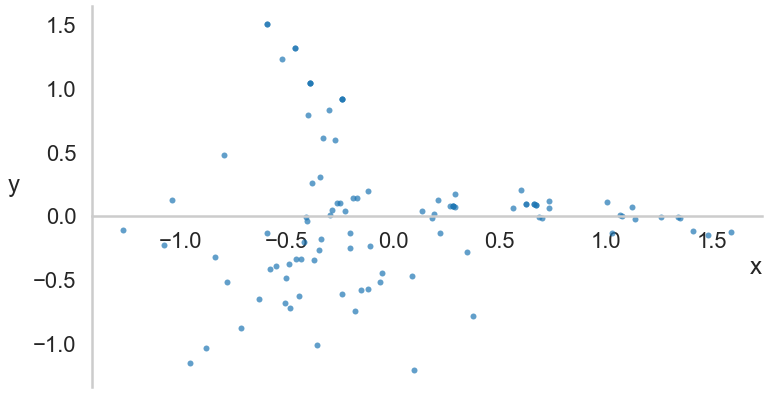

In [38]:
# Plot a scatterplot of the `x` vs `y` columns
sns.scatterplot(x=pca_df.x, y=pca_df.y, marker=".", alpha=0.7, linewidth=0)
plt.gcf().set_size_inches(12, 7)
ax = plt.gca()
ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
spines[["left", "bottom"]].set_linewidth(0.3)
plt.grid(False)
plt.ylabel("y", labelpad=20).set_rotation(0)
ax.set_xlabel("x", loc="right")
plt.show()

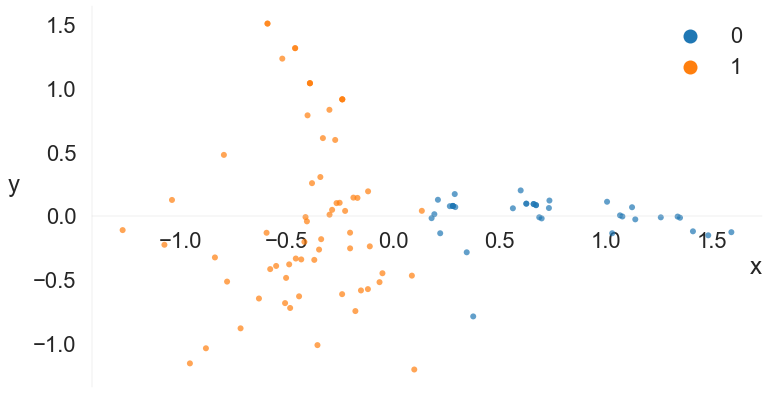

In [39]:
# Color-code points differently based on cluster ID
sns.scatterplot(
    x=pca_df.x, y=pca_df.y, hue=pca_df["cluster id"], marker=".", alpha=0.7, linewidth=0
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(frameon=False)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("y", labelpad=20).set_rotation(0)
ax.set_xlabel("x", loc="right")

plt.show()

In [40]:
# How do the cluters look?
print("It looks like a vertical line would separate the two clusters well.")

It looks like a vertical line would separate the two clusters well.


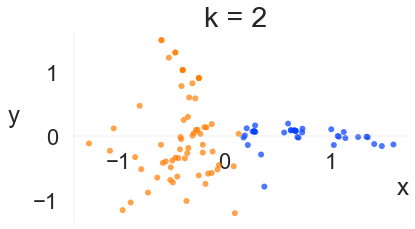

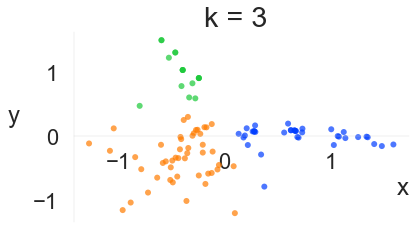

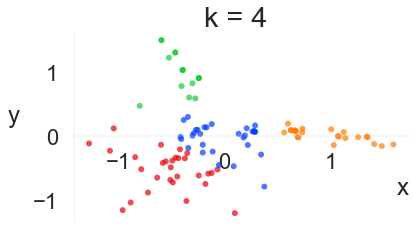

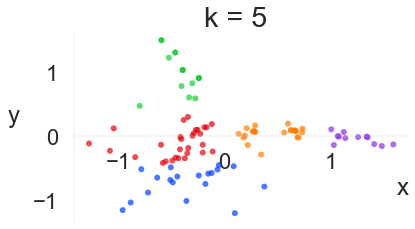

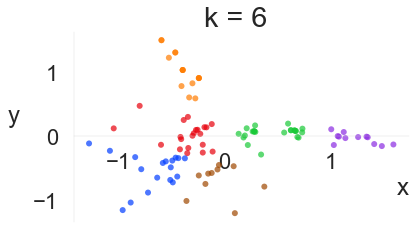

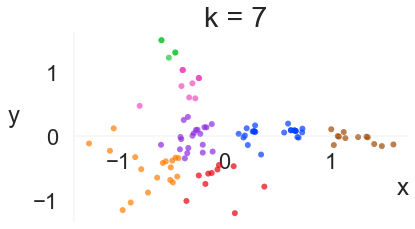

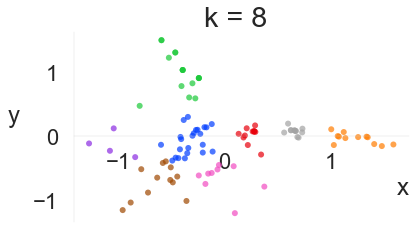

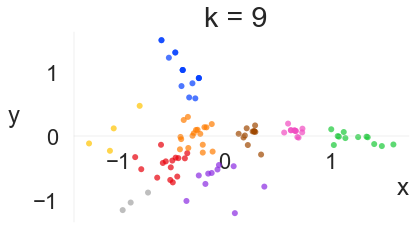

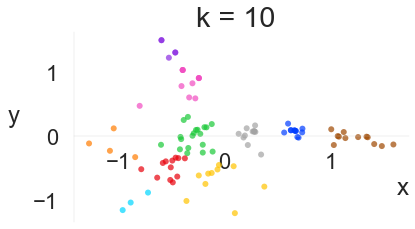

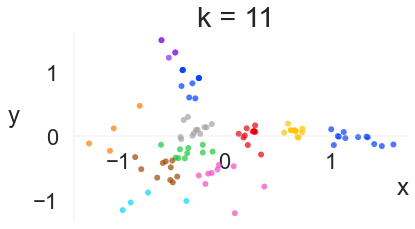

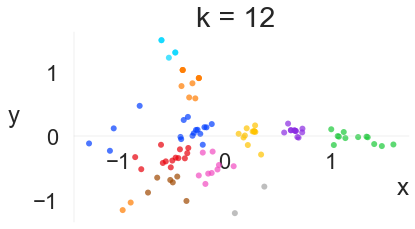

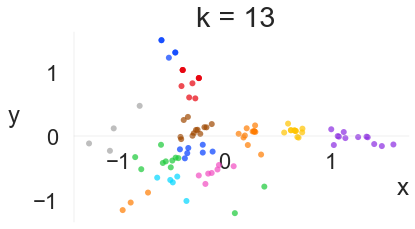

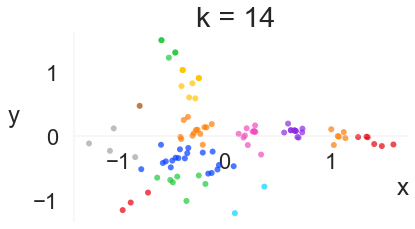

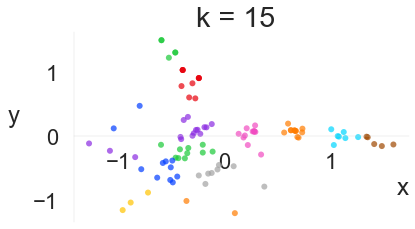

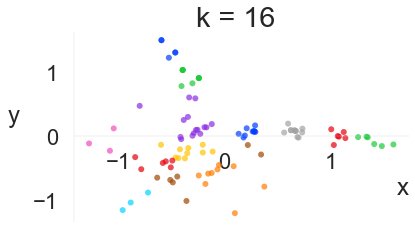

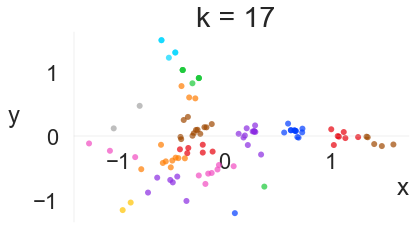

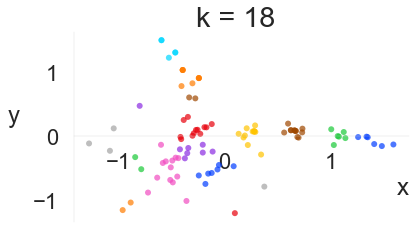

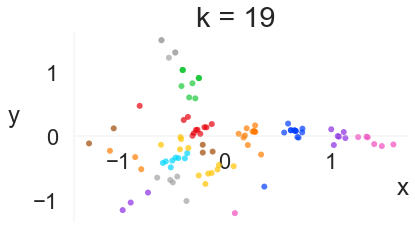

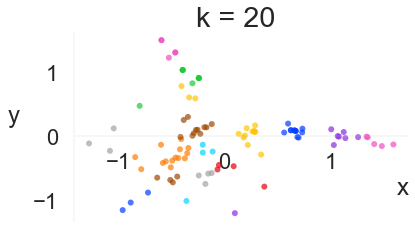

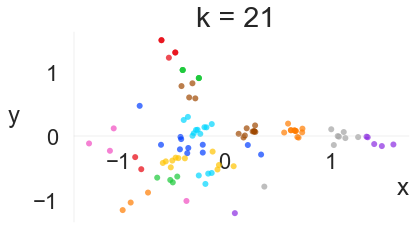

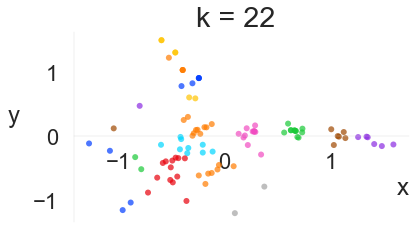

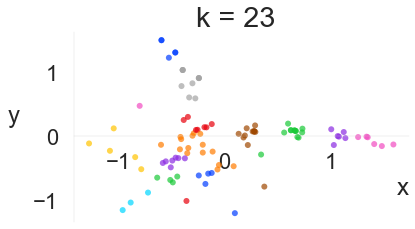

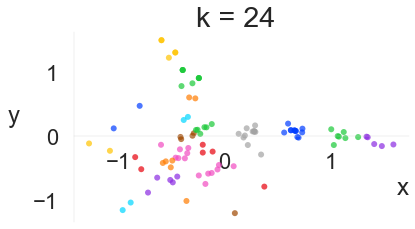

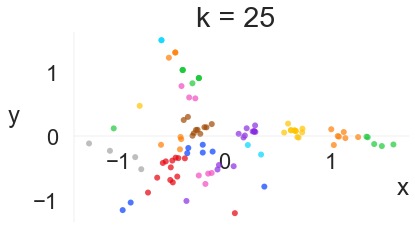

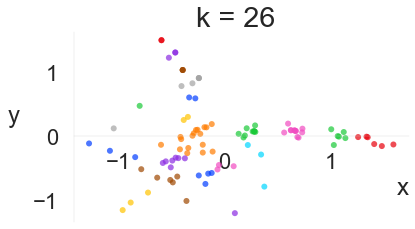

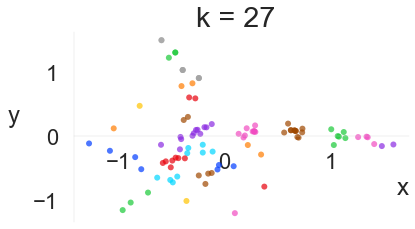

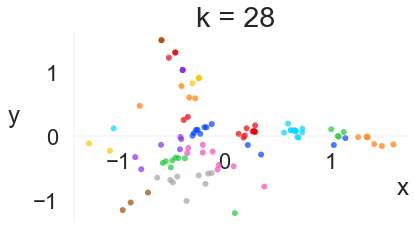

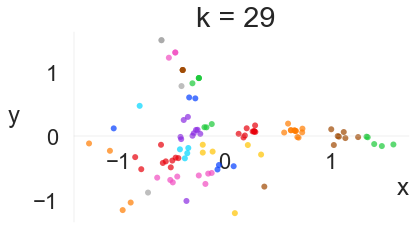

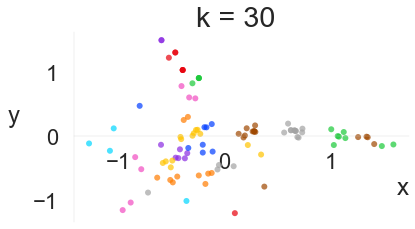

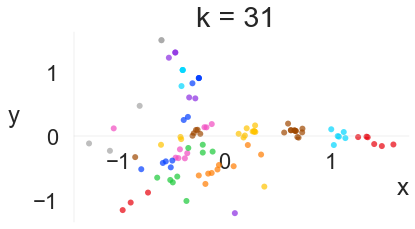

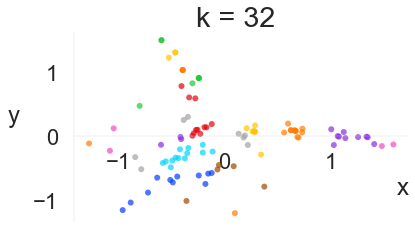

In [41]:
# Based on what you see, what seems to be the best value for 𝐾?
for k in range(2, len(matrix) // 3):
    pca_df2 = pca_df.drop("cluster id", axis="columns")
    pca_df2["cluster id"] = KMeans(n_clusters=k, random_state=2021).fit_predict(
        pca_df[["x", "y"]]
    )

    sns.scatterplot(
        x=pca_df2.x,
        y=pca_df2.y,
        hue=pca_df2["cluster id"],
        marker=".",
        alpha=0.7,
        linewidth=0,
        palette="bright",
    )

    plt.suptitle("k = {}".format(k))
    plt.gcf().set_size_inches(6, 3.5)
    ax = plt.gca()

    plt.grid(False)
    plt.legend().remove()

    ax.spines[["right", "top"]].set_visible(False)
    ax.spines.bottom.set_position("zero")
    ax.spines[["left", "bottom"]].set_linewidth(0.3)

    plt.ylabel("y", labelpad=20).set_rotation(0)
    ax.set_xlabel("x", loc="right")

    plt.show()

In [42]:
print("The plots quickly become cluttered as k increases.")
print("For the lower values of k, the clusters appear intuitively separable.")
print("It's hard to say which value of k is best from these plots alone.")

The plots quickly become cluttered as k increases.
For the lower values of k, the clusters appear intuitively separable.
It's hard to say which value of k is best from these plots alone.


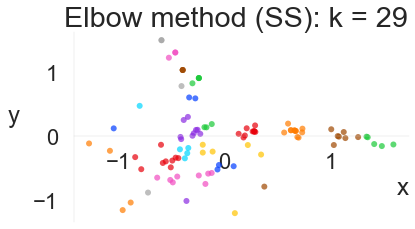

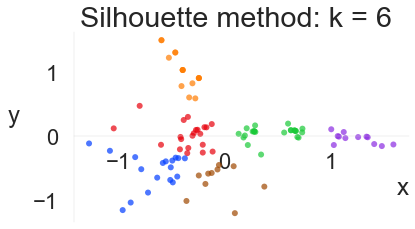

In [43]:
# Moreover, which method of choosing 𝐾 seems to have produced the optimal result visually?
for k in {6, 29}:
    pca_df2 = pca_df.drop("cluster id", axis="columns")
    pca_df2["cluster id"] = KMeans(n_clusters=k, random_state=2021).fit_predict(
        pca_df2[["x", "y"]]
    )

    sns.scatterplot(
        x=pca_df2.x,
        y=pca_df2.y,
        hue=pca_df2["cluster id"],
        marker=".",
        alpha=0.7,
        linewidth=0,
        palette="bright",
    )

    if k == 6:
        plt.suptitle("Silhouette method: k = {}".format(k))
    else:
        plt.suptitle("Elbow method (SS): k = {}".format(k))

    plt.gcf().set_size_inches(6, 3.5)
    ax = plt.gca()

    plt.grid(False)
    plt.legend().remove()

    ax.spines[["right", "top"]].set_visible(False)
    ax.spines.bottom.set_position("zero")
    ax.spines[["left", "bottom"]].set_linewidth(0.3)

    plt.ylabel("y", labelpad=20).set_rotation(0)
    ax.set_xlabel("x", loc="right")

    plt.show()

In [44]:
print(
    "It was hard to detect an elbow when examining SS without expanding the search range for k."
)
print("The plot is hard to decipher with 29 clusters, but 6 clusters looks okay.")
print("The plots do not reveal a reason not to prefer k=6 over k=29.")

It was hard to detect an elbow when examining SS without expanding the search range for k.
The plot is hard to decipher with 29 clusters, but 6 clusters looks okay.
The plots do not reveal a reason not to prefer k=6 over k=29.


In [45]:
# Now look at both the original raw data about the offers and transactions and look at the fitted clusters.
# Tell a story about the clusters in context of the original data.
# For example, do the clusters correspond to wine variants or something else interesting?

In [46]:
# Assess skew in principal components for better visualization
print("x skew:", pca_df.x.skew())
print("y skew:", pca_df.y.skew())
print("moderate positive skew")
print("x skew after cube root:", np.cbrt(pca_df.x).skew())
print("y skew after cube root:", np.cbrt(pca_df.y).skew())
print(pca_df.x.describe())
print(pca_df.y.describe())

x skew: 0.6689224503640353
y skew: 0.6343626713305636
moderate positive skew
x skew after cube root: 0.4690572853082019
y skew after cube root: 0.11929059571592372
count    1.000000e+02
mean     2.442491e-17
std      6.400382e-01
min     -1.274329e+00
25%     -4.217557e-01
50%     -2.146355e-01
75%      3.541776e-01
max      1.593182e+00
Name: x, dtype: float64
count    1.000000e+02
mean     4.440892e-18
std      5.545588e-01
min     -1.208376e+00
25%     -3.309751e-01
50%     -7.829880e-03
75%      1.188929e-01
max      1.506500e+00
Name: y, dtype: float64


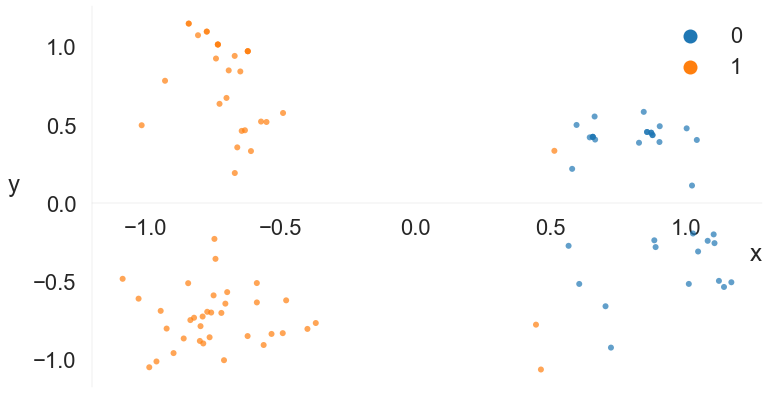

In [47]:
# Plot transformed principal components
sns.scatterplot(
    x=np.cbrt(pca_df.x),
    y=np.cbrt(pca_df.y),
    hue=pca_df["cluster id"],
    marker=".",
    alpha=0.7,
    linewidth=0,
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(frameon=False)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("y", labelpad=20).set_rotation(0)
ax.set_xlabel("x", loc="right")

plt.show()

In [48]:
print("The data looks much more separable now!")
print(
    "However, there are three orange points near the right side that make for an unsatisfactory cluster."
)
print("Let's try refitting the cluster labels using the transformed components.")

The data looks much more separable now!
However, there are three orange points near the right side that make for an unsatisfactory cluster.
Let's try refitting the cluster labels using the transformed components.


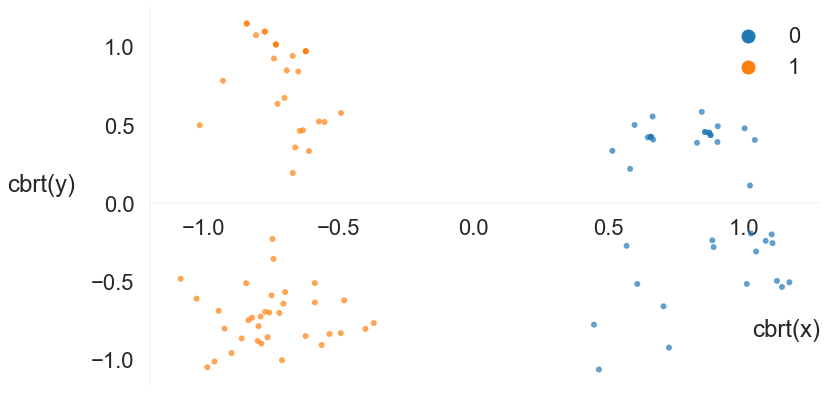

In [49]:
pca_df["cluster id 2"] = KMeans(n_clusters=2, random_state=2021).fit_predict(
    pd.DataFrame({"cbrt x": np.cbrt(pca_df.x), "cbrt y": np.cbrt(pca_df.y)})
)
# Plot transformed principal components
sns.scatterplot(
    x=np.cbrt(pca_df.x),
    y=np.cbrt(pca_df.y),
    hue=pca_df["cluster id 2"],
    marker=".",
    alpha=0.7,
    linewidth=0,
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(frameon=False)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=80)

plt.show()

In [50]:
print("Let's see if reducing the skew further uncovers better clusters.")

Let's see if reducing the skew further uncovers better clusters.


In [51]:
print("x skew:", pca_df.x.skew())
print("y skew:", pca_df.y.skew())
print("moderate positive skew")
print("x skew after cube root:", np.cbrt(pca_df.x).skew())
print("y skew after cube root:", np.cbrt(pca_df.y).skew())
print("x skew after fifth root:", (pca_df.x**0.2).skew())
print("y skew after fifth root:", (pca_df.y**0.2).skew())
print("x skew after ln(x+1.3):", np.log(pca_df.x+1.3).skew())
print("y skew after ln(x+1.3):", np.log(pca_df.y+1.3).skew())
print("x skew after ln(x+10):", np.log(pca_df.x+10).skew())
print("y skew after ln(x+10):", np.log(pca_df.y+10).skew())
print("x skew after ln(x+100):", np.log(pca_df.x+100).skew())
print("y skew after ln(x+100):", np.log(pca_df.y+100).skew())
print("x skew after ln(x+5):", np.log(pca_df.x+5).skew())
print("y skew after ln(x+5):", np.log(pca_df.y+5).skew())
print("x skew after ln(x+2):", np.log(pca_df.x+2).skew())
print("y skew after ln(x+2):", np.log(pca_df.y+2).skew())

x skew: 0.6689224503640353
y skew: 0.6343626713305636
moderate positive skew
x skew after cube root: 0.4690572853082019
y skew after cube root: 0.11929059571592372
x skew after fifth root: -0.291003951199717
y skew after fifth root: 0.22931130768479427
x skew after ln(x+1.3): -2.3019917511010863
y skew after ln(x+1.3): -1.8746375979621155
x skew after ln(x+10): 0.5439956297735636
y skew after ln(x+10): 0.4380513899448961
x skew after ln(x+100): 0.6564680832922534
y skew after ln(x+100): 0.6147835108402555
x skew after ln(x+5): 0.41440861029487075
y skew after ln(x+5): 0.23704798302007205
x skew after ln(x+2): -0.09207144477137211
y skew after ln(x+2): -0.47303778585588724


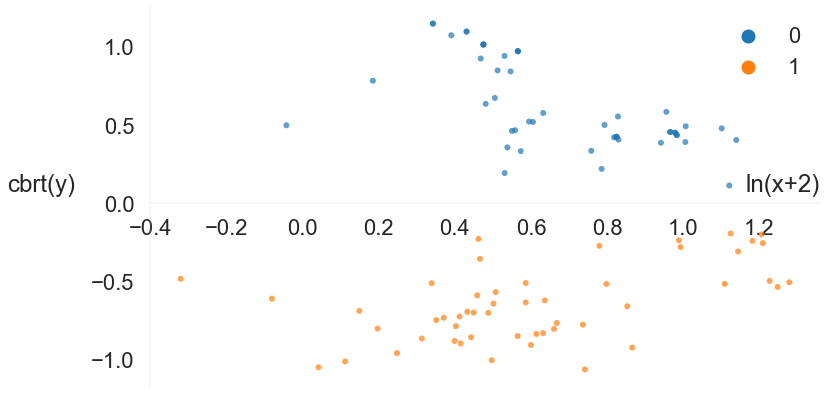

In [52]:
pca_df["cluster id 3"] = KMeans(n_clusters=2, random_state=2021).fit_predict(
    pd.DataFrame({"ln(x+2)": np.log(pca_df.x+2), "cbrt y": np.cbrt(pca_df.y)})
)
# Plot transformed principal components
sns.scatterplot(
    x=np.log(pca_df.x+2),
    y=np.cbrt(pca_df.y),
    hue=pca_df["cluster id 3"],
    marker=".",
    alpha=0.7,
    linewidth=0,
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(frameon=False)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=-65)

plt.show()

In [53]:
pca_df_explore = pca_df.drop(
    ["cluster id", "cluster id 2", "cluster id 3"], axis="columns"
)
pca_df_explore.x = np.cbrt(pca_df.x)
pca_df_explore.y = np.cbrt(pca_df.y)
pca_df_explore = pca_df_explore.rename(columns={"x": "cbrt(x)", "y": "cbrt(y)"})
pca_df_explore["ln(x+2)"] = np.log(pca_df.x + 2)

In [54]:
# Examining the number of offers completed
pca_df_explore["offers_completed"] = (
    df_transactions.customer_name.value_counts().sort_index().values
)
pca_df_explore

new_id customer_name  1  2  3  4  5  6  7  8  9  ...  27  28  29  30  31  32  \
0              Adams  0  0  0  0  0  0  0  0  0  ...   0   0   1   1   0   0   
1              Allen  0  0  0  0  0  0  0  0  1  ...   1   0   0   0   0   0   
2           Anderson  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   
3             Bailey  0  0  0  0  0  0  1  0  0  ...   0   0   0   1   0   0   
4              Baker  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   1   0   
..               ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..   
95          Williams  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   1   0   
96            Wilson  0  0  0  0  0  0  0  1  0  ...   0   0   0   1   0   0   
97              Wood  1  0  0  0  0  0  0  0  0  ...   0   0   0   0   1   0   
98            Wright  0  0  0  1  0  1  0  0  0  ...   1   0   0   0   0   0   
99             Young  0  0  0  0  0  1  0  0  1  ...   0   0   0   0   1   1   

new_id   cbrt(x)   cbrt(y)   ln(x+2)  offers_completed  
0       1.002520  0.476536  1.101136                 3  
1      -0.660033  0.354936  0.537931                 2  
2      -0.731881  1.012637  0.474971                 2  
3       0.887683 -0.282487  0.993058                 2  
4       0.445105 -0.778432  0.736294                 4  
..           ...       ...       ...               ...  
95     -0.533289 -0.837698  0.614285                 3  
96      0.882897 -0.239209  0.988881                 2  
97     -0.819924 -0.734138  0.370725                 4  
98     -0.788269 -0.726411  0.412239                 4  
99     -0.959007 -1.013740  0.111547                 6  

[100 rows x 37 columns]

In [55]:
print(pca_df_explore["offers_completed"].skew())
print("offers completed is positively skewed")
print("skew after ln", np.log(pca_df_explore["offers_completed"]).skew())
print("skew after cube root", np.cbrt(pca_df_explore["offers_completed"]).skew())
pca_df_explore["offers_completed"].describe()

0.9062547180702568
offers completed is positively skewed
skew after ln -0.27111910873322875
skew after cube root 0.12394990253449811


count    100.000000
mean       3.240000
std        1.608814
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        9.000000
Name: offers_completed, dtype: float64

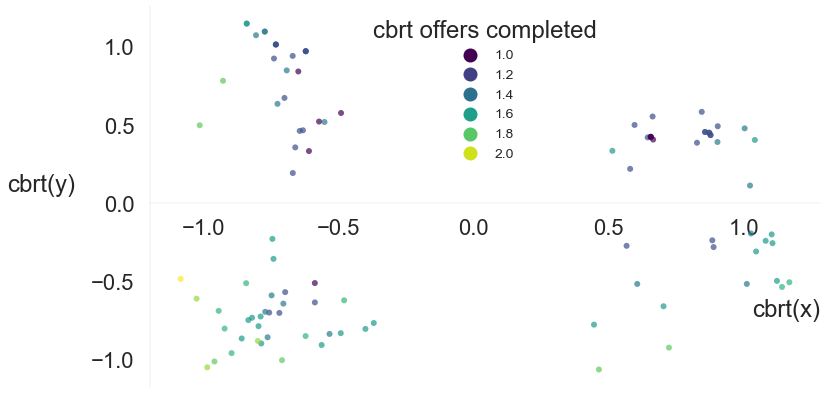

In [56]:
sns.scatterplot(
    x=pca_df_explore["cbrt(x)"],
    y=pca_df_explore["cbrt(y)"],
    hue=np.cbrt(pca_df_explore["offers_completed"]),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="cbrt offers completed"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

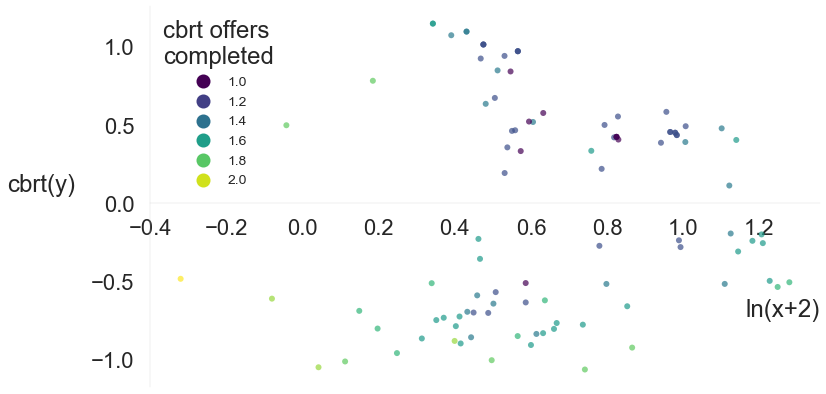

In [57]:
sns.scatterplot(
    x=pca_df_explore["ln(x+2)"],
    y=pca_df_explore["cbrt(y)"],
    hue=np.cbrt(pca_df_explore["offers_completed"]),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper left", fontsize="xx-small", title="cbrt offers\ncompleted"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=60)

plt.show()

In [58]:
print("The plots above reveal customer records of similar hue in proximity with one another.")
print("The number of offers a customer completes could be partially informative of similarity.")

The plots above reveal customer records of similar hue in proximity with one another.
The number of offers a customer completes could be partially informative of similarity.


In [59]:
# Examining the percent of past-peak transactions per customer
merge_past_peak = df_offers.merge(df_transactions)[["customer_name", "past_peak"]]
past_peak_false = (
    merge_past_peak[merge_past_peak.past_peak == False]
    .value_counts()
    .reset_index()
    .drop("past_peak", axis="columns")
    .rename(columns={0: "past_peak_false"})
)
past_peak_true = (
    merge_past_peak[merge_past_peak.past_peak == True]
    .value_counts()
    .reset_index()
    .drop("past_peak", axis="columns")
    .rename(columns={0: "past_peak_true"})
)
merge_copy = past_peak_true.merge(
    past_peak_false, on="customer_name", how="outer"
).fillna(0)
merge_copy["past_peak_true_pct"] = merge_copy.past_peak_true / (
    merge_copy.past_peak_true + merge_copy.past_peak_false
)
pca_df_explore2 = pca_df_explore.merge(merge_copy, on="customer_name")
print(pca_df_explore2[["past_peak_true_pct"]].describe())
pca_df_explore2

       past_peak_true_pct
count          100.000000
mean             0.173786
std              0.241638
min              0.000000
25%              0.000000
50%              0.000000
75%              0.333333
max              1.000000


customer_name  1  2  3  4  5  6  7  8  9  ...  30  31  32   cbrt(x)  \
0          Adams  0  0  0  0  0  0  0  0  0  ...   1   0   0  1.002520   
1          Allen  0  0  0  0  0  0  0  0  1  ...   0   0   0 -0.660033   
2       Anderson  0  0  0  0  0  0  0  0  0  ...   0   0   0 -0.731881   
3         Bailey  0  0  0  0  0  0  1  0  0  ...   1   0   0  0.887683   
4          Baker  0  0  0  0  0  0  1  0  0  ...   0   1   0  0.445105   
..           ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..       ...   
95      Williams  0  0  0  0  0  0  0  0  0  ...   0   1   0 -0.533289   
96        Wilson  0  0  0  0  0  0  0  1  0  ...   1   0   0  0.882897   
97          Wood  1  0  0  0  0  0  0  0  0  ...   0   1   0 -0.819924   
98        Wright  0  0  0  1  0  1  0  0  0  ...   0   0   0 -0.788269   
99         Young  0  0  0  0  0  1  0  0  1  ...   0   1   1 -0.959007   

     cbrt(y)   ln(x+2)  offers_completed  past_peak_true  past_peak_false  \
0   0.476536  1.101136                 3             0.0              3.0   
1   0.354936  0.537931                 2             0.0              2.0   
2   1.012637  0.474971                 2             0.0              2.0   
3  -0.282487  0.993058                 2             1.0              1.0   
4  -0.778432  0.736294                 4             1.0              3.0   
..       ...       ...               ...             ...              ...   
95 -0.837698  0.614285                 3             0.0              3.0   
96 -0.239209  0.988881                 2             0.0              2.0   
97 -0.734138  0.370725                 4             0.0              4.0   
98 -0.726411  0.412239                 4             1.0              3.0   
99 -1.013740  0.111547                 6             1.0              5.0   

    past_peak_true_pct  
0             0.000000  
1             0.000000  
2             0.000000  
3             0.500000  
4             0.250000  
..                 ...  
95            0.000000  
96            0.000000  
97            0.000000  
98            0.250000  
99            0.166667  

[100 rows x 40 columns]

In [60]:
print(pca_df_explore2["past_peak_true_pct"].skew())
print("% of offers past peak is positively skewed")
print("skew after square root:", np.sqrt(pca_df_explore2["past_peak_true_pct"]).skew())
print("skew after cube root:", np.cbrt(pca_df_explore2["past_peak_true_pct"]).skew())
print(
    "skew after fourth root:", (pca_df_explore2["past_peak_true_pct"] ** (0.25)).skew()
)
pca_df_explore2["past_peak_true_pct"].describe()

1.5204881207876941
% of offers past peak is positively skewed
skew after square root: 0.5821963574727205
skew after cube root: 0.3932041256920096
skew after fourth root: 0.32754902225695515


count    100.000000
mean       0.173786
std        0.241638
min        0.000000
25%        0.000000
50%        0.000000
75%        0.333333
max        1.000000
Name: past_peak_true_pct, dtype: float64

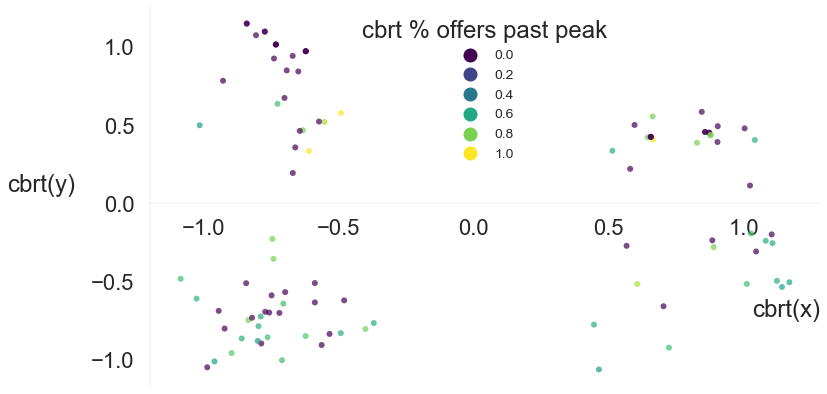

In [61]:
sns.scatterplot(
    x=pca_df_explore2["cbrt(x)"],
    y=pca_df_explore2["cbrt(y)"],
    hue=np.cbrt(pca_df_explore2["past_peak_true_pct"]),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="cbrt % offers past peak"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

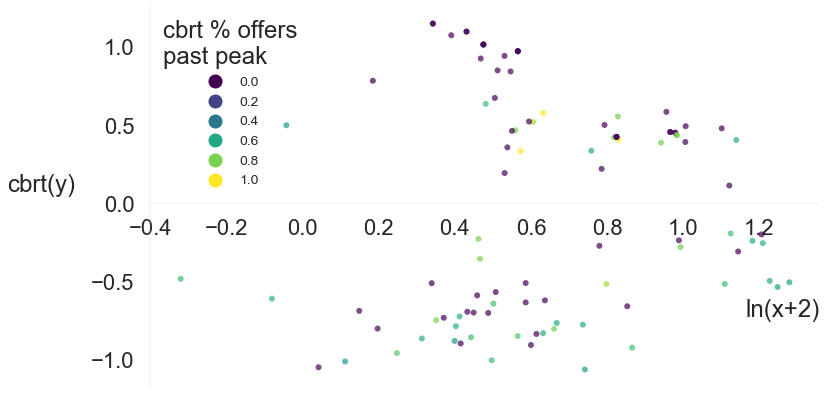

In [62]:
sns.scatterplot(
    x=pca_df_explore2["ln(x+2)"],
    y=pca_df_explore2["cbrt(y)"],
    hue=np.cbrt(pca_df_explore2["past_peak_true_pct"]),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper left", fontsize="xx-small", title="cbrt % offers\npast peak"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=60)

plt.show()

In [63]:
print(
    "The plots reveal customer records with high and low values for % offers past peak quite close to each other."
)
print(
    "The percentage of past-peak offers completed is unlikely to be informative alone for customer segmentation."
)

The plots reveal customer records with high and low values for % offers past peak quite close to each other.
The percentage of past-peak offers completed is unlikely to be informative alone for customer segmentation.


In [64]:
# Examining origin
merge_origin = df_offers.merge(df_transactions)[
    ["customer_name", "origin"]
]
temp_df = pca_df_explore2[["customer_name"]]
for region in merge_origin.origin.value_counts().index:
    temp_df = temp_df.merge(
        merge_origin[merge_origin.origin == region]
        .value_counts()
        .reset_index()
        .drop("origin", axis="columns")
        .rename(columns={0: region}),
        on="customer_name",
        how="outer",
    )
temp_df = temp_df.fillna(0)
temp_df

customer_name  France  Australia  Chile  Oregon  South Africa  Italy  \
0          Adams     2.0        0.0    0.0     1.0           0.0    0.0   
1          Allen     0.0        0.0    1.0     0.0           0.0    0.0   
2       Anderson     0.0        1.0    0.0     0.0           0.0    1.0   
3         Bailey     1.0        1.0    0.0     0.0           0.0    0.0   
4          Baker     1.0        1.0    0.0     0.0           0.0    0.0   
..           ...     ...        ...    ...     ...           ...    ...   
95      Williams     2.0        0.0    0.0     1.0           0.0    0.0   
96        Wilson     1.0        0.0    0.0     0.0           1.0    0.0   
97          Wood     2.0        0.0    1.0     0.0           0.0    0.0   
98        Wright     1.0        0.0    1.0     0.0           0.0    0.0   
99         Young     2.0        0.0    2.0     0.0           0.0    1.0   

    Germany  California  New Zealand  
0       0.0         0.0          0.0  
1       0.0         0.0          1.0  
2       0.0         0.0          0.0  
3       0.0         0.0          0.0  
4       1.0         1.0          0.0  
..      ...         ...          ...  
95      0.0         0.0          0.0  
96      0.0         0.0          0.0  
97      0.0         1.0          0.0  
98      0.0         1.0          1.0  
99      1.0         0.0          0.0  

[100 rows x 10 columns]

In [65]:
# Susbtitute a single principal component for origin vectors
temp_df["origin_component"] = PCA(n_components=1, random_state=2021).fit_transform(
    temp_df.drop("customer_name", axis="columns")
)
pca_df_explore3 = pca_df_explore2.drop(
    ["past_peak_true", "past_peak_false"], axis="columns"
).merge(temp_df[["customer_name", "origin_component"]], on="customer_name")
pca_df_explore3

customer_name  1  2  3  4  5  6  7  8  9  ...  29  30  31  32   cbrt(x)  \
0          Adams  0  0  0  0  0  0  0  0  0  ...   1   1   0   0  1.002520   
1          Allen  0  0  0  0  0  0  0  0  1  ...   0   0   0   0 -0.660033   
2       Anderson  0  0  0  0  0  0  0  0  0  ...   0   0   0   0 -0.731881   
3         Bailey  0  0  0  0  0  0  1  0  0  ...   0   1   0   0  0.887683   
4          Baker  0  0  0  0  0  0  1  0  0  ...   0   0   1   0  0.445105   
..           ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..       ...   
95      Williams  0  0  0  0  0  0  0  0  0  ...   0   0   1   0 -0.533289   
96        Wilson  0  0  0  0  0  0  0  1  0  ...   0   1   0   0  0.882897   
97          Wood  1  0  0  0  0  0  0  0  0  ...   0   0   1   0 -0.819924   
98        Wright  0  0  0  1  0  1  0  0  0  ...   0   0   0   0 -0.788269   
99         Young  0  0  0  0  0  1  0  0  1  ...   0   0   1   1 -0.959007   

     cbrt(y)   ln(x+2)  offers_completed  past_peak_true_pct  origin_component  
0   0.476536  1.101136                 3            0.000000          0.752645  
1   0.354936  0.537931                 2            0.000000         -1.187083  
2   1.012637  0.474971                 2            0.000000         -1.341977  
3  -0.282487  0.993058                 2            0.500000         -0.310041  
4  -0.778432  0.736294                 4            0.250000         -0.372520  
..       ...       ...               ...                 ...               ...  
95 -0.837698  0.614285                 3            0.000000          0.752645  
96 -0.239209  0.988881                 2            0.000000         -0.259379  
97 -0.734138  0.370725                 4            0.000000          0.789948  
98 -0.726411  0.412239                 4            0.250000         -0.205255  
99 -1.013740  0.111547                 6            0.166667          0.744310  

[100 rows x 39 columns]

In [66]:
print(pca_df_explore3.origin_component.skew())
print("origin principal component is positively skewed")
print("skew after cube root", np.cbrt(pca_df_explore3["origin_component"]).skew())
print("skew after fifth root", (pca_df_explore3["origin_component"] ** (1 / 5)).skew())
pca_df_explore3.origin_component.describe()

1.5796095661991982
origin principal component is positively skewed
skew after cube root 0.47370371772626624
skew after fifth root 1.858966015276981


count    1.000000e+02
mean    -7.771561e-18
std      1.213863e+00
min     -1.398921e+00
25%     -1.187083e+00
50%     -2.517868e-01
75%      7.223476e-01
max      5.732649e+00
Name: origin_component, dtype: float64

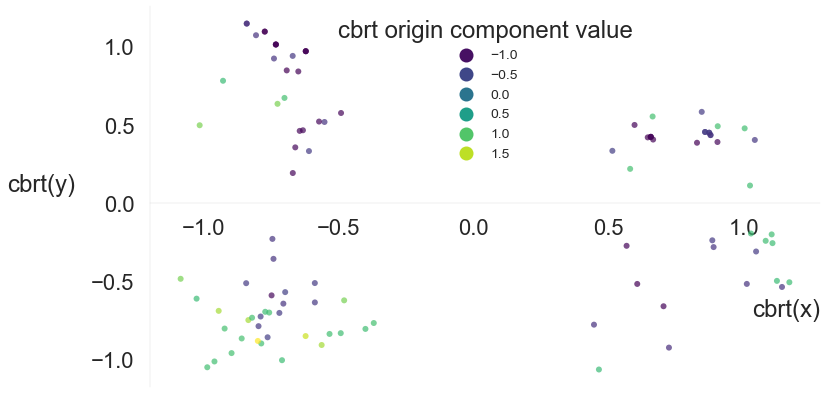

In [67]:
sns.scatterplot(
    x=pca_df_explore3["cbrt(x)"],
    y=pca_df_explore3["cbrt(y)"],
    hue=np.cbrt(pca_df_explore3["origin_component"]),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="cbrt origin component value"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

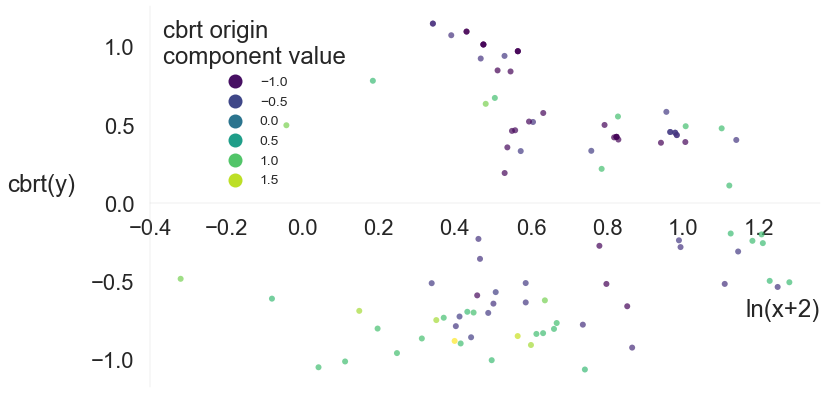

In [68]:
sns.scatterplot(
    x=pca_df_explore3["ln(x+2)"],
    y=pca_df_explore3["cbrt(y)"],
    hue=np.cbrt(pca_df_explore3["origin_component"]),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper left", fontsize="xx-small", title="cbrt origin\ncomponent value"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=60)

plt.show()

In [69]:
print("The plots above reveal customer records of similar hue in proximity with one another.")
print("The origin of the wine could be partially informative of similarity.")

The plots above reveal customer records of similar hue in proximity with one another.
The origin of the wine could be partially informative of similarity.


In [70]:
# Examining campaign time of year
merge_campaign = df_offers.merge(df_transactions)[["customer_name", "campaign"]]
merge_campaign.campaign = merge_campaign.campaign.replace(
    {
        m: months[1]
        for months in [
            (["January", "February", "March"], "Q1"),
            (["April", "May", "June"], "Q2"),
            (["July", "August", "September"], "Q3"),
            (["October", "November", "December"], "Q4"),
        ]
        for m in months[0]
    }
)
merge_campaign

customer_name campaign
0          Thomas       Q1
1         Jackson       Q1
2        Mitchell       Q1
3        Peterson       Q1
4            Wood       Q1
..            ...      ...
319        Fisher       Q4
320         Young       Q4
321        Cooper       Q4
322         Gomez       Q4
323         Kelly       Q4

[324 rows x 2 columns]

In [71]:
temp_df2 = pca_df_explore3[["customer_name"]]
for quarter in {"Q1", "Q2", "Q3", "Q4"}:
    temp_df2 = temp_df2.merge(
        merge_campaign[merge_campaign.campaign == quarter]
        .value_counts()
        .reset_index()
        .drop("campaign", axis="columns")
        .rename(columns={0: quarter}),
        on="customer_name",
        how="outer",
    )
temp_df2 = temp_df2.fillna(0)
temp_df2

customer_name   Q2   Q4   Q3   Q1
0          Adams  0.0  2.0  1.0  0.0
1          Allen  1.0  1.0  0.0  0.0
2       Anderson  0.0  1.0  1.0  0.0
3         Bailey  0.0  1.0  0.0  1.0
4          Baker  1.0  1.0  1.0  1.0
..           ...  ...  ...  ...  ...
95      Williams  0.0  1.0  2.0  0.0
96        Wilson  0.0  1.0  0.0  1.0
97          Wood  2.0  1.0  0.0  1.0
98        Wright  0.0  1.0  1.0  2.0
99         Young  2.0  2.0  1.0  1.0

[100 rows x 5 columns]

In [72]:
# Susbtitute a single principal component for quarter vectors
temp_df2["quarter_component"] = PCA(n_components=1, random_state=2021).fit_transform(
    temp_df2.drop("customer_name", axis="columns")
)
pca_df_explore4 = pca_df_explore3.merge(temp_df2[["customer_name", "quarter_component"]], on="customer_name")
pca_df_explore4

customer_name  1  2  3  4  5  6  7  8  9  ...  30  31  32   cbrt(x)  \
0          Adams  0  0  0  0  0  0  0  0  0  ...   1   0   0  1.002520   
1          Allen  0  0  0  0  0  0  0  0  1  ...   0   0   0 -0.660033   
2       Anderson  0  0  0  0  0  0  0  0  0  ...   0   0   0 -0.731881   
3         Bailey  0  0  0  0  0  0  1  0  0  ...   1   0   0  0.887683   
4          Baker  0  0  0  0  0  0  1  0  0  ...   0   1   0  0.445105   
..           ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..       ...   
95      Williams  0  0  0  0  0  0  0  0  0  ...   0   1   0 -0.533289   
96        Wilson  0  0  0  0  0  0  0  1  0  ...   1   0   0  0.882897   
97          Wood  1  0  0  0  0  0  0  0  0  ...   0   1   0 -0.819924   
98        Wright  0  0  0  1  0  1  0  0  0  ...   0   0   0 -0.788269   
99         Young  0  0  0  0  0  1  0  0  1  ...   0   1   1 -0.959007   

     cbrt(y)   ln(x+2)  offers_completed  past_peak_true_pct  \
0   0.476536  1.101136                 3            0.000000   
1   0.354936  0.537931                 2            0.000000   
2   1.012637  0.474971                 2            0.000000   
3  -0.282487  0.993058                 2            0.500000   
4  -0.778432  0.736294                 4            0.250000   
..       ...       ...               ...                 ...   
95 -0.837698  0.614285                 3            0.000000   
96 -0.239209  0.988881                 2            0.000000   
97 -0.734138  0.370725                 4            0.000000   
98 -0.726411  0.412239                 4            0.250000   
99 -1.013740  0.111547                 6            0.166667   

    origin_component  quarter_component  
0           0.752645          -0.778866  
1          -1.187083          -1.022397  
2          -1.341977          -0.847061  
3          -0.310041           0.038764  
4          -0.372520           0.071125  
..               ...                ...  
95          0.752645          -0.743212  
96         -0.259379           0.038764  
97          0.789948          -0.104211  
98         -0.205255           1.132287  
99          0.744310           0.067832  

[100 rows x 40 columns]

In [73]:
print(pca_df_explore4.quarter_component.skew())
print("quarter principal component is positively skewed")
print("skew after cube root", np.cbrt(pca_df_explore4["quarter_component"]).skew())
print("skew after fifth root", (pca_df_explore4["quarter_component"]**(1/5)).skew())
pca_df_explore4.quarter_component.describe()

0.9347965859340811
quarter principal component is positively skewed
skew after cube root 0.07099961802726161
skew after fifth root 0.08931528034620398


count    1.000000e+02
mean    -9.048318e-17
std      9.160954e-01
min     -1.236861e+00
25%     -8.470608e-01
50%      3.364524e-02
75%      2.197211e-01
max      3.036854e+00
Name: quarter_component, dtype: float64

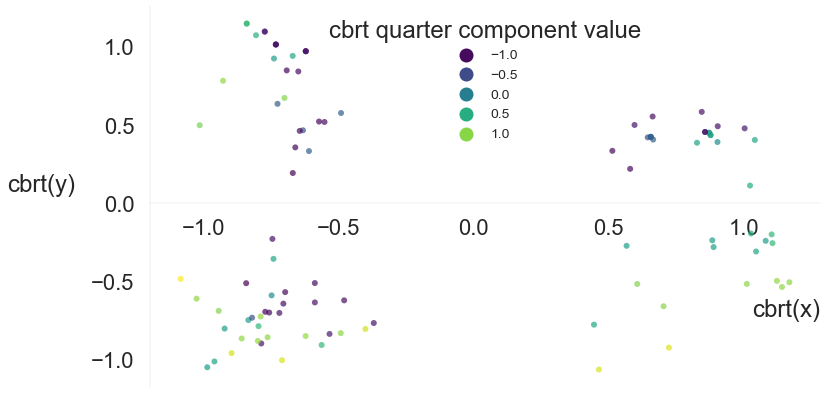

In [74]:
sns.scatterplot(
    x=pca_df_explore4["cbrt(x)"],
    y=pca_df_explore4["cbrt(y)"],
    hue=np.cbrt(pca_df_explore4["quarter_component"]),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="cbrt quarter component value"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

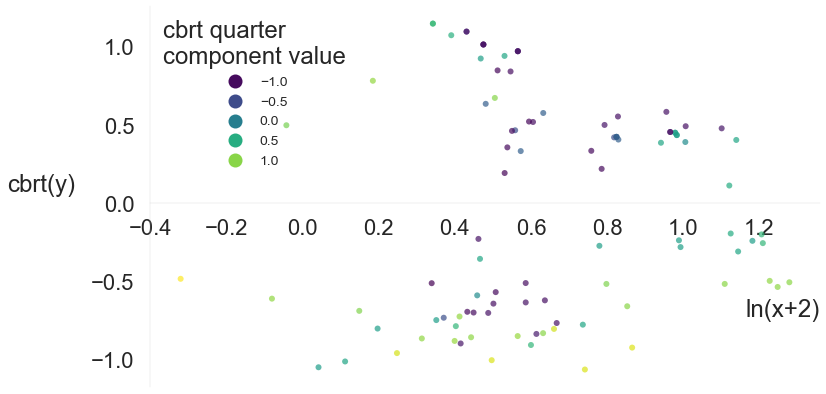

In [75]:
sns.scatterplot(
    x=pca_df_explore4["ln(x+2)"],
    y=pca_df_explore4["cbrt(y)"],
    hue=np.cbrt(pca_df_explore4["quarter_component"]),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper left", fontsize="xx-small", title="cbrt quarter\ncomponent value"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=60)

plt.show()

In [76]:
print(
    "The plot above reveals customer records of similar hue in proximity with one another."
)
print("The time of year of the deal could be partially informative of similarity.")
print(
    "However, the time of year may be less informative for the records in the bottom left."
)
print()
print("'Smooth' color gradients may be observed in the bottom right.")
print("This may indicate possible local correlation between the transformed features.")

The plot above reveals customer records of similar hue in proximity with one another.
The time of year of the deal could be partially informative of similarity.
However, the time of year may be less informative for the records in the bottom left.

'Smooth' color gradients may be observed in the bottom right.
This may indicate possible local correlation between the transformed features.


In [77]:
# Examining varietal
merge_varietal = df_offers.merge(df_transactions)[
    ["customer_name", "varietal"]
]
temp_df3 = pca_df_explore4[["customer_name"]]
for variety in merge_varietal.varietal.value_counts().index:
    temp_df3 = temp_df3.merge(
        merge_varietal[merge_varietal.varietal == variety]
        .value_counts()
        .reset_index()
        .drop("varietal", axis="columns")
        .rename(columns={0: variety}),
        on="customer_name",
        how="outer",
    )
temp_df3 = temp_df3.fillna(0)
temp_df3

customer_name  Champagne  Pinot Noir  Prosecco  Espumante  Malbec  \
0          Adams        0.0         0.0       0.0        1.0     1.0   
1          Allen        1.0         0.0       0.0        0.0     0.0   
2       Anderson        0.0         2.0       0.0        0.0     0.0   
3         Bailey        0.0         0.0       1.0        0.0     1.0   
4          Baker        2.0         0.0       2.0        0.0     0.0   
..           ...        ...         ...       ...        ...     ...   
95      Williams        2.0         0.0       0.0        1.0     0.0   
96        Wilson        0.0         0.0       0.0        1.0     1.0   
97          Wood        1.0         0.0       1.0        0.0     1.0   
98        Wright        3.0         0.0       1.0        0.0     0.0   
99         Young        2.0         0.0       1.0        0.0     0.0   

    Cabernet Sauvignon  Merlot  Pinot Grigio  Chardonnay  
0                  0.0     0.0           1.0         0.0  
1                  0.0     0.0           0.0         1.0  
2                  0.0     0.0           0.0         0.0  
3                  0.0     0.0           0.0         0.0  
4                  0.0     0.0           0.0         0.0  
..                 ...     ...           ...         ...  
95                 0.0     0.0           0.0         0.0  
96                 0.0     0.0           0.0         0.0  
97                 0.0     1.0           0.0         0.0  
98                 0.0     0.0           0.0         0.0  
99                 2.0     0.0           0.0         1.0  

[100 rows x 10 columns]

In [78]:
# Susbtitute a single principal component for varietal vectors
temp_df3["varietal_component"] = PCA(n_components=1, random_state=2021).fit_transform(
    temp_df3.drop("customer_name", axis="columns")
)
pca_df_explore5 = pca_df_explore4.merge(
    temp_df3[["customer_name", "varietal_component"]], on="customer_name"
)
pca_df_explore5

customer_name  1  2  3  4  5  6  7  8  9  ...  31  32   cbrt(x)   cbrt(y)  \
0          Adams  0  0  0  0  0  0  0  0  0  ...   0   0  1.002520  0.476536   
1          Allen  0  0  0  0  0  0  0  0  1  ...   0   0 -0.660033  0.354936   
2       Anderson  0  0  0  0  0  0  0  0  0  ...   0   0 -0.731881  1.012637   
3         Bailey  0  0  0  0  0  0  1  0  0  ...   0   0  0.887683 -0.282487   
4          Baker  0  0  0  0  0  0  1  0  0  ...   1   0  0.445105 -0.778432   
..           ... .. .. .. .. .. .. .. .. ..  ...  ..  ..       ...       ...   
95      Williams  0  0  0  0  0  0  0  0  0  ...   1   0 -0.533289 -0.837698   
96        Wilson  0  0  0  0  0  0  0  1  0  ...   0   0  0.882897 -0.239209   
97          Wood  1  0  0  0  0  0  0  0  0  ...   1   0 -0.819924 -0.734138   
98        Wright  0  0  0  1  0  1  0  0  0  ...   0   0 -0.788269 -0.726411   
99         Young  0  0  0  0  0  1  0  0  1  ...   1   1 -0.959007 -1.013740   

     ln(x+2)  offers_completed  past_peak_true_pct  origin_component  \
0   1.101136                 3            0.000000          0.752645   
1   0.537931                 2            0.000000         -1.187083   
2   0.474971                 2            0.000000         -1.341977   
3   0.993058                 2            0.500000         -0.310041   
4   0.736294                 4            0.250000         -0.372520   
..       ...               ...                 ...               ...   
95  0.614285                 3            0.000000          0.752645   
96  0.988881                 2            0.000000         -0.259379   
97  0.370725                 4            0.000000          0.789948   
98  0.412239                 4            0.250000         -0.205255   
99  0.111547                 6            0.166667          0.744310   

    quarter_component  varietal_component  
0           -0.778866           -0.668227  
1           -1.022397            0.258281  
2           -0.847061           -1.554218  
3            0.038764           -0.415064  
4            0.071125            1.437889  
..                ...                 ...  
95          -0.743212            1.054180  
96           0.038764           -0.608809  
97          -0.104211            0.441999  
98           1.132287            2.086092  
99           0.067832            1.670477  

[100 rows x 41 columns]

In [79]:
pca_df_explore5.varietal_component

0    -0.668227
1     0.258281
2    -1.554218
3    -0.415064
4     1.437889
        ...   
95    1.054180
96   -0.608809
97    0.441999
98    2.086092
99    1.670477
Name: varietal_component, Length: 100, dtype: float64

In [80]:
print(pca_df_explore5.varietal_component.skew())
print("varietal principal component is a positively skewed")
print("skew after cube root", np.cbrt(pca_df_explore5["varietal_component"]).skew())
print(
    "skew after fifth root", (pca_df_explore5["varietal_component"] ** (1 / 5)).skew()
)
print(
    "skew after ln(2.5+x)", np.log(pca_df_explore5["varietal_component"] + 2.5).skew()
)
print(
    "skew after log(2.5+x)",
    np.log10(pca_df_explore5["varietal_component"] + 2.5).skew(),
)
print(
    "skew after log2(2.5+x)",
    np.log2(pca_df_explore5["varietal_component"] + 2.5).skew(),
)
pca_df_explore5["yj"] = pd.DataFrame(
    sklearn.preprocessing.PowerTransformer(method="yeo-johnson").fit_transform(
        X=pca_df_explore5["varietal_component"].values.reshape(-1, 1), y=None
    )
).loc[:, 0]
print("skew after yeo-johnson", pca_df_explore5["yj"].skew())
pca_df_explore5.varietal_component.describe()

0.28125935002592134
varietal principal component is a positively skewed
skew after cube root 0.3164642185465267
skew after fifth root -0.3392221354423464
skew after ln(2.5+x) -4.1345451338499934
skew after log(2.5+x) -4.134545133849994
skew after log2(2.5+x) -4.134545133849994
skew after yeo-johnson -0.05540359956400423


count    1.000000e+02
mean    -3.330669e-17
std      1.150644e+00
min     -2.490061e+00
25%     -6.221557e-01
50%     -4.055889e-01
75%      8.595163e-01
max      3.114225e+00
Name: varietal_component, dtype: float64

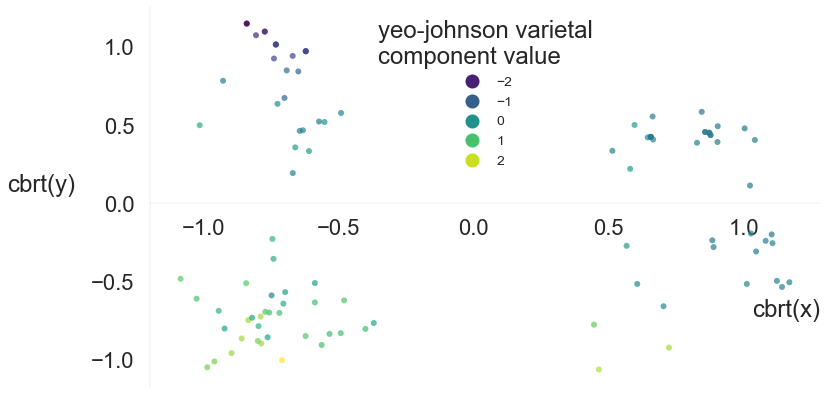

In [81]:
sns.scatterplot(
    x=pca_df_explore5["cbrt(x)"],
    y=pca_df_explore5["cbrt(y)"],
    hue=pca_df_explore5["yj"],
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="yeo-johnson varietal\ncomponent value"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

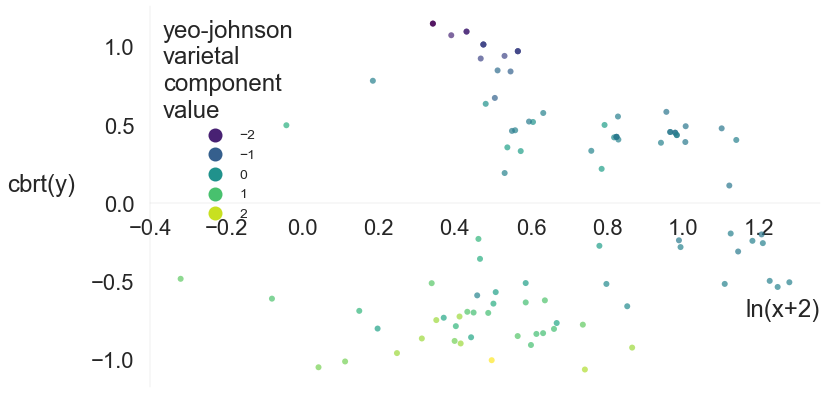

In [82]:
sns.scatterplot(
    x=pca_df_explore5["ln(x+2)"],
    y=pca_df_explore5["cbrt(y)"],
    hue=pca_df_explore5["yj"],
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper left", fontsize="xx-small", title="yeo-johnson\nvarietal\ncomponent\nvalue"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=60)

plt.show()

In [83]:
print(
    "The plot above reveals customer records of similar hue in proximity with one another."
)
print("The wine variety could be partially informative of similarity.")

The plot above reveals customer records of similar hue in proximity with one another.
The wine variety could be partially informative of similarity.


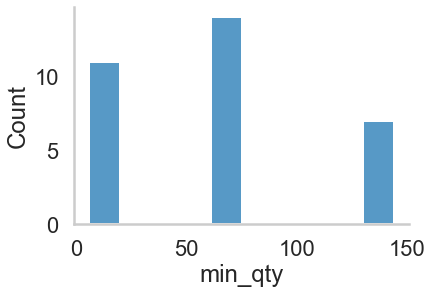

count     32.000000
mean      65.812500
std       50.785722
min        6.000000
25%       12.000000
50%       72.000000
75%       72.000000
max      144.000000
Name: min_qty, dtype: float64

In [84]:
sns.histplot(df_offers.min_qty, bins=10)
plt.gca().spines[["right", "top"]].set_visible(False)
plt.grid(False)
plt.show()
df_offers.min_qty.describe()

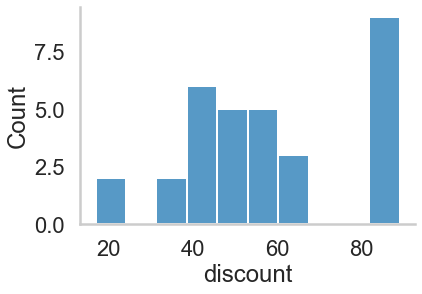

count    32.000000
mean     57.843750
std      20.770807
min      17.000000
25%      44.750000
50%      55.000000
75%      82.250000
max      89.000000
Name: discount, dtype: float64

In [85]:
sns.histplot(df_offers.discount, bins=10)
plt.gca().spines[["right", "top"]].set_visible(False)
plt.grid(False)
plt.show()
df_offers.discount.describe()

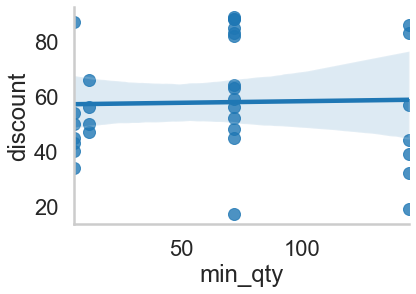

In [86]:
sns.regplot(x=df_offers["min_qty"], y=df_offers["discount"])
plt.grid(False)
plt.gca().spines[["right", "top"]].set_visible(False)
plt.show()

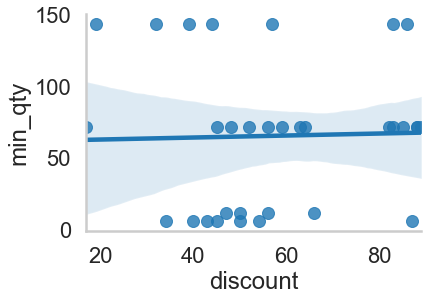

In [87]:
sns.regplot(x=df_offers["discount"], y=df_offers["min_qty"])
plt.grid(False)
plt.gca().spines[["right", "top"]].set_visible(False)
plt.show()

In [88]:
# Turn min_qty into bins
df_offers["min_qty_bins"] = sklearn.preprocessing.KBinsDiscretizer(
    n_bins=3, encode="ordinal", strategy="kmeans"
).fit_transform(df_offers[["min_qty"]])
df_offers.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  min_qty_bins  
0      False           1.0  
1      False           1.0  
2       True           2.0  
3       True           1.0  
4       True           2.0

In [89]:
merge_min_qty = (
    df_offers.merge(df_transactions)[["customer_name", "min_qty_bins"]]
    .pivot_table(index="customer_name")
    .reset_index()
    .rename(columns={"min_qty_bins": "avg_min_qty"})
)
merge_min_qty

customer_name  avg_min_qty
0          Adams     0.000000
1          Allen     1.500000
2       Anderson     1.000000
3         Bailey     0.000000
4          Baker     0.500000
..           ...          ...
95      Williams     0.666667
96        Wilson     0.000000
97          Wood     1.000000
98        Wright     1.000000
99         Young     1.500000

[100 rows x 2 columns]

In [90]:
pca_df_explore6 = pca_df_explore5.drop("yj", axis="columns").merge(
    merge_min_qty, on="customer_name"
)
pca_df_explore6

customer_name  1  2  3  4  5  6  7  8  9  ...  32   cbrt(x)   cbrt(y)  \
0          Adams  0  0  0  0  0  0  0  0  0  ...   0  1.002520  0.476536   
1          Allen  0  0  0  0  0  0  0  0  1  ...   0 -0.660033  0.354936   
2       Anderson  0  0  0  0  0  0  0  0  0  ...   0 -0.731881  1.012637   
3         Bailey  0  0  0  0  0  0  1  0  0  ...   0  0.887683 -0.282487   
4          Baker  0  0  0  0  0  0  1  0  0  ...   0  0.445105 -0.778432   
..           ... .. .. .. .. .. .. .. .. ..  ...  ..       ...       ...   
95      Williams  0  0  0  0  0  0  0  0  0  ...   0 -0.533289 -0.837698   
96        Wilson  0  0  0  0  0  0  0  1  0  ...   0  0.882897 -0.239209   
97          Wood  1  0  0  0  0  0  0  0  0  ...   0 -0.819924 -0.734138   
98        Wright  0  0  0  1  0  1  0  0  0  ...   0 -0.788269 -0.726411   
99         Young  0  0  0  0  0  1  0  0  1  ...   1 -0.959007 -1.013740   

     ln(x+2)  offers_completed  past_peak_true_pct  origin_component  \
0   1.101136                 3            0.000000          0.752645   
1   0.537931                 2            0.000000         -1.187083   
2   0.474971                 2            0.000000         -1.341977   
3   0.993058                 2            0.500000         -0.310041   
4   0.736294                 4            0.250000         -0.372520   
..       ...               ...                 ...               ...   
95  0.614285                 3            0.000000          0.752645   
96  0.988881                 2            0.000000         -0.259379   
97  0.370725                 4            0.000000          0.789948   
98  0.412239                 4            0.250000         -0.205255   
99  0.111547                 6            0.166667          0.744310   

    quarter_component  varietal_component  avg_min_qty  
0           -0.778866           -0.668227     0.000000  
1           -1.022397            0.258281     1.500000  
2           -0.847061           -1.554218     1.000000  
3            0.038764           -0.415064     0.000000  
4            0.071125            1.437889     0.500000  
..                ...                 ...          ...  
95          -0.743212            1.054180     0.666667  
96           0.038764           -0.608809     0.000000  
97          -0.104211            0.441999     1.000000  
98           1.132287            2.086092     1.000000  
99           0.067832            1.670477     1.500000  

[100 rows x 42 columns]

In [91]:
print(pca_df_explore6.avg_min_qty.skew())
print("average minimum quantity of the deal is positively skewed")
print("skew after sqrt", np.sqrt(pca_df_explore6.avg_min_qty).skew())
print("skew after ln(x+1)", np.log(pca_df_explore6.avg_min_qty + 1).skew())
print("skew after ln(x+0.0001)", np.log(pca_df_explore6.avg_min_qty + 0.0001).skew())
print("skew after ln(x+10)", np.log(pca_df_explore6.avg_min_qty + 10).skew())
print("skew after ln(x+5)", np.log(pca_df_explore6.avg_min_qty + 5).skew())
print("skew after ln(x+3)", np.log(pca_df_explore6.avg_min_qty + 3).skew())
print("skew after ln(x+2)", np.log(pca_df_explore6.avg_min_qty + 2).skew())
print("skew after ln(x+2.5)", np.log(pca_df_explore6.avg_min_qty + 2.5).skew())
print("skew after ln(x+2.7)", np.log(pca_df_explore6.avg_min_qty + 2.7).skew())
print("skew after ln(x+2.6)", np.log(pca_df_explore6.avg_min_qty + 2.6).skew())
print("skew after ln(x+2.55)", np.log(pca_df_explore6.avg_min_qty + 2.55).skew())
pca_df_explore6.avg_min_qty.describe()

0.2329046797540637
average minimum quantity of the deal is positively skewed
skew after sqrt -0.4173740643500419
skew after ln(x+1) -0.17253837985182208
skew after ln(x+0.0001) -0.717148826602688
skew after ln(x+10) 0.1555128542464203
skew after ln(x+5) 0.09316659499971146
skew after ln(x+3) 0.02608889801541795
skew after ln(x+2) -0.040099371413633594
skew after ln(x+2.5) -0.0023467435753279833
skew after ln(x+2.7) 0.009933179701363109
skew after ln(x+2.6) 0.003960940314548364
skew after ln(x+2.55) 0.0008508051542923033


count    100.000000
mean       0.712325
std        0.601513
min        0.000000
25%        0.000000
50%        0.750000
75%        1.000000
max        2.000000
Name: avg_min_qty, dtype: float64

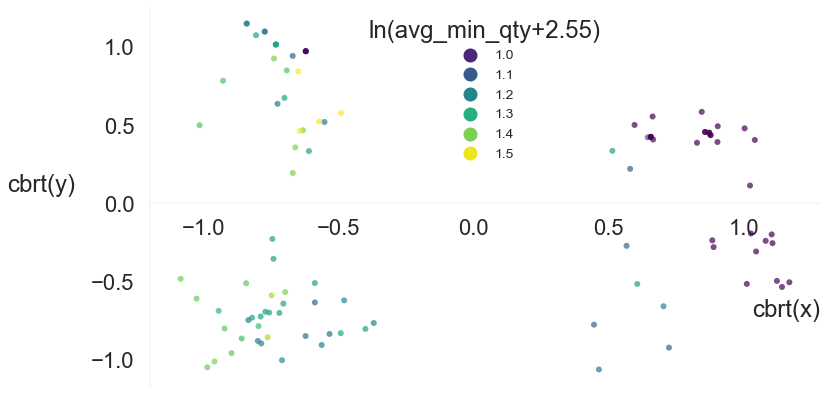

In [92]:
sns.scatterplot(
    x=pca_df_explore6["cbrt(x)"],
    y=pca_df_explore6["cbrt(y)"],
    hue=np.log(pca_df_explore6["avg_min_qty"] + 2.55),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="ln(avg_min_qty+2.55)"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

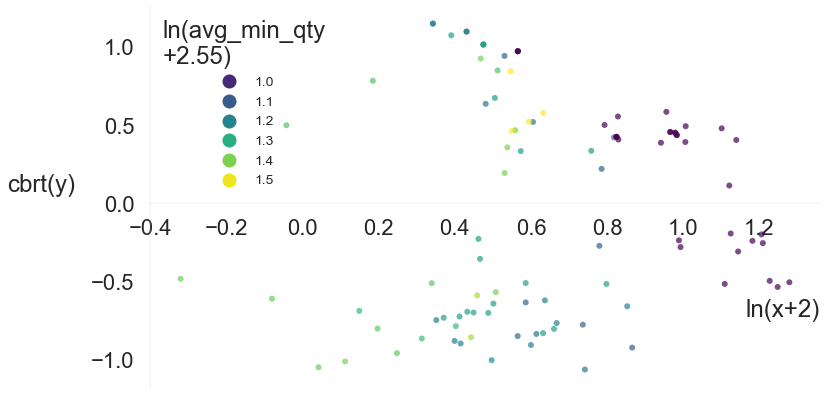

In [93]:
sns.scatterplot(
    x=pca_df_explore6["ln(x+2)"],
    y=pca_df_explore6["cbrt(y)"],
    hue=np.log(pca_df_explore6["avg_min_qty"] + 2.55),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper left", fontsize="xx-small", title="ln(avg_min_qty\n+2.55)"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=60)

plt.show()

In [94]:
print("The plot above reveals customer records of similar hue in proximity with one another.")
print("The minimum quantity of the deal could be partially informative of similarity.")

The plot above reveals customer records of similar hue in proximity with one another.
The minimum quantity of the deal could be partially informative of similarity.


In [95]:
merge_discount = (
    df_offers.merge(df_transactions)[["customer_name", "discount"]]
    .pivot_table(index="customer_name")
    .reset_index()
    .rename(columns={"discount": "avg_discount%"})
)
merge_discount

customer_name  avg_discount%
0          Adams      63.666667
1          Allen      72.500000
2       Anderson      58.500000
3         Bailey      47.000000
4          Baker      61.750000
..           ...            ...
95      Williams      67.333333
96        Wilson      49.500000
97          Wood      65.250000
98        Wright      68.000000
99         Young      59.833333

[100 rows x 2 columns]

In [96]:
pca_df_explore7 = pca_df_explore6.merge(merge_discount, on="customer_name")
pca_df_explore7

customer_name  1  2  3  4  5  6  7  8  9  ...   cbrt(x)   cbrt(y)  \
0          Adams  0  0  0  0  0  0  0  0  0  ...  1.002520  0.476536   
1          Allen  0  0  0  0  0  0  0  0  1  ... -0.660033  0.354936   
2       Anderson  0  0  0  0  0  0  0  0  0  ... -0.731881  1.012637   
3         Bailey  0  0  0  0  0  0  1  0  0  ...  0.887683 -0.282487   
4          Baker  0  0  0  0  0  0  1  0  0  ...  0.445105 -0.778432   
..           ... .. .. .. .. .. .. .. .. ..  ...       ...       ...   
95      Williams  0  0  0  0  0  0  0  0  0  ... -0.533289 -0.837698   
96        Wilson  0  0  0  0  0  0  0  1  0  ...  0.882897 -0.239209   
97          Wood  1  0  0  0  0  0  0  0  0  ... -0.819924 -0.734138   
98        Wright  0  0  0  1  0  1  0  0  0  ... -0.788269 -0.726411   
99         Young  0  0  0  0  0  1  0  0  1  ... -0.959007 -1.013740   

     ln(x+2)  offers_completed  past_peak_true_pct  origin_component  \
0   1.101136                 3            0.000000          0.752645   
1   0.537931                 2            0.000000         -1.187083   
2   0.474971                 2            0.000000         -1.341977   
3   0.993058                 2            0.500000         -0.310041   
4   0.736294                 4            0.250000         -0.372520   
..       ...               ...                 ...               ...   
95  0.614285                 3            0.000000          0.752645   
96  0.988881                 2            0.000000         -0.259379   
97  0.370725                 4            0.000000          0.789948   
98  0.412239                 4            0.250000         -0.205255   
99  0.111547                 6            0.166667          0.744310   

    quarter_component  varietal_component  avg_min_qty  avg_discount%  
0           -0.778866           -0.668227     0.000000      63.666667  
1           -1.022397            0.258281     1.500000      72.500000  
2           -0.847061           -1.554218     1.000000      58.500000  
3            0.038764           -0.415064     0.000000      47.000000  
4            0.071125            1.437889     0.500000      61.750000  
..                ...                 ...          ...            ...  
95          -0.743212            1.054180     0.666667      67.333333  
96           0.038764           -0.608809     0.000000      49.500000  
97          -0.104211            0.441999     1.000000      65.250000  
98           1.132287            2.086092     1.000000      68.000000  
99           0.067832            1.670477     1.500000      59.833333  

[100 rows x 43 columns]

In [97]:
print(pca_df_explore7["avg_discount%"].skew())
print("average discount of the deal is a little bit positively skewed")
print("skew after sqrt", np.sqrt(pca_df_explore7["avg_discount%"]).skew())
print("skew after ln(x+1)", np.log(pca_df_explore7["avg_discount%"] + 1).skew())
print("skew after ln(x+0.0001)", np.log(pca_df_explore7["avg_discount%"] + 0.0001).skew())
print("skew after ln(x+10)", np.log(pca_df_explore7["avg_discount%"] + 10).skew())
print("skew after ln(x+1000)", np.log(pca_df_explore7["avg_discount%"] + 1000).skew())
pca_df_explore7["avg_discount%"].describe()

0.08486317996314988
average discount of the deal is a little bit positively skewed
skew after sqrt -0.24289972611732044
skew after ln(x+1) -0.6102902583416344
skew after ln(x+0.0001) -0.6274984273501348
skew after ln(x+10) -0.4896340134012566
skew after ln(x+1000) 0.051852936234414115


count    100.000000
mean      58.719952
std       11.774260
min       25.500000
25%       49.458333
50%       58.678571
75%       66.000000
max       89.000000
Name: avg_discount%, dtype: float64

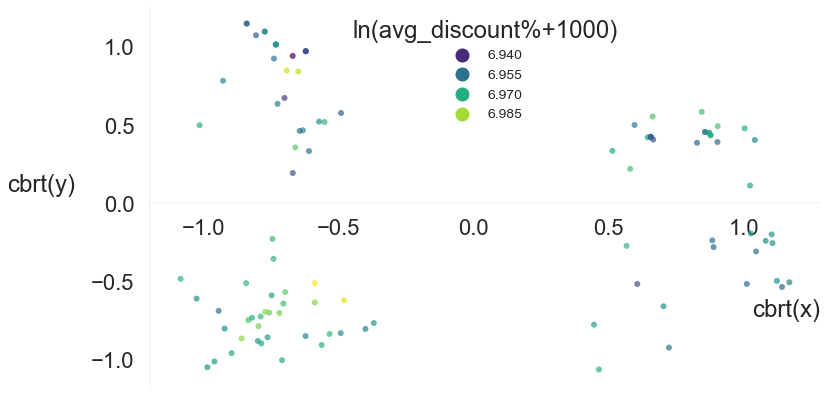

In [98]:
sns.scatterplot(
    x=pca_df_explore7["cbrt(x)"],
    y=pca_df_explore7["cbrt(y)"],
    hue=np.log(pca_df_explore7["avg_discount%"] + 1000),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="ln(avg_discount%+1000)"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

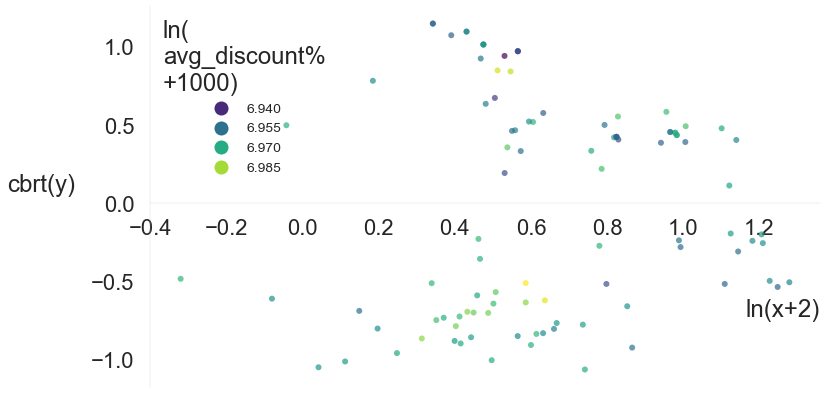

In [99]:
sns.scatterplot(
    x=pca_df_explore7["ln(x+2)"],
    y=pca_df_explore7["cbrt(y)"],
    hue=np.log(pca_df_explore7["avg_discount%"] + 1000),
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="viridis",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper left", fontsize="xx-small", title="ln(\navg_discount%\n+1000)"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=60)

plt.show()

In [100]:
print("The plot above reveals customer records of similar hue in proximity with one another.")
print("The discount percentage could be partially informative of similarity.")

The plot above reveals customer records of similar hue in proximity with one another.
The discount percentage could be partially informative of similarity.


In [101]:
print(
    "At this point, we have crafted new features representing aspects of the deals completed per customer."
)
print(
    "We were interested in seeing whether those aspects were useful for customer segmentation."
)
print()
print("Some of these were crafted by converting one-hot features to single components.")
print(
    "We can similarly reduce the one-hot features representing the deals completed to a single component."
)
print()
print("Next, we can train a regressor to predict the new component (deals completed).")
print(
    "In so doing, we may better understand how the new features could help segment the new component (deals completed)."
)

At this point, we have crafted new features representing aspects of the deals completed per customer.
We were interested in seeing whether those aspects were useful for customer segmentation.

Some of these were crafted by converting one-hot features to single components.
We can similarly reduce the one-hot features representing the deals completed to a single component.

Next, we can train a regressor to predict the new component (deals completed).
In so doing, we may better understand how the new features could help segment the new component (deals completed).


In [102]:
# craft a new dataframe with a single component for the deals completed
pca_df_explore8 = pca_df_explore7[
    [
        "offers_completed",
        "past_peak_true_pct",
        "origin_component",
        "quarter_component",
        "varietal_component",
        "avg_min_qty",
        "avg_discount%",
    ]
].copy()
pca_df_explore8["deals_component"] = PCA(
    n_components=1, random_state=2021
).fit_transform(matrix.drop("customer_name", axis="columns"))
pca_df_explore8

offers_completed  past_peak_true_pct  origin_component  quarter_component  \
0                  3            0.000000          0.752645          -0.778866   
1                  2            0.000000         -1.187083          -1.022397   
2                  2            0.000000         -1.341977          -0.847061   
3                  2            0.500000         -0.310041           0.038764   
4                  4            0.250000         -0.372520           0.071125   
..               ...                 ...               ...                ...   
95                 3            0.000000          0.752645          -0.743212   
96                 2            0.000000         -0.259379           0.038764   
97                 4            0.000000          0.789948          -0.104211   
98                 4            0.250000         -0.205255           1.132287   
99                 6            0.166667          0.744310           0.067832   

    varietal_component  avg_min_qty  avg_discount%  deals_component  
0            -0.668227     0.000000      63.666667         1.007580  
1             0.258281     1.500000      72.500000        -0.287539  
2            -1.554218     1.000000      58.500000        -0.392032  
3            -0.415064     0.000000      47.000000         0.699477  
4             1.437889     0.500000      61.750000         0.088183  
..                 ...          ...            ...              ...  
95            1.054180     0.666667      67.333333        -0.151666  
96           -0.608809     0.000000      49.500000         0.688224  
97            0.441999     1.000000      65.250000        -0.551215  
98            2.086092     1.000000      68.000000        -0.489805  
99            1.670477     1.500000      59.833333        -0.881994  

[100 rows x 8 columns]

In [103]:
print("Next, several forest models are assessed via nested cross validation.")
print(
    "We can refit the best model on the whole dataset and use the built-in feature importance of forest methods."
)

Next, several forest models are assessed via nested cross validation.
We can refit the best model on the whole dataset and use the built-in feature importance of forest methods.


In [104]:
from scipy.stats import uniform
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
)
from sklearn.ensemble import RandomForestRegressor

In [105]:
%%cache quick_rf_score.pkl quick_rf_score
quick_rf_score = cross_val_score(
    estimator=RandomForestRegressor(random_state=2021, n_jobs=-1),
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    n_jobs=-1,
)

[Skipped the cell's code and loaded variables quick_rf_score from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\quick_rf_score.pkl'.]


In [106]:
print(
    "quick rf explained variance: {:.3f} ({:.3f})".format(
        np.mean(quick_rf_score), np.std(quick_rf_score)
    )
)

quick rf explained variance: 0.880 (0.067)


In [107]:
print("Score to beat:", 0.880)

Score to beat: 0.88


In [108]:
%%cache forest_search.pkl forest_search
forest_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=2021, n_jobs=-1),
    param_distributions={
        "n_estimators": list(range(5, 500)),
        "criterion": ["mse", "mae"],
        "max_depth": [None] + list(range(1, 101)),
        "min_samples_split": list(range(2, 101)),
        "min_samples_leaf": list(range(1, 101)),
        "min_weight_fraction_leaf": uniform(0, 0.5),
        "max_features": ["sqrt", "log2", "auto"],
        "max_leaf_nodes": [None] + list(range(2, 101)),
    },
    n_iter=50,
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    verbose=10,
    random_state=2021,
    n_jobs=-1,
).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables forest_search from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\forest_search.pkl'.]
Fitting 50 folds for each of 50 candidates, totalling 2500 fits


In [109]:
print(forest_search.best_estimator_)
print(forest_search.best_params_)
print(forest_search.best_score_)

RandomForestRegressor(max_depth=58, max_leaf_nodes=55, min_samples_leaf=8,
                      min_samples_split=6,
                      min_weight_fraction_leaf=0.22251550623181104,
                      n_estimators=97, n_jobs=-1, random_state=2021)
{'criterion': 'mse', 'max_depth': 58, 'max_features': 'auto', 'max_leaf_nodes': 55, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.22251550623181104, 'n_estimators': 97}
0.6540451987759913


In [110]:
print("Score to beat:", 0.880)

Score to beat: 0.88


In [111]:
%%cache forest_search2.pkl forest_search2
forest_search2 = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=2021, n_jobs=-1),
    param_distributions={
        "n_estimators": list(range(5, 500)),
        "criterion": ["mse", "mae"],
        "max_features": ["sqrt", "log2", "auto"],
    },
    n_iter=50,
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    verbose=10,
    random_state=2021,
    n_jobs=-1,
).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables forest_search2 from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\forest_search2.pkl'.]
Fitting 50 folds for each of 50 candidates, totalling 2500 fits


In [112]:
print(forest_search2.best_estimator_)
print(forest_search2.best_params_)
print(forest_search2.best_score_)

RandomForestRegressor(n_estimators=333, n_jobs=-1, random_state=2021)
{'n_estimators': 333, 'max_features': 'auto', 'criterion': 'mse'}
0.8827941955250018


In [113]:
print("Score to beat:", 0.8827941955250018)

Score to beat: 0.8827941955250018


In [114]:
%%cache forest_search3.pkl forest_search3
forest_search3 = RandomizedSearchCV(
    estimator=RandomForestRegressor(
        random_state=2021, n_jobs=-1, criterion="mse", max_features="auto"
    ),
    param_distributions={
        "n_estimators": list(range(50, 400)),
        "min_samples_split": list(range(2, 16)),
        "min_samples_leaf": list(range(1, 21)),
    },
    n_iter=50,
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    verbose=10,
    random_state=2021,
    n_jobs=-1,
).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables forest_search3 from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\forest_search3.pkl'.]
Fitting 50 folds for each of 50 candidates, totalling 2500 fits


In [115]:
print(forest_search3.best_estimator_)
print(forest_search3.best_params_)
print(forest_search3.best_score_)

RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=301,
                      n_jobs=-1, random_state=2021)
{'n_estimators': 301, 'min_samples_split': 5, 'min_samples_leaf': 2}
0.8715970218919834


In [116]:
print("Score to beat:", 0.8827941955250018)

Score to beat: 0.8827941955250018


In [117]:
%%cache forest_search4.pkl forest_search4
forest_search4 = RandomizedSearchCV(
    estimator=RandomForestRegressor(
        random_state=2021, n_jobs=-1, criterion="mse", max_features="auto"
    ),
    param_distributions={
        "n_estimators": list(range(50, 400)),
        "max_depth": [None] + list(range(1, 101)),
        "max_leaf_nodes": [None] + list(range(2, 101)),
        "min_samples_leaf": list(range(1, 11)),
        "min_samples_split": list(range(2, 11)),
        "min_weight_fraction_leaf": uniform(0, 0.5),
    },
    n_iter=50,
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    verbose=10,
    random_state=2021,
    n_jobs=-1,
).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables forest_search4 from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\forest_search4.pkl'.]
Fitting 50 folds for each of 50 candidates, totalling 2500 fits


In [118]:
print(forest_search4.best_estimator_)
print(forest_search4.best_params_)
print(forest_search4.best_score_)

RandomForestRegressor(max_depth=48, max_leaf_nodes=62, min_samples_split=6,
                      min_weight_fraction_leaf=0.031551665295687314,
                      n_estimators=267, n_jobs=-1, random_state=2021)
{'max_depth': 48, 'max_leaf_nodes': 62, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.031551665295687314, 'n_estimators': 267}
0.8634805915525474


In [119]:
print("Score to beat:", 0.8827941955250018)

Score to beat: 0.8827941955250018


In [120]:
%%cache forest_search5.pkl forest_search5
forest_search5 = RandomizedSearchCV(
    estimator=RandomForestRegressor(
        random_state=2021, n_jobs=-1, criterion="mse", max_features="auto"
    ),
    param_distributions={
        "n_estimators": list(range(60, 400)),
        "max_depth": [None] + list(range(20, 81)),
        "max_leaf_nodes": [None] + list(range(20, 81)),
        "min_samples_leaf": list(range(1, 11)),
        "min_samples_split": list(range(2, 11)),
        "min_weight_fraction_leaf": uniform(0, 0.4),
    },
    n_iter=50,
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    verbose=10,
    random_state=2021,
    n_jobs=-1,
).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables forest_search5 from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\forest_search5.pkl'.]
Fitting 50 folds for each of 50 candidates, totalling 2500 fits


In [121]:
print(forest_search5.best_estimator_)
print(forest_search5.best_params_)
print(forest_search5.best_score_)

RandomForestRegressor(max_depth=67, max_leaf_nodes=65, min_samples_split=6,
                      min_weight_fraction_leaf=0.025241332236549854,
                      n_estimators=277, n_jobs=-1, random_state=2021)
{'max_depth': 67, 'max_leaf_nodes': 65, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.025241332236549854, 'n_estimators': 277}
0.8634580437652337


In [122]:
print("Score to beat:", 0.8827941955250018)

Score to beat: 0.8827941955250018


In [123]:
from scipy.stats import randint

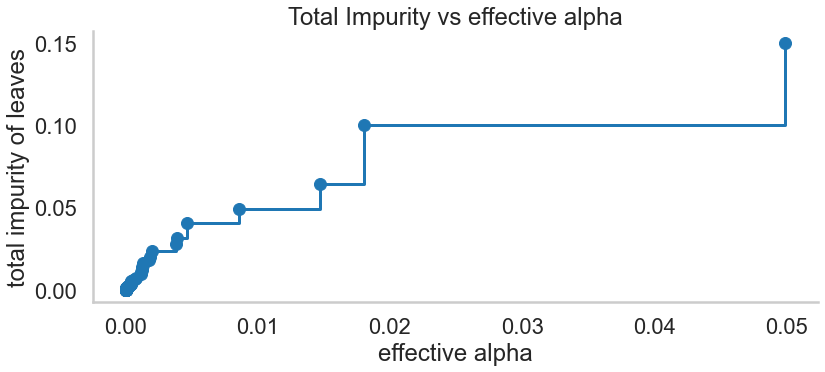

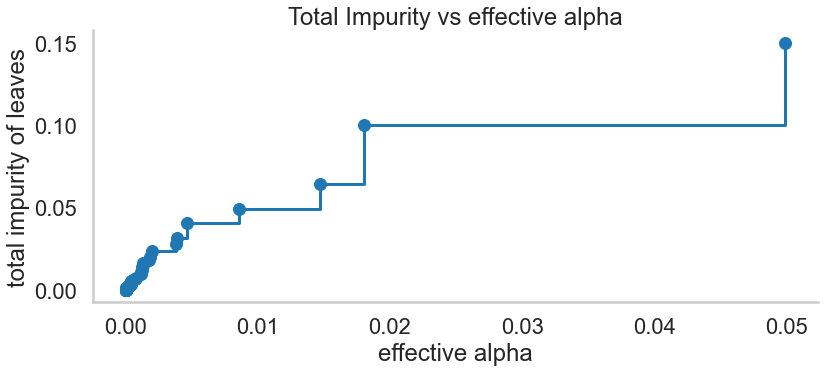

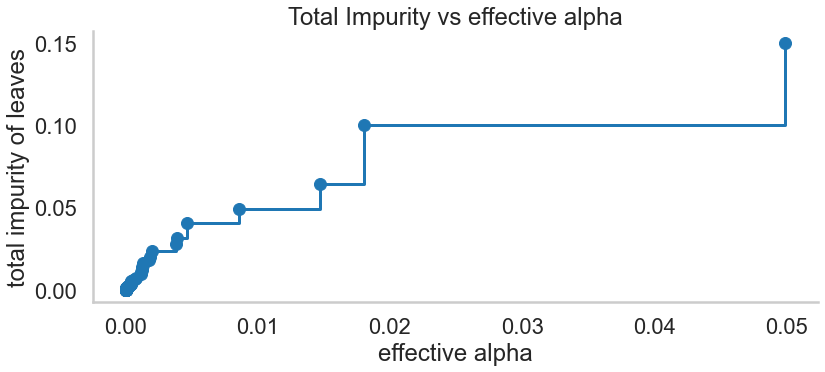

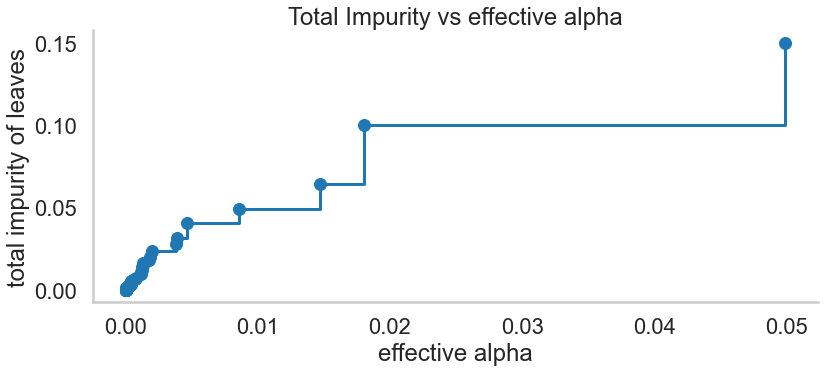

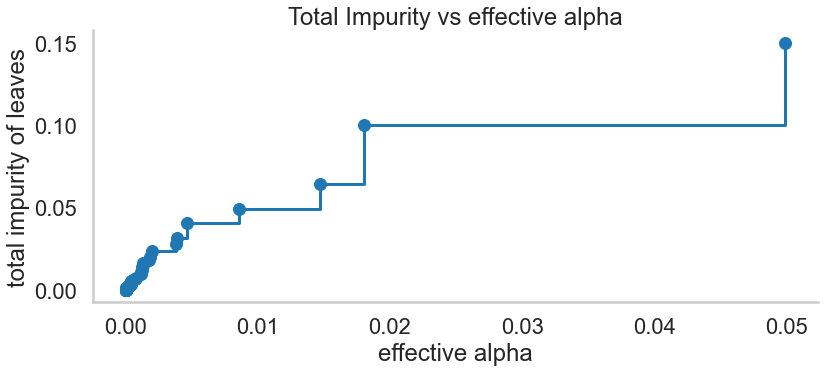

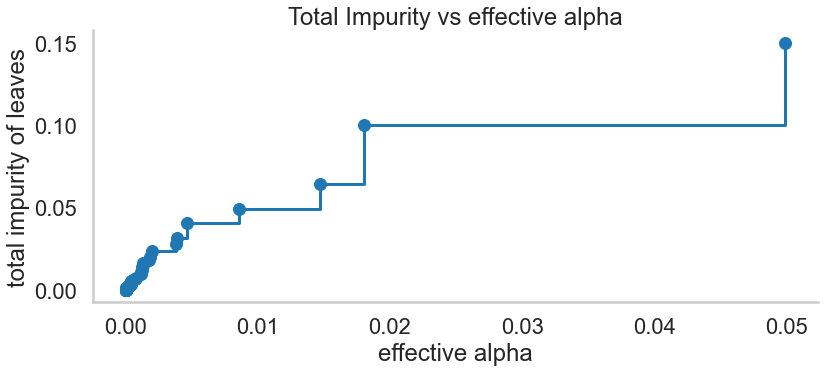

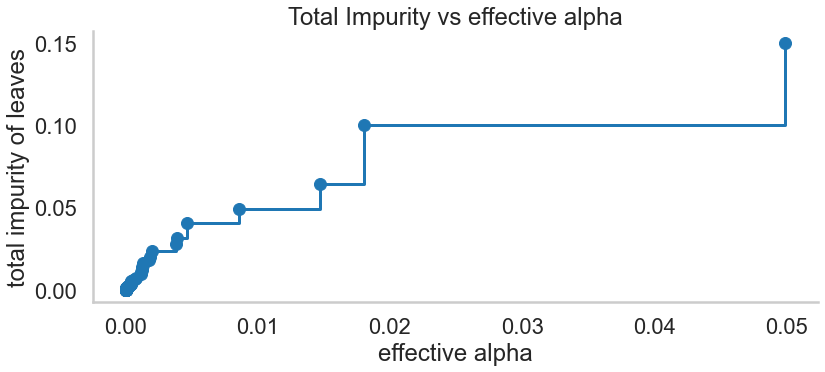

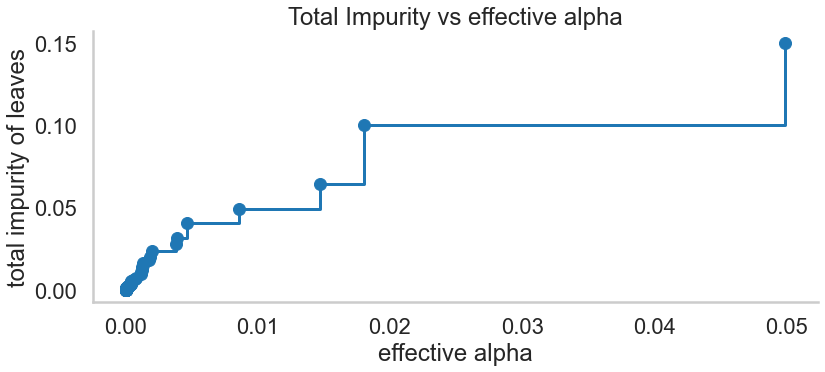

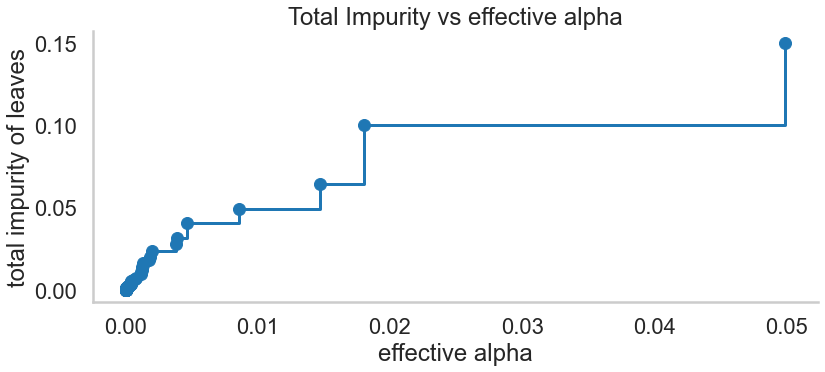

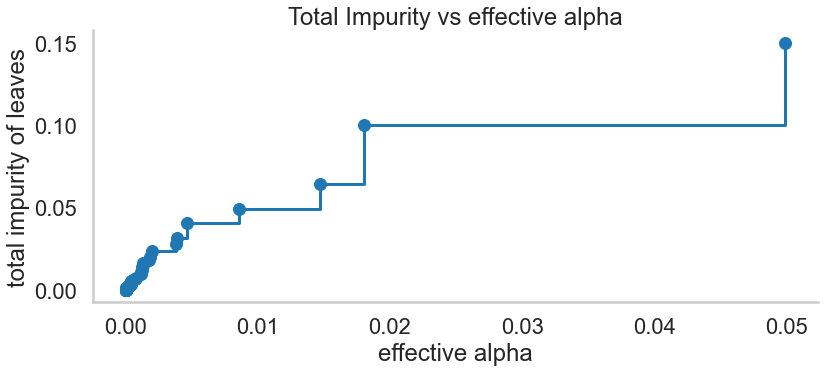

In [124]:
# for tuning ccp_alpha
for i in randint.rvs(
    low=0,
    high=len(forest_search2.best_estimator_.estimators_),
    size=10,
    random_state=2021,
):
    path = forest_search2.best_estimator_.estimators_[i].cost_complexity_pruning_path(
        pca_df_explore8.drop("deals_component", axis="columns"),
        pca_df_explore8["deals_component"],
    )
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    fig, ax = plt.subplots(figsize=(13, 5))
    # the root node of the tree (indexed with [:-1]) is left out of the analysis, as without it there wouldn't be a tree
    ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
    ax.set_xlabel("effective alpha")
    ax.set_ylabel("total impurity of leaves")
    ax.set_title("Total Impurity vs effective alpha")
    plt.grid(False)
    ax.spines[["right", "top"]].set_visible(False)
    plt.show()

In [125]:
%%cache forest_search6.pkl forest_search6
forest_search6 = RandomizedSearchCV(
    estimator=RandomForestRegressor(
        random_state=2021, n_jobs=-1, criterion="mse", max_features="auto"
    ),
    param_distributions={
        "n_estimators": list(range(70, 400)),
        "max_depth": [None] + list(range(40, 71)),
        "max_leaf_nodes": [None] + list(range(40, 71)),
        "min_samples_leaf": list(range(1, 11)),
        "min_samples_split": list(range(2, 11)),
        "min_weight_fraction_leaf": uniform(0, 0.3),
        "ccp_alpha": uniform(0.00, 0.01),
    },
    n_iter=50,
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    verbose=10,
    random_state=2021,
    n_jobs=-1,
).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables forest_search6 from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\forest_search6.pkl'.]
Fitting 50 folds for each of 50 candidates, totalling 2500 fits


In [126]:
print(forest_search6.best_estimator_)
print(forest_search6.best_params_)
print(forest_search6.best_score_)

RandomForestRegressor(ccp_alpha=0.0009086690147631804, max_depth=55,
                      max_leaf_nodes=53, min_samples_split=6,
                      min_weight_fraction_leaf=0.018930999177412387,
                      n_estimators=287, n_jobs=-1, random_state=2021)
{'ccp_alpha': 0.0009086690147631804, 'max_depth': 55, 'max_leaf_nodes': 53, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.018930999177412387, 'n_estimators': 287}
0.8679215605931242


In [127]:
print("Score to beat:", 0.8827941955250018)

Score to beat: 0.8827941955250018


In [128]:
%%cache forest_search7.pkl forest_search7
forest_search7 = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=2021, n_jobs=-1),
    param_distributions={
        "n_estimators": list(range(5, 500)),
        "criterion": ["mse", "mae"],
        "max_features": ["sqrt", "log2", "auto"],
        "ccp_alpha": uniform(0.00, 0.01),
    },
    n_iter=50,
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    verbose=10,
    random_state=2021,
    n_jobs=-1,
).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables forest_search7 from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\forest_search7.pkl'.]
Fitting 50 folds for each of 50 candidates, totalling 2500 fits


In [129]:
print(forest_search7.best_estimator_)
print(forest_search7.best_params_)
print(forest_search7.best_score_)

RandomForestRegressor(ccp_alpha=0.004172572344628316, criterion='mae',
                      n_estimators=246, n_jobs=-1, random_state=2021)
{'ccp_alpha': 0.004172572344628316, 'criterion': 'mae', 'max_features': 'auto', 'n_estimators': 246}
0.8764870218035777


In [130]:
print("Score to beat:", 0.8827941955250018)

Score to beat: 0.8827941955250018


In [131]:
from sklearn.neighbors import LocalOutlierFactor

lof_data = pca_df_explore8.drop("deals_component", axis="columns")
cols = lof_data.columns

uni_outliers = {_: LocalOutlierFactor().fit_predict(lof_data[[_]]) for _ in cols}
mask = LocalOutlierFactor().fit_predict(lof_data)

for var in cols:
    lof_data.loc[:, var + "-out"] = uni_outliers[var]
lof_data = lof_data[mask == -1]

lof_data

offers_completed  past_peak_true_pct  origin_component  quarter_component  \
29                 3                0.00         -1.398921          -1.093885   
52                 2                0.00          0.767671           0.960244   
60                 2                0.00         -0.276635          -0.847061   
62                 5                0.00          1.710559          -0.921842   
74                 1                0.00         -0.225325          -0.950909   
79                 1                0.00         -1.303037          -0.950909   
83                 2                0.00         -0.264264           0.074419   
90                 4                0.25          0.798908           1.096633   

    varietal_component  avg_min_qty  avg_discount%  offers_completed-out  \
29           -0.877438     1.333333      84.666667                    -1   
52           -1.072950     1.000000      36.500000                     1   
60            1.057960     0.500000      77.500000                     1   
62            1.209469     0.800000      86.200000                    -1   
74            0.219792     1.000000      89.000000                    -1   
79           -1.086297     2.000000      83.000000                    -1   
83           -1.554218     0.500000      25.500000                     1   
90            2.086092     1.250000      77.750000                     1   

    past_peak_true_pct-out  origin_component-out  quarter_component-out  \
29                       1                     1                     -1   
52                       1                     1                     -1   
60                       1                     1                      1   
62                       1                    -1                      1   
74                       1                     1                      1   
79                       1                     1                      1   
83                       1                     1                      1   
90                       1                     1                     -1   

    varietal_component-out  avg_min_qty-out  avg_discount%-out  
29                      -1                1                 -1  
52                      -1                1                 -1  
60                       1                1                 -1  
62                       1                1                 -1  
74                       1                1                 -1  
79                      -1                1                 -1  
83                      -1                1                 -1  
90                       1                1                 -1

In [132]:
%%cache forest_search8.pkl forest_search8
forest_search8 = RandomizedSearchCV(
    estimator=RandomForestRegressor(
        random_state=2021, n_jobs=-1, criterion="mse", max_features="auto"
    ),
    param_distributions={
        "n_estimators": list(range(5, 500)),
        "ccp_alpha": uniform(0.00, 0.01),
    },
    n_iter=50,
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    verbose=10,
    random_state=2021,
    n_jobs=-1,
).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables forest_search8 from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\forest_search8.pkl'.]
Fitting 50 folds for each of 50 candidates, totalling 2500 fits


In [133]:
print(forest_search8.best_estimator_)
print(forest_search8.best_params_)
print(forest_search8.best_score_)

RandomForestRegressor(ccp_alpha=8.297523505430116e-05, n_estimators=401,
                      n_jobs=-1, random_state=2021)
{'ccp_alpha': 8.297523505430116e-05, 'n_estimators': 401}
0.8822082279182437


In [134]:
print("Score to beat:", 0.8827941955250018)

Score to beat: 0.8827941955250018


In [135]:
%%cache forest_search9.pkl forest_search9
forest_search9 = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=2021, n_jobs=-1, criterion="mse", max_features="auto"
    ),
    param_grid={"n_estimators": list(range(5, 500))},
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    verbose=10,
    n_jobs=-1,
).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables forest_search9 from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\forest_search9.pkl'.]
Fitting 50 folds for each of 495 candidates, totalling 24750 fits


In [136]:
print(forest_search9.best_estimator_)
print(forest_search9.best_params_)
print(forest_search9.best_score_)

RandomForestRegressor(n_estimators=307, n_jobs=-1, random_state=2021)
{'n_estimators': 307}
0.8828992169047344


In [137]:
print("Score to beat:", 0.8828992169047344)

Score to beat: 0.8828992169047344


In [138]:
%%cache forest_search10.pkl forest_search10
forest_search10 = RandomizedSearchCV(
    estimator=RandomForestRegressor(
        random_state=2021, n_jobs=-1, criterion="mse", max_features="auto"
    ),
    param_distributions={
        "n_estimators": list(range(70, 500)),
        "ccp_alpha": uniform(0.000, 0.005),
    },
    n_iter=50,
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    verbose=10,
    random_state=2021,
    n_jobs=-1,
).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables forest_search10 from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\forest_search10.pkl'.]
Fitting 50 folds for each of 50 candidates, totalling 2500 fits


In [139]:
print(forest_search10.best_estimator_)
print(forest_search10.best_params_)
print(forest_search10.best_score_)

RandomForestRegressor(ccp_alpha=5.822826955420024e-06, n_estimators=473,
                      n_jobs=-1, random_state=2021)
{'ccp_alpha': 5.822826955420024e-06, 'n_estimators': 473}
0.8825290963276842


In [140]:
print("Score to beat:", 0.8828992169047344)

Score to beat: 0.8828992169047344


In [141]:
%%cache forest_search11.pkl forest_search11
forest_search11 = RandomizedSearchCV(
    estimator=RandomForestRegressor(
        random_state=2021, n_jobs=-1, criterion="mae", max_features="auto"
    ),
    param_distributions={
        "n_estimators": list(range(70, 500)),
        "ccp_alpha": uniform(0.000, 0.005),
    },
    n_iter=50,
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    verbose=10,
    random_state=2021,
    n_jobs=-1,
).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables forest_search11 from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\forest_search11.pkl'.]
Fitting 50 folds for each of 50 candidates, totalling 2500 fits


In [142]:
print(forest_search11.best_estimator_)
print(forest_search11.best_params_)
print(forest_search11.best_score_)

RandomForestRegressor(ccp_alpha=0.00031551665295687315, criterion='mae',
                      n_estimators=287, n_jobs=-1, random_state=2021)
{'ccp_alpha': 0.00031551665295687315, 'n_estimators': 287}
0.8822583304123461


In [143]:
print("Score to beat:", 0.8828992169047344)

Score to beat: 0.8828992169047344


In [144]:
import catboost as cb

In [145]:
%%cache catboost_model.pkl catboost_model
catboost_model = cross_val_score(
    estimator=cb.CatBoostRegressor(
        random_state=2021,
    ),
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
    scoring="explained_variance",
    cv=RepeatedKFold(random_state=2021),
    n_jobs=-1,
)

[Skipped the cell's code and loaded variables catboost_model from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\catboost_model.pkl'.]


In [146]:
print(
    "catboost explained variance: {:.3f} ({:.3f})".format(
        np.mean(catboost_model), np.std(catboost_model)
    )
)
print("This is the best score yet!")

catboost explained variance: 0.907 (0.055)
This is the best score yet!


In [147]:
%%cache catboost_explainer.pkl catboost_explainer
catboost_explainer = cb.CatBoostRegressor(random_state=2021, thread_count=-1).fit(
    X=pca_df_explore8.drop("deals_component", axis="columns"),
    y=pca_df_explore8["deals_component"],
)

[Skipped the cell's code and loaded variables catboost_explainer from file 'C:\Users\michen\OneDrive - University of North Carolina at Chapel Hill\Desktop\Springboard\Springboard\mec-16.2.6-clustering-mini-project\catboost_explainer.pkl'.]
Learning rate set to 0.025906
0:	learn: 0.6266620	total: 146ms	remaining: 2m 25s
1:	learn: 0.6167257	total: 149ms	remaining: 1m 14s
2:	learn: 0.6068671	total: 153ms	remaining: 50.7s
3:	learn: 0.5988156	total: 157ms	remaining: 39s
4:	learn: 0.5898826	total: 161ms	remaining: 32s
5:	learn: 0.5812795	total: 164ms	remaining: 27.2s
6:	learn: 0.5734619	total: 167ms	remaining: 23.7s
7:	learn: 0.5669968	total: 171ms	remaining: 21.2s
8:	learn: 0.5584127	total: 174ms	remaining: 19.2s
9:	learn: 0.5504828	total: 177ms	remaining: 17.5s
10:	learn: 0.5420523	total: 180ms	remaining: 16.2s
11:	learn: 0.5333594	total: 184ms	remaining: 15.1s
12:	learn: 0.5259014	total: 188ms	remaining: 14.3s
13:	learn: 0.5184552	total: 190ms	remaining: 13.4s
14:	learn: 0.5104730	total: 

In [148]:
print("catboost on full dataset explained variance score:")
sklearn.metrics.explained_variance_score(
    y_true=pca_df_explore8["deals_component"],
    y_pred=catboost_explainer.predict(
        pca_df_explore8.drop("deals_component", axis="columns")
    ),
)

catboost on full dataset explained variance score:


0.9998480893900943

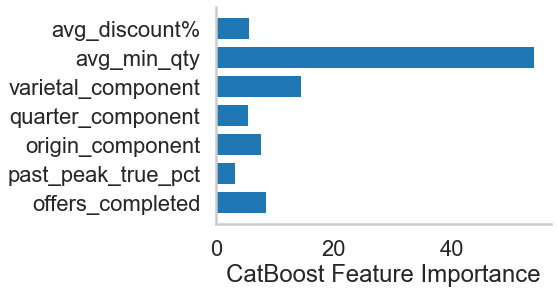

In [149]:
plt.barh(
    pca_df_explore8.drop("deals_component", axis="columns").columns,
    catboost_explainer.feature_importances_,
)
plt.xlabel("CatBoost Feature Importance")
plt.grid(False)
plt.gca().spines[["right", "top"]].set_visible(False)
plt.show()

In [150]:
print(
    "The average minimum quantity of deals completed may be particularly useful for customer segmentation."
)
print(
    "The plot confirms that the past_peak_true_pct may be less informative than the other crafted features."
)

The average minimum quantity of deals completed may be particularly useful for customer segmentation.
The plot confirms that the past_peak_true_pct may be less informative than the other crafted features.


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [151]:
# your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)

PCA()

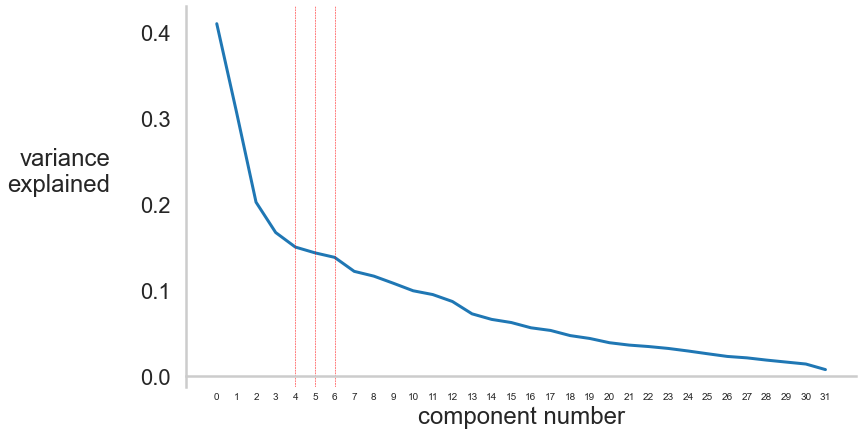

In [152]:
pca_new = PCA(n_components=None, random_state=2021).fit(data).explained_variance_

sns.lineplot(x=range(len(pca_new)), y=pca_new)
ax = plt.gca()

plt.grid(False)
plt.gcf().set_size_inches(12, 7)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")

plt.xlabel("component number")
plt.xticks(np.arange(0, len(data.columns), 1), fontsize=10)

plt.ylabel(
    "variance\nexplained", labelpad=30, horizontalalignment="right"
).set_rotation(0)

for i in {4, 5, 6}:
    make_vline(i)

plt.show()

In [153]:
print("The slope is nearly flat between component number 4 and 6.")

The slope is nearly flat between component number 4 and 6.


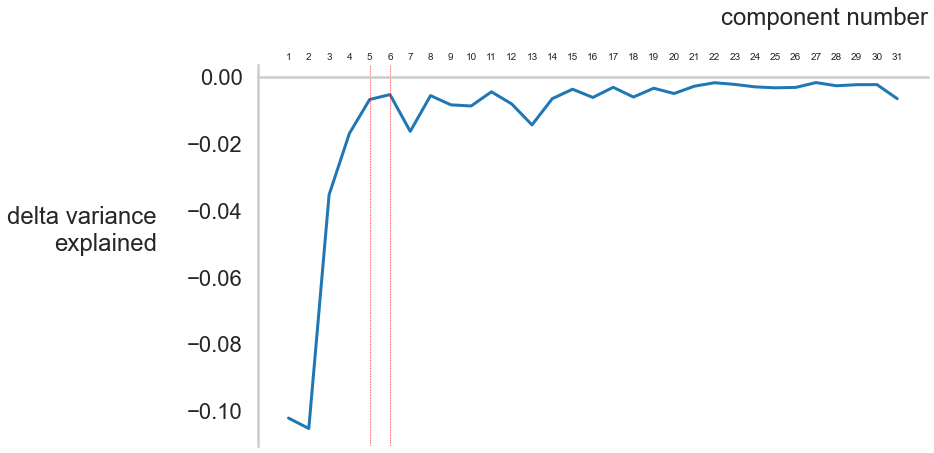

In [154]:
delta_variance = pca_new[1:] - pca_new[:-1]

sns.lineplot(x=range(1, len(pca_new)), y=delta_variance)
plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
plt.grid(False)

plt.xlabel("component number", loc="right", labelpad=-70)
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_tick_params(length=0, width=0)
plt.xticks(np.arange(1, len(data.columns), 1), fontsize=10)

plt.ylabel(
    "delta variance\nexplained", labelpad=30, horizontalalignment="right"
).set_rotation(0)

make_vline(5)
make_vline(6)

plt.show()

In [155]:
print("The slope of the previous chart is negative for each component number.")
print(
    "The slope of the previous chart moves towards zero between component numbers 2 and 6."
)

The slope of the previous chart is negative for each component number.
The slope of the previous chart moves towards zero between component numbers 2 and 6.


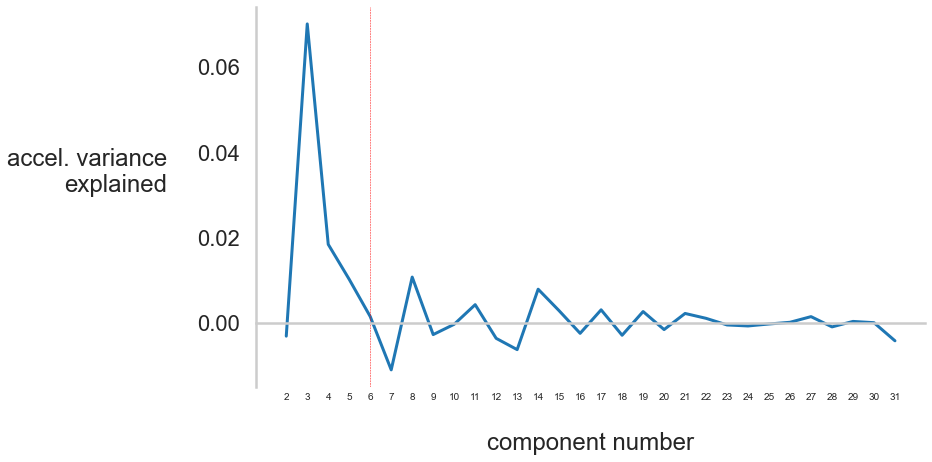

In [156]:
delta_variance2 = delta_variance[1:] - delta_variance[:-1]

sns.lineplot(x=range(2, len(pca_new)), y=delta_variance2)
plt.gcf().set_size_inches(12, 7)
ax = plt.gca()
plt.grid(False)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")

plt.xlabel("component number", labelpad=30)
ax.xaxis.set_tick_params(length=0, width=0, pad=70)
plt.xticks(np.arange(2, len(data.columns), 1), fontsize=10)

plt.ylabel(
    "accel. variance\nexplained", labelpad=30, horizontalalignment="right"
).set_rotation(0)

make_vline(6)

plt.show()

In [157]:
# look for the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?
print(
    "The change in slope of the component # vs. variance explained plot is close to zero at component 6."
)
print("Component #6 corresponds to the 7th dimension.")

The change in slope of the component # vs. variance explained plot is close to zero at component 6.
Component #6 corresponds to the 7th dimension.


## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [158]:
# Your turn
from sklearn.cluster import (
    AgglomerativeClustering,
    AffinityPropagation,
    DBSCAN,
    SpectralClustering,
)

In [159]:
ap_df = pca_df[["x", "y"]].copy()
ap_df["cluster_id"] = AffinityPropagation(random_state=2021).fit_predict(ap_df[["x", "y"]])

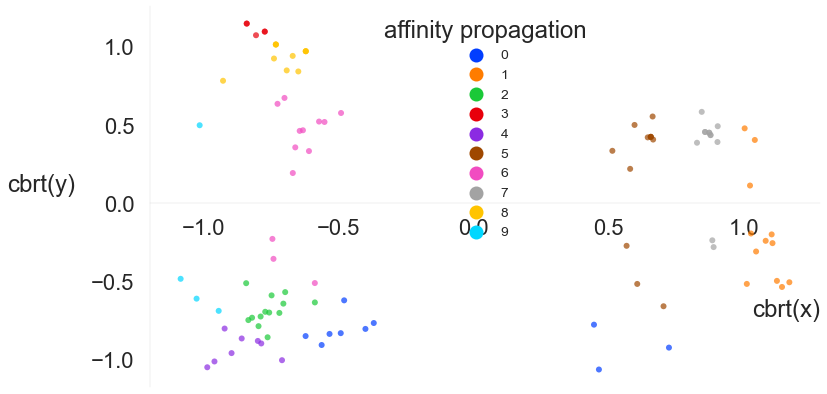

In [160]:
sns.scatterplot(
    x=np.cbrt(ap_df.x),
    y=np.cbrt(ap_df.y),
    hue=ap_df.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="affinity propagation"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

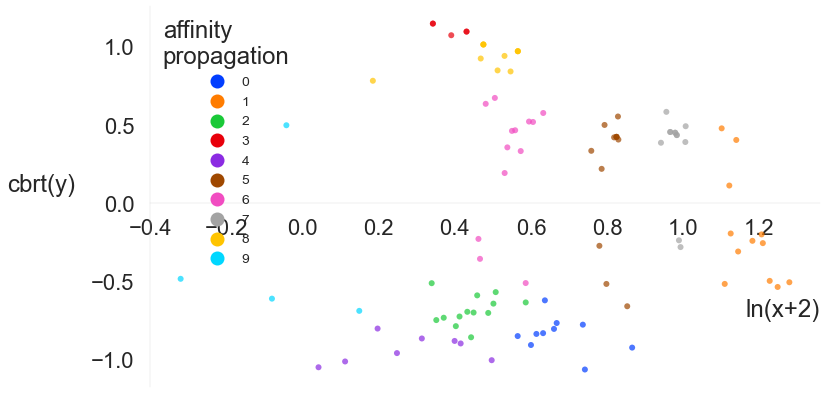

In [161]:
sns.scatterplot(
    x=np.log(ap_df.x + 2),
    y=np.cbrt(ap_df.y),
    hue=ap_df.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False,
    loc="upper left",
    fontsize="xx-small",
    title="affinity\npropagation",
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=60)

plt.show()

In [162]:
sc_df = pca_df[["x", "y"]].copy()
sc_df["cluster_id"] = SpectralClustering(random_state=2021, n_jobs=-1).fit_predict(
    sc_df[["x", "y"]]
)
# defaults to 8 clusters

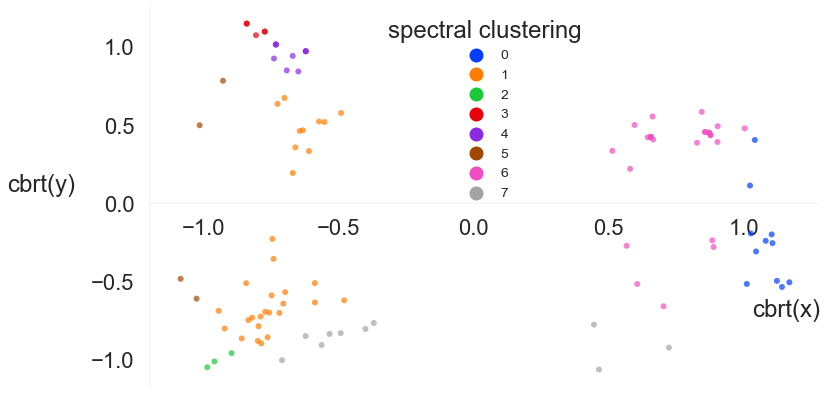

In [163]:
sns.scatterplot(
    x=np.cbrt(sc_df.x),
    y=np.cbrt(sc_df.y),
    hue=sc_df.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="spectral clustering"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

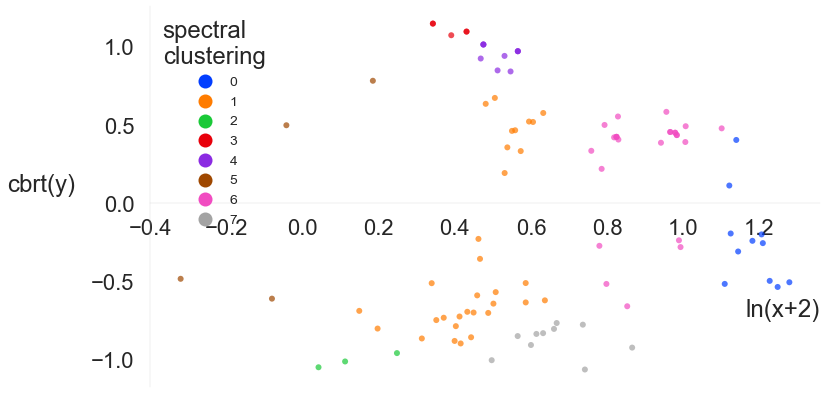

In [164]:
sns.scatterplot(
    x=np.log(sc_df.x + 2),
    y=np.cbrt(sc_df.y),
    hue=sc_df.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False,
    loc="upper left",
    fontsize="xx-small",
    title="spectral\nclustering",
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=60)

plt.show()

In [165]:
ag_df = pca_df[["x", "y"]].copy()
ag_df["cluster_id"] = AgglomerativeClustering().fit_predict(ag_df[["x", "y"]])
# defaults to 2 clusters

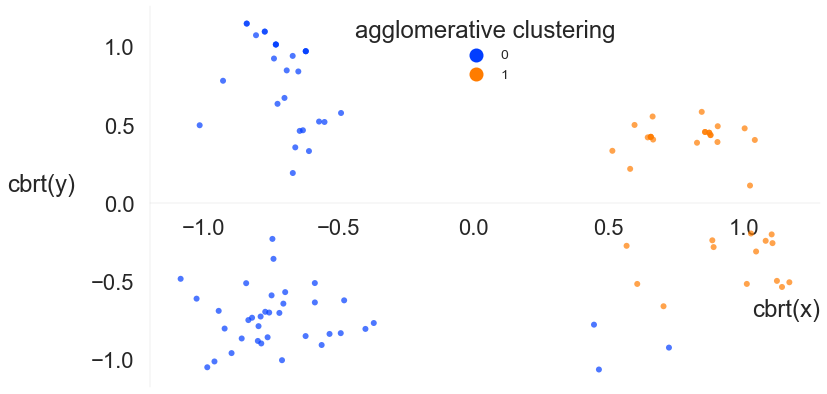

In [166]:
sns.scatterplot(
    x=np.cbrt(ag_df.x),
    y=np.cbrt(ag_df.y),
    hue=ag_df.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="agglomerative clustering"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

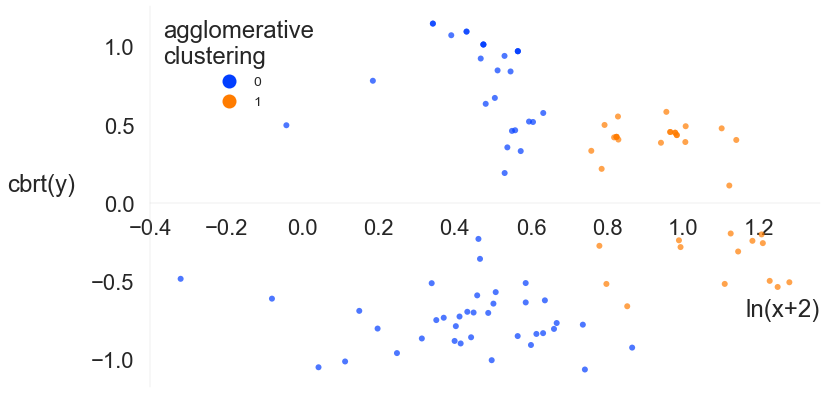

In [167]:
sns.scatterplot(
    x=np.log(ag_df.x + 2),
    y=np.cbrt(ag_df.y),
    hue=ag_df.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False,
    loc="upper left",
    fontsize="xx-small",
    title="agglomerative\nclustering",
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=60)

plt.show()

In [168]:
db_df = pca_df[["x", "y"]].copy()
db_df["cluster_id"] = DBSCAN(n_jobs=-1).fit_predict(db_df[["x", "y"]])

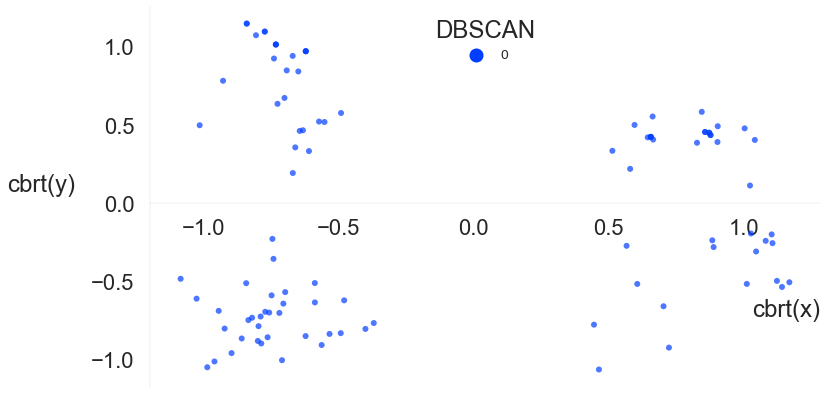

In [169]:
sns.scatterplot(
    x=np.cbrt(db_df.x),
    y=np.cbrt(db_df.y),
    hue=db_df.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="DBSCAN"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

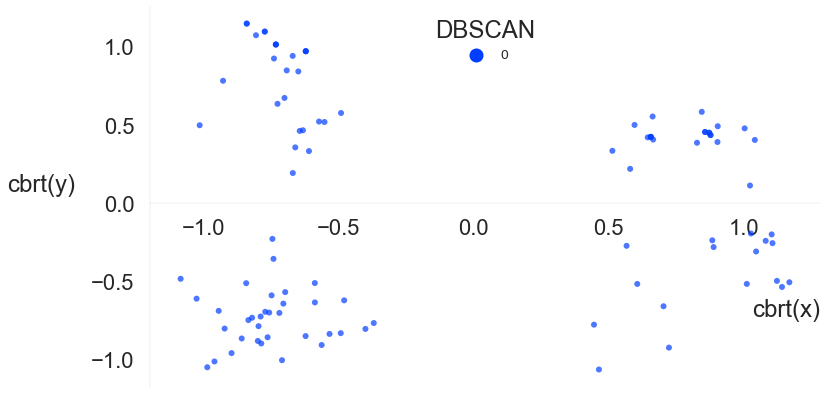

In [170]:
sns.scatterplot(
    x=np.cbrt(db_df.x),
    y=np.cbrt(db_df.y),
    hue=db_df.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="DBSCAN"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

In [171]:
print("Affinity propagation did okay.")
print("Spectral clustering defaults to 8 clusters, so it is less useful for automatic segmentation without further tuning.")
print("Agglomerative clustering defaults to 2 clusters, so it is less useful for automatic segmentation without further tuning.")
print("DBSCAN identified a single cluster, which is unsatisfactory; further tuning is needed.")
print("(https://stackoverflow.com/questions/48051800/why-dbscan-clustering-returns-single-cluster-on-movie-lens-data-set)")

Affinity propagation did okay.
Spectral clustering defaults to 8 clusters, so it is less useful for automatic segmentation without further tuning.
Agglomerative clustering defaults to 2 clusters, so it is less useful for automatic segmentation without further tuning.
DBSCAN identified a single cluster, which is unsatisfactory; further tuning is needed.
(https://stackoverflow.com/questions/48051800/why-dbscan-clustering-returns-single-cluster-on-movie-lens-data-set)


In [172]:
print(
    "I would like to try affinity propagation again with new cluster labels from the crafted features."
)

I would like to try affinity propagation again with new cluster labels from the crafted features.


In [173]:
ap_df2 = pca_df_explore8.drop("deals_component", axis="columns")
ap_df2["x"] = pca_df.x
ap_df2["y"] = pca_df.y
ap_df2["cluster_id"] = AffinityPropagation(random_state=2021).fit_predict(ap_df2)
ap_df2

offers_completed  past_peak_true_pct  origin_component  quarter_component  \
0                  3            0.000000          0.752645          -0.778866   
1                  2            0.000000         -1.187083          -1.022397   
2                  2            0.000000         -1.341977          -0.847061   
3                  2            0.500000         -0.310041           0.038764   
4                  4            0.250000         -0.372520           0.071125   
..               ...                 ...               ...                ...   
95                 3            0.000000          0.752645          -0.743212   
96                 2            0.000000         -0.259379           0.038764   
97                 4            0.000000          0.789948          -0.104211   
98                 4            0.250000         -0.205255           1.132287   
99                 6            0.166667          0.744310           0.067832   

    varietal_component  avg_min_qty  avg_discount%         x         y  \
0            -0.668227     0.000000      63.666667  1.007580  0.108215   
1             0.258281     1.500000      72.500000 -0.287539  0.044715   
2            -1.554218     1.000000      58.500000 -0.392032  1.038391   
3            -0.415064     0.000000      47.000000  0.699477 -0.022542   
4             1.437889     0.500000      61.750000  0.088183 -0.471695   
..                 ...          ...            ...       ...       ...   
95            1.054180     0.666667      67.333333 -0.151666 -0.587844   
96           -0.608809     0.000000      49.500000  0.688224 -0.013688   
97            0.441999     1.000000      65.250000 -0.551215 -0.395670   
98            2.086092     1.000000      68.000000 -0.489805 -0.383307   
99            1.670477     1.500000      59.833333 -0.881994 -1.041788   

    cluster_id  
0            0  
1            2  
2            6  
3            4  
4            6  
..         ...  
95           0  
96           4  
97           0  
98           0  
99           6  

[100 rows x 10 columns]

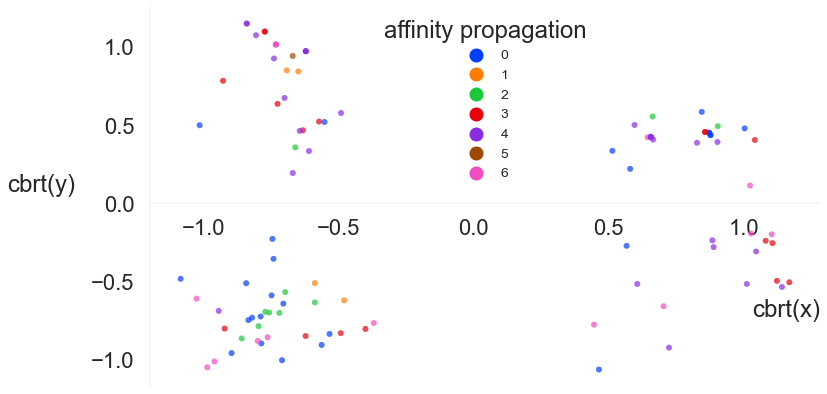

In [174]:
sns.scatterplot(
    x=np.cbrt(ap_df2.x),
    y=np.cbrt(ap_df2.y),
    hue=ap_df2.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper center", fontsize="xx-small", title="affinity propagation"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

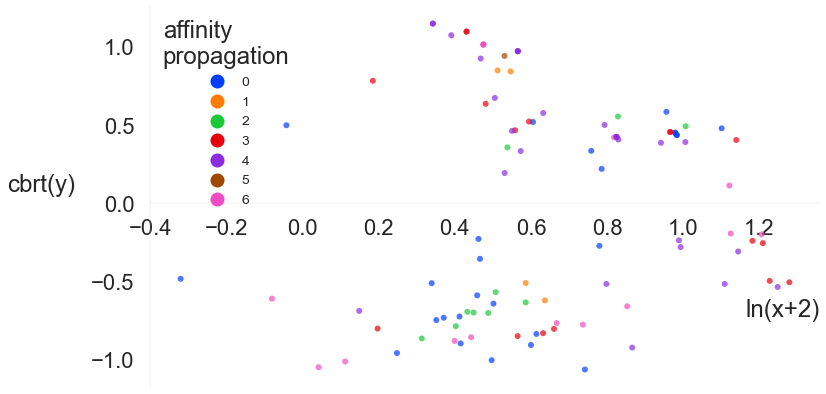

In [175]:
sns.scatterplot(
    x=np.log(ap_df2.x + 2),
    y=np.cbrt(ap_df2.y),
    hue=ap_df2.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False,
    loc="upper left",
    fontsize="xx-small",
    title="affinity\npropagation",
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("ln(x+2)", loc="right", labelpad=60)

plt.show()

In [176]:
print("The plots don't look like well-separated clusters.")
print("Let's try making new components for visualization.")

The plots don't look like well-separated clusters.
Let's try making new components for visualization.


In [177]:
ap_df3 = ap_df2.copy()
ap_df3[["new x", "new y"]] = PCA(n_components=2, random_state=2021).fit_transform(ap_df3)
ap_df3

offers_completed  past_peak_true_pct  origin_component  quarter_component  \
0                  3            0.000000          0.752645          -0.778866   
1                  2            0.000000         -1.187083          -1.022397   
2                  2            0.000000         -1.341977          -0.847061   
3                  2            0.500000         -0.310041           0.038764   
4                  4            0.250000         -0.372520           0.071125   
..               ...                 ...               ...                ...   
95                 3            0.000000          0.752645          -0.743212   
96                 2            0.000000         -0.259379           0.038764   
97                 4            0.000000          0.789948          -0.104211   
98                 4            0.250000         -0.205255           1.132287   
99                 6            0.166667          0.744310           0.067832   

    varietal_component  avg_min_qty  avg_discount%         x         y  \
0            -0.668227     0.000000      63.666667  1.007580  0.108215   
1             0.258281     1.500000      72.500000 -0.287539  0.044715   
2            -1.554218     1.000000      58.500000 -0.392032  1.038391   
3            -0.415064     0.000000      47.000000  0.699477 -0.022542   
4             1.437889     0.500000      61.750000  0.088183 -0.471695   
..                 ...          ...            ...       ...       ...   
95            1.054180     0.666667      67.333333 -0.151666 -0.587844   
96           -0.608809     0.000000      49.500000  0.688224 -0.013688   
97            0.441999     1.000000      65.250000 -0.551215 -0.395670   
98            2.086092     1.000000      68.000000 -0.489805 -0.383307   
99            1.670477     1.500000      59.833333 -0.881994 -1.041788   

    cluster_id      new x     new y  
0            0  -5.162809 -0.640549  
1            2 -13.751883 -2.172671  
2            6   0.656930 -2.509790  
3            4  11.827362 -0.788813  
4            6  -2.765226  0.825186  
..         ...        ...       ...  
95           0  -8.912495  0.082463  
96           4   9.350525 -0.950868  
97           0  -6.830322  0.915271  
98           0  -9.590692  1.384933  
99           6  -0.968327  3.137690  

[100 rows x 12 columns]

In [178]:
# assess skew before visualization
print("x skew:", ap_df3["new x"].skew())
print("y skew:", ap_df3["new y"].skew())
print("x skew after cube:", (ap_df3["new x"]**3).skew())
print("y skew after cube:", (ap_df3["new y"]**3).skew())
print("x skew after ^5:", (ap_df3["new x"]**5).skew())
print("y skew after ^5:", (ap_df3["new y"]**5).skew())
print("x skew after cube root:", np.cbrt(ap_df3["new x"]).skew())
print("y skew after cube root:", np.cbrt(ap_df3["new y"]).skew())
print("x skew after fifth root:", (ap_df3["new x"]**0.2).skew())
print("y skew after fifth root:", (ap_df3["new y"]**0.2).skew())
print("x skew after seventh root:", (ap_df3["new x"]**(1/7)).skew())
print("y skew after seventh root:", (ap_df3["new y"]**(1/7)).skew())
print("x skew after ln(x+3.906):", np.log(ap_df3["new x"]+3.906).skew())
print("y skew after ln(x+3.906):", np.log(ap_df3["new y"]+3.906).skew())
print("x skew after ln(x+10):", np.log(ap_df3["new x"]+10).skew())
print("y skew after ln(x+10):", np.log(ap_df3["new y"]+10).skew())
print("x skew after ln(x+100):", np.log(ap_df3["new x"]+100).skew())
print("y skew after ln(x+100):", np.log(ap_df3["new y"]+100).skew())
print("x skew after ln(x+5):", np.log(ap_df3["new x"]+5).skew())
print("y skew after ln(x+5):", np.log(ap_df3["new y"]+5).skew())
print("x skew after ln(x+4):", np.log(ap_df3["new x"]+4).skew())
print("y skew after ln(x+4):", np.log(ap_df3["new y"]+4).skew())
print("x skew after ln(x+6):", np.log(ap_df3["new x"]+6).skew())
print("y skew after ln(x+6):", np.log(ap_df3["new y"]+6).skew())
print("x skew after ln(x+7):", np.log(ap_df3["new x"]+7).skew())
print("y skew after ln(x+7):", np.log(ap_df3["new y"]+7).skew())
print(ap_df3["new x"].describe())
print(ap_df3["new y"].describe())

x skew: -0.07893866588367514
y skew: 0.9334816392929757
x skew after cube: 0.6835174492332229
y skew after cube: 4.829598258380797
x skew after ^5: 3.1786585315328604
y skew after ^5: 6.590266263355802
x skew after cube root: -0.02016122683348284
y skew after cube root: 0.3236166129476782
x skew after fifth root: -0.7750383361105277
y skew after fifth root: -0.11822137741900568
x skew after seventh root: -0.9422843829882095
y skew after seventh root: -0.21338656247304835
x skew after ln(x+3.906): -0.7498479440505105
y skew after ln(x+3.906): -7.266369158638989
x skew after ln(x+10): -1.7267517562606567
y skew after ln(x+10): 0.4644255969058828
x skew after ln(x+100): -0.437546497432266
y skew after ln(x+100): 0.88279959295679
x skew after ln(x+5): -2.663213563011888
y skew after ln(x+5): -0.18964825786645476
x skew after ln(x+4): -0.7158239179529181
y skew after ln(x+4): -2.0079965548238956
x skew after ln(x+6): -1.181046893149696
y skew after ln(x+6): 0.09814647775444744
x skew after 

C:\Users\michen\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


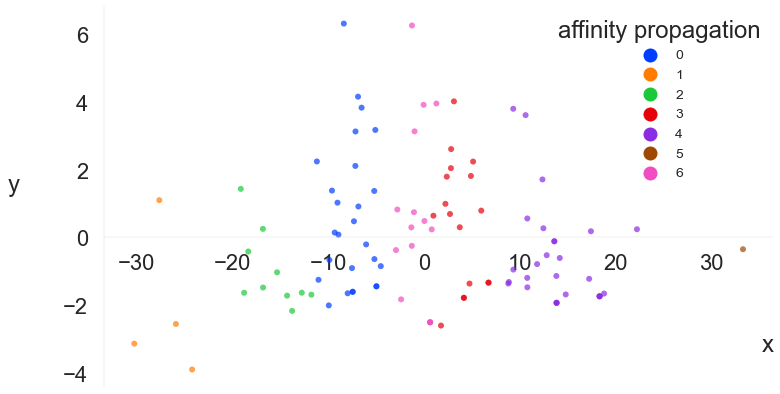

In [179]:
sns.scatterplot(
    x=ap_df3["new x"],
    y=ap_df3["new y"],
    hue=ap_df3.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper right", fontsize="xx-small", title="affinity propagation"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("y", labelpad=50).set_rotation(0)
ax.set_xlabel("x", loc="right", labelpad=60)

plt.show()

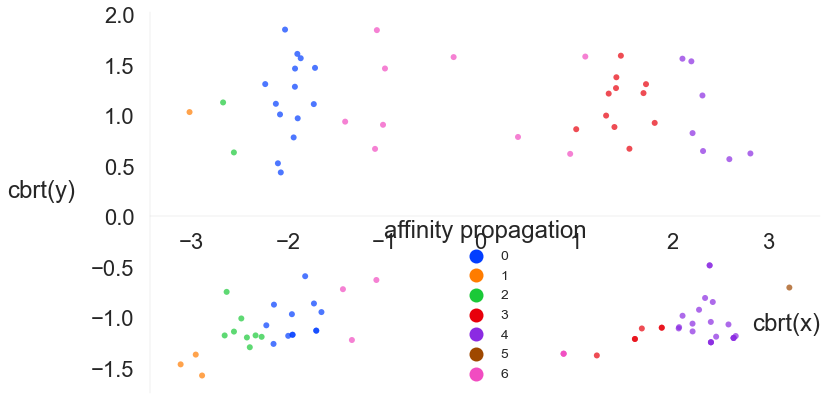

In [180]:
sns.scatterplot(
    x=np.cbrt(ap_df3["new x"]),
    y=np.cbrt(ap_df3["new y"]),
    hue=ap_df3.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="lower center", fontsize="xx-small", title="affinity propagation"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

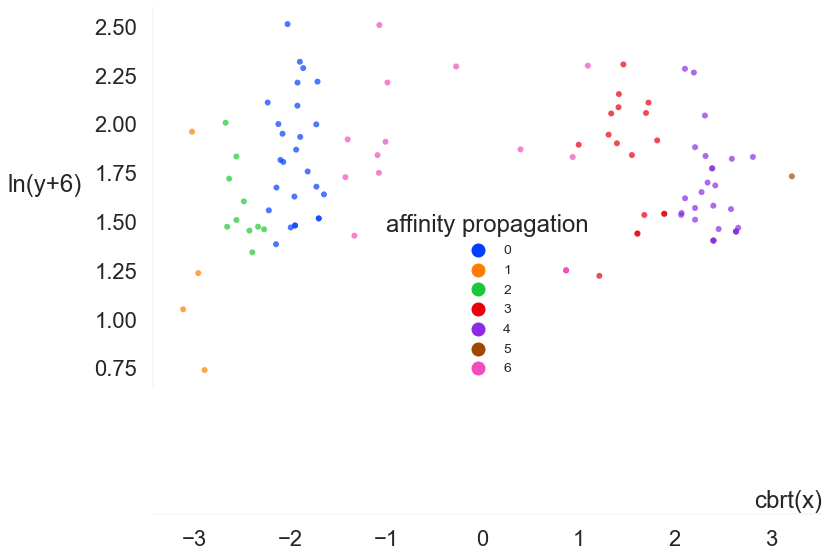

In [181]:
sns.scatterplot(
    x=np.cbrt(ap_df3["new x"]),
    y=np.log(ap_df3["new y"] + 6),
    hue=ap_df3.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="lower center", fontsize="xx-small", title="affinity propagation"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("ln(y+6)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=-60)

plt.show()

In [182]:
print("Those are pretty distinct-looking clusters!")
print("Finally, let's recalculate the cluster IDs.")
print(
    "This time, we'll use the crafted features and the two principal components for deals completed."
)

Those are pretty distinct-looking clusters!
Finally, let's recalculate the cluster IDs.
This time, we'll use the crafted features and the two principal components for deals completed.


In [183]:
ap_df4 = ap_df3.drop(["cluster_id", "new x", "new y"], axis="columns")
visualize = ap_df3[["new x", "new y"]].copy()
visualize["cluster_id"] = AffinityPropagation(random_state=2021).fit_predict(ap_df4)

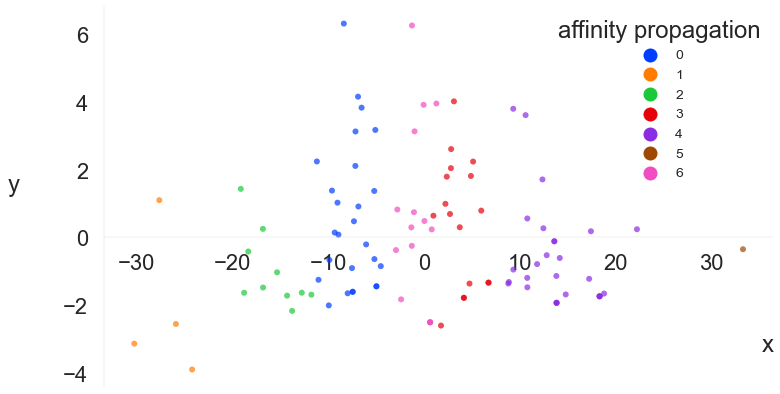

In [184]:
sns.scatterplot(
    x=visualize["new x"],
    y=visualize["new y"],
    hue=visualize.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper right", fontsize="xx-small", title="affinity propagation"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("y", labelpad=50).set_rotation(0)
ax.set_xlabel("x", loc="right", labelpad=60)

plt.show()

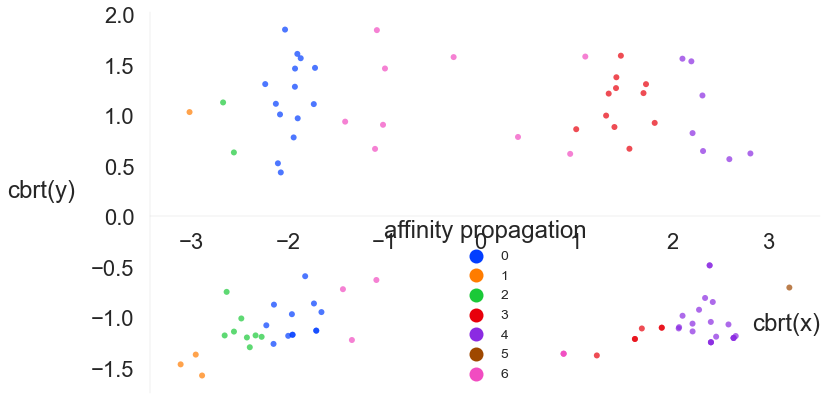

In [185]:
sns.scatterplot(
    x=np.cbrt(visualize["new x"]),
    y=np.cbrt(visualize["new y"]),
    hue=visualize.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="lower center", fontsize="xx-small", title="affinity propagation"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

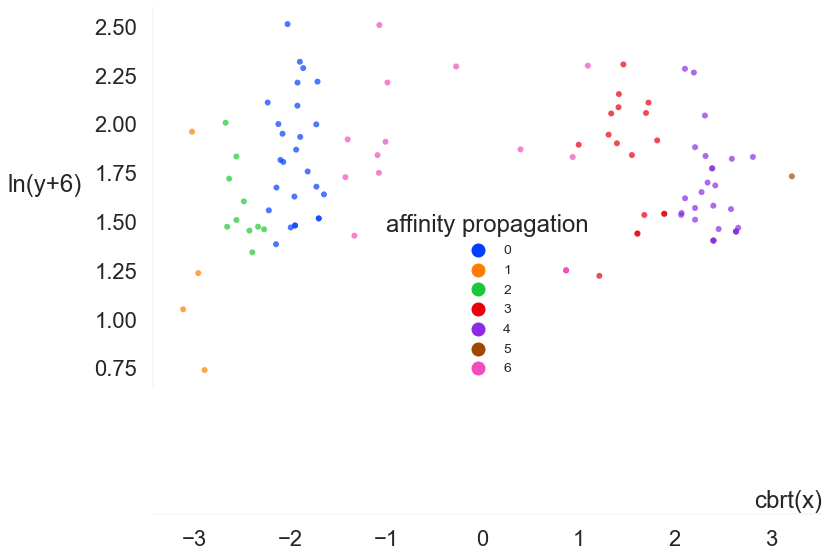

In [186]:
sns.scatterplot(
    x=np.cbrt(visualize["new x"]),
    y=np.log(visualize["new y"] + 6),
    hue=visualize.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="lower center", fontsize="xx-small", title="affinity propagation"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("ln(y+6)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=-60)

plt.show()

In [187]:
print("Seven clusters looks reasonable.")
print(
    "To wrap up, let's try agglomerative clustering and spectral clustering with seven clusters."
)

Seven clusters looks reasonable.
To wrap up, let's try agglomerative clustering and spectral clustering with seven clusters.


In [188]:
visualize_ac = visualize.drop("cluster_id", axis="columns")
visualize_ac["cluster_id"] = AgglomerativeClustering(n_clusters=7).fit_predict(ap_df4)

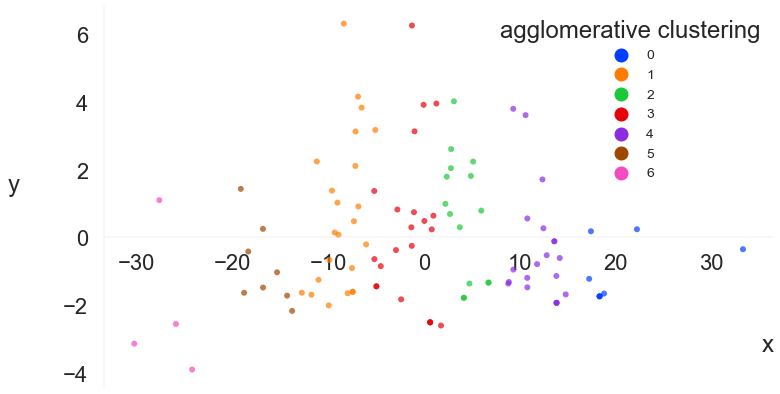

In [189]:
sns.scatterplot(
    x=visualize_ac["new x"],
    y=visualize_ac["new y"],
    hue=visualize_ac.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper right", fontsize="xx-small", title="agglomerative clustering"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("y", labelpad=50).set_rotation(0)
ax.set_xlabel("x", loc="right", labelpad=60)

plt.show()

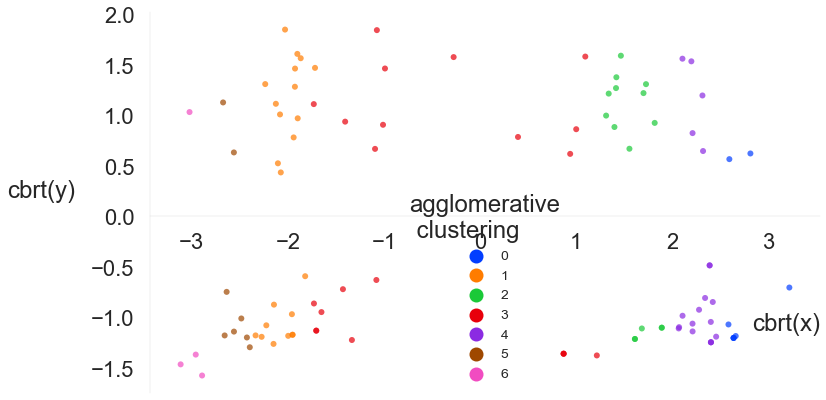

In [190]:
sns.scatterplot(
    x=np.cbrt(visualize_ac["new x"]),
    y=np.cbrt(visualize_ac["new y"]),
    hue=visualize_ac.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="lower center", fontsize="xx-small", title="agglomerative\n clustering"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

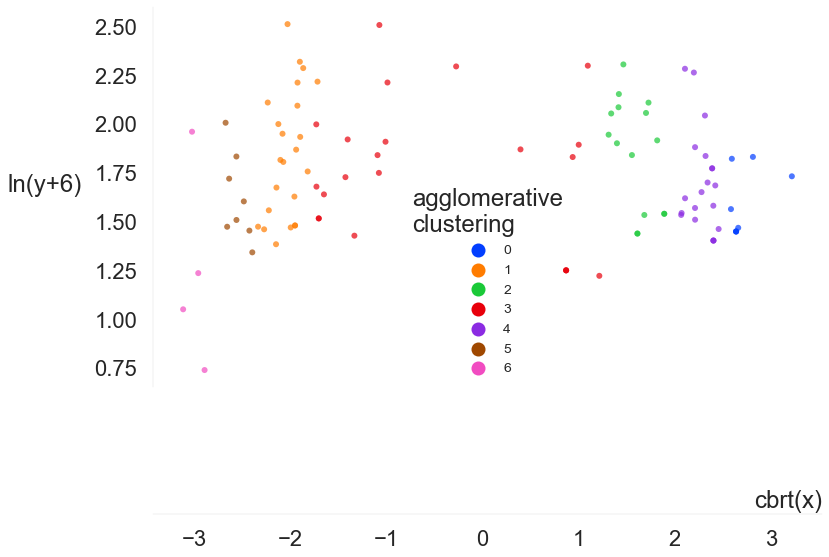

In [191]:
sns.scatterplot(
    x=np.cbrt(visualize_ac["new x"]),
    y=np.log(visualize_ac["new y"] + 6),
    hue=visualize_ac.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="lower center", fontsize="xx-small", title="agglomerative\nclustering"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("ln(y+6)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=-60)

plt.show()

In [192]:
visualize_sc = visualize.drop("cluster_id", axis="columns")
visualize_sc["cluster_id"] = SpectralClustering(
    n_clusters=7, random_state=2021, n_jobs=-1
).fit_predict(ap_df4)

C:\Users\michen\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:289: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  est = KMeans(


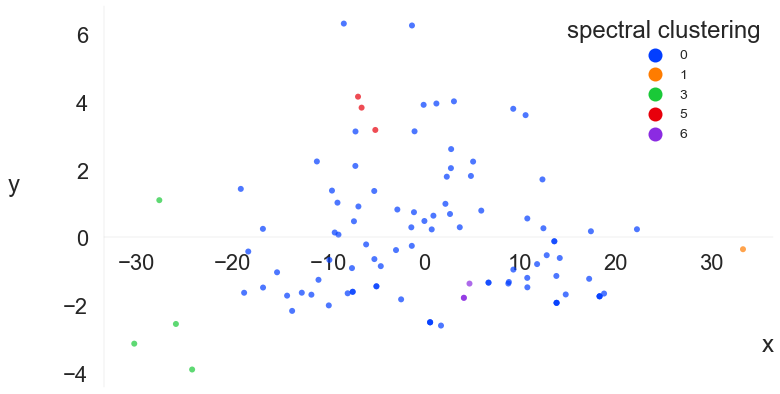

In [193]:
sns.scatterplot(
    x=visualize_sc["new x"],
    y=visualize_sc["new y"],
    hue=visualize_sc.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="upper right", fontsize="xx-small", title="spectral clustering"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("y", labelpad=50).set_rotation(0)
ax.set_xlabel("x", loc="right", labelpad=60)

plt.show()

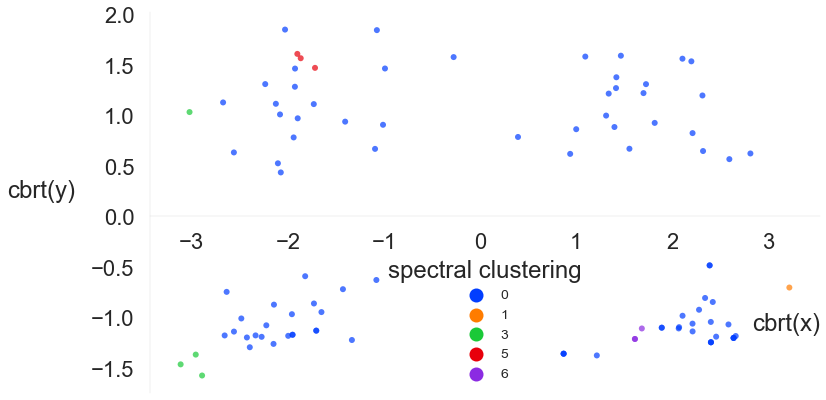

In [194]:
sns.scatterplot(
    x=np.cbrt(visualize_sc["new x"]),
    y=np.cbrt(visualize_sc["new y"]),
    hue=visualize_sc.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="lower center", fontsize="xx-small", title="spectral clustering"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("cbrt(y)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=60)

plt.show()

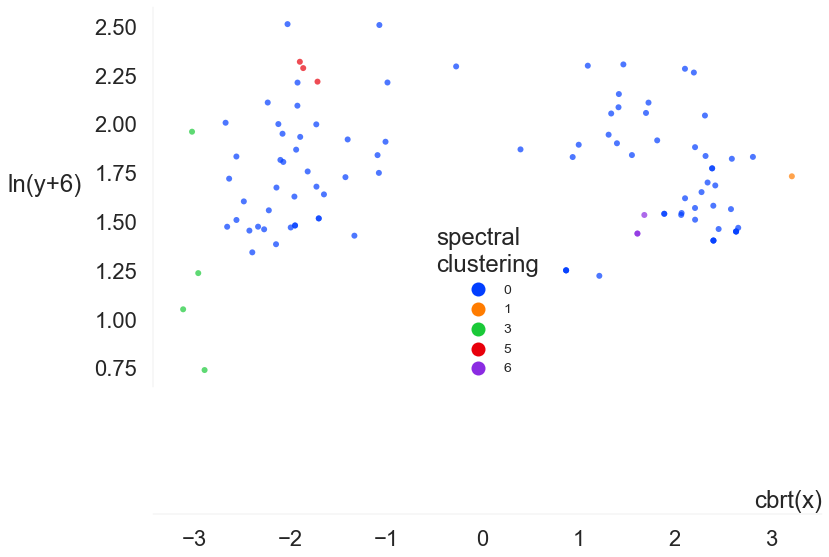

In [195]:
sns.scatterplot(
    x=np.cbrt(visualize_sc["new x"]),
    y=np.log(visualize_sc["new y"] + 6),
    hue=visualize_sc.cluster_id,
    marker=".",
    alpha=0.7,
    linewidth=0,
    palette="bright",
)

plt.gcf().set_size_inches(12, 7)
ax = plt.gca()

plt.grid(False)
plt.legend(
    frameon=False, loc="lower center", fontsize="xx-small", title="spectral\nclustering"
)

ax.spines[["right", "top"]].set_visible(False)
ax.spines.bottom.set_position("zero")
ax.spines[["left", "bottom"]].set_linewidth(0.3)

plt.ylabel("ln(y+6)", labelpad=50).set_rotation(0)
ax.set_xlabel("cbrt(x)", loc="right", labelpad=-60)

plt.show()

In [196]:
print("Agglomerative clustering and affinity propagation performed similarly.")
print()
print("However, spectral clustering identified fewer than 7 clusters.")
print("Moreover, the clusters are intuitively unsatisfactory.")
print()
print("As noted above, spectral clustering is useful for clusters of even size.")
print(
    "Customer segments may not be of even size and the intuitive clusters are of uneven size."
)
print()
print(
    "As noted above, spectral clustering reduces the dimensionality before clustering in a lower dimensional space."
)
print("The crafted features were already reduced in a comparable fashion via PCA.")
print("The amount of information lost in reduction may be amplified as a result.")

Agglomerative clustering and affinity propagation performed similarly.

However, spectral clustering identified fewer than 7 clusters.
Moreover, the clusters are intuitively unsatisfactory.

As noted above, spectral clustering is useful for clusters of even size.
Customer segments may not be of even size and the intuitive clusters are of uneven size.

As noted above, spectral clustering reduces the dimensionality before clustering in a lower dimensional space.
The crafted features were already reduced in a comparable fashion via PCA.
The amount of information lost in reduction may be amplified as a result.
